<a href="https://colab.research.google.com/github/lizhieffe/canonical_llm_impl/blob/main/LLM_from_scratch_chap_07_FT_to_follow_instructions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Tutorial for "LLM from Scratch" Chapter 07

https://drive.google.com/drive/u/1/folders/1a9jbhCJr_dddOT-m-4G9MgBTpOdaCs7Q

Eval scores

- GPT-2 124M SFT 2 epochs: 38
- GPT-2 124M No Pos Embedding SFT 2 epochs: 31 ([link](https://colab.research.google.com/github/lizhieffe/zhi_llm/blob/main/colabs/%5BCanonical%5D_Use_zhi_llm_module.ipynb?authuser=1#scrollTo=2hKJXBNNi0he))
- GPT-2 124M LoRA 2 epochs: 35
- GPT-2 355M LoRA 2 epochs: 46
- GPT-2 355M LoRA 4 epochs: 54
- LLAMA3 8B: 85

In [ ]:
# @title Install Dependencies
!pip install uv
!uv pip install --system -r https://raw.githubusercontent.com/rasbt/LLMs-from-scratch/refs/heads/main/requirements.txt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.4/17.4 MB 101.8 MB/s eta 0:00:00
Using Python 3.11.12 environment at: /usr
Resolved 147 packages in 824ms
⠙ Preparing packages... (0/29)
⠙ Preparing packages... (0/29)
⠙ Preparing packages... (0/29)
⠙ Preparing packages... (0/29)
json5                ------------------------------     0 B/35.23 KiB
⠙ Preparing packages... (0/29)
json5                ------------------------------     0 B/35.23 KiB
⠙ Preparing packages... (0/29)
json5                ------------------------------     0 B/35.23 KiB
⠙ Preparing packages... (0/29)
overrides            ------------------------------     0 B/17.41 KiB
json5                ------------------------------     0 B/35.23 KiB
⠙ Preparing packages... (0/29)
overrides            ------------------------------     0 B/17.41 KiB
json5                 ------------------------------     0 B/35.23 KiB
⠙ Preparing packages... (0/29)
overrides             ------------------------------     0 B/17.41 KiB
json5 

In [ ]:
# @title Imports

import torch
import torch.nn as nn

# GPT-2 Config

We don't use GPT-3 because
- GPT-3 needs a cluster to run while GPT-2 can run on PC
- GPT-2 weights are open

In [ ]:
BASE_CONFIG = {
    "vocab_size": 50257,
    "context_length": 1024,
    "drop_rate": 0.1,
    # The bias in ATTN qkv linear layer.
    # These are not used in recent models since they don't improve the modeling performance.
    # But they are used in GPT-2.
    "qkv_bias": True,
}

In [ ]:
model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

In [ ]:
import pprint

CHOOSE_MODEL = "gpt2-small (124M)"
# CHOOSE_MODEL = "gpt2-medium (355M)"

BASE_CONFIG.update(model_configs[CHOOSE_MODEL])
model_size = CHOOSE_MODEL.split(" ")[-1].lstrip("(").rstrip(")")

pprint.pprint(f"{BASE_CONFIG=}")
print(f"{model_size=}")

("BASE_CONFIG={'vocab_size': 50257, 'context_length': 1024, 'drop_rate': 0.1, "
 "'qkv_bias': True, 'emb_dim': 768, 'n_layers': 12, 'n_heads': 12}")
model_size='124M'


# Device

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# Instruction Following DS

## Download

In [ ]:
import json
import os
import urllib
import pprint

def download_and_load_file(file_path, url) -> list[dict[str, str]]:
  if not os.path.exists(file_path):
    with urllib.request.urlopen(url) as response:
      text_data = response.read().decode("utf-8")
      print(f"{len(text_data)=}")
    with open(file_path, "w", encoding="utf-8") as file:
      file.write(text_data)
  with open(file_path, "r") as file:
    data = json.load(file)
  return data

file_path = "instruction-data.json"
url = (
    "https://raw.githubusercontent.com/rasbt/LLMs-from-scratch"
    "/main/ch07/01_main-chapter-code/instruction-data.json"
)

data = download_and_load_file(file_path, url)
print("Number of entries:", len(data))

for it in data[:5]:
  pprint.pprint(it)

Number of entries: 1100
{'input': 'freind --> friend',
 'instruction': 'Evaluate the following phrase by transforming it into the '
                'spelling given.',
 'output': 'The spelling of the given phrase "freind" is incorrect, the '
           'correct spelling is "friend".'}
{'input': 'He go to the park every day.',
 'instruction': 'Edit the following sentence for grammar.',
 'output': 'He goes to the park every day.'}
{'input': '',
 'instruction': 'Convert 45 kilometers to meters.',
 'output': '45 kilometers is 45000 meters.'}
{'input': '',
 'instruction': "Rewrite this sentence to start with 'Although': Despite the "
                'rain, they went for a walk.',
 'output': 'Although it was raining, they went for a walk.'}
{'input': '',
 'instruction': 'What are the first 10 square numbers?',
 'output': '1, 4, 9, 16, 25, 36, 49, 64, 81, 100.'}


## Format prompt

In [ ]:
TEMPLATE_WITH_INPUT = """Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
{instruction}

### Input:
{input}
"""

TEMPLATE_WO_INPUT = """Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
{instruction}
"""

TEMPLATE_RESP = """### Response:
{response}
"""

def format_input(entry: dict[str, str], include_resp: bool = True) -> str:
  instruction = entry["instruction"]
  response = entry["output"]
  if "input" in entry and entry['input']:
    input = entry["input"]
    ret = TEMPLATE_WITH_INPUT.format(instruction=instruction, input=input, response=response)
  else:
    ret = TEMPLATE_WO_INPUT.format(instruction=instruction, response=response)

  if include_resp:
    return ret + "\n" + TEMPLATE_RESP.format(response=response)
  else:
    return ret

print(format_input(data[50]))
print(format_input(data[999]))



Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Identify the correct spelling of the following word.

### Input:
Ocassion

### Response:
The correct spelling is 'Occasion.'

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
What is an antonym of 'complicated'?

### Response:
An antonym of 'complicated' is 'simple'.



## Split the data

In [ ]:
train_portion = int(len(data) * 0.85)
test_portion = int(len(data) * 0.1)
val_portion = len(data) - train_portion - test_portion

train_data = data[:train_portion]
test_data = data[train_portion:train_portion + test_portion]
val_data = data[train_portion + test_portion:]

print(f"{len(train_data)=}")
print(f"{len(val_data)=}")
print(f"{len(test_data)=}")

len(train_data)=935
len(val_data)=55
len(test_data)=110


# BPE Tokenizer

See chap 02 for details

In [ ]:
!uv pip install tiktoken

from importlib.metadata import version
import tiktoken
print(f"{version('tiktoken')=}")

tokenizer = tiktoken.get_encoding("gpt2")
print(f"{tokenizer.name=}")
assert tokenizer.n_vocab == BASE_CONFIG["vocab_size"]

text = (
"Hello, do you like tea? <|endoftext|> In the sunlit terraces"
"of someunknownPlace."
)
integers = tokenizer.encode(text, allowed_special={"<|endoftext|>"})
print(f"{integers=}")

decoded = tokenizer.decode(integers)
print(f"{decoded=}")


text1 = "Every effort moves you"
text2 = "Every day holds a"
batch = tokenizer.encode_batch([text1, text2])
batch = torch.tensor(batch)
print(f"{batch.shape=}")

decoded = tokenizer.decode_batch(batch.numpy())
print(f"{decoded=}")
assert decoded == [text1, text2]

Using Python 3.11.12 environment at: /usr
Audited 1 package in 77ms
version('tiktoken')='0.9.0'
tokenizer.name='gpt2'
integers=[15496, 11, 466, 345, 588, 8887, 30, 220, 50256, 554, 262, 4252, 18250, 8812, 2114, 1659, 617, 34680, 27271, 13]
decoded='Hello, do you like tea? <|endoftext|> In the sunlit terracesof someunknownPlace.'
batch.shape=torch.Size([2, 4])
decoded=['Every effort moves you', 'Every day holds a']


# Prepare Dataset

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader

class InstructionDataset(Dataset):
  def __init__(self, data, tokenizer):
    super().__init__()
    texts = [format_input(it) for it in data]
    self.tokens = tokenizer.encode_batch(texts)
    assert len(data) == len(self.tokens)
    assert tokenizer.decode(self.tokens[0]) == texts[0]

  def __len__(self):
    return len(self.tokens)

  def __getitem__(self, index):
    return self.tokens[index]

dataset = InstructionDataset(data, tokenizer)
print(f"{len(dataset)=}")
print(f"{dataset[0]=}")

len(dataset)=1100
dataset[0]=[21106, 318, 281, 12064, 326, 8477, 257, 4876, 13, 19430, 257, 2882, 326, 20431, 32543, 262, 2581, 13, 198, 198, 21017, 46486, 25, 198, 36, 2100, 4985, 262, 1708, 9546, 416, 25449, 340, 656, 262, 24993, 1813, 13, 198, 198, 21017, 23412, 25, 198, 19503, 521, 14610, 1545, 198, 198, 21017, 18261, 25, 198, 464, 24993, 286, 262, 1813, 9546, 366, 19503, 521, 1, 318, 11491, 11, 262, 3376, 24993, 318, 366, 6726, 1911, 198]


## Custom collate() fn

So that we pad on the batch level, instead of the whole dataset level.

- Assign the 1st token after the last token as EOS, so that the model can learn to stop.

- Assign the non-1st token after the last token to -100, so that the training loop knows to avoid calculating loss. Note, the default ignore_index in torch cross-entry is -100.

- It is also common to **mask the target token IDs that correspond to the instruction**, so that only the output part in the target token IDs have the loss.
  - However, there are different opinions in research whether this gives the best results.
  - Here we don't mask them.

In [ ]:
# @title collate() v1 - no target tensor

def custom_collate_draft_1(
    batch,
    pat_token_id=50256,
    device="cpu"
):
  batch_max_length = max(len(it) + 1 for it in batch)
  print(f"{batch_max_length=}")

  output = []
  for it in batch:
    output.append(it + [pat_token_id] * (batch_max_length - len(it)))
    assert len(output[-1]) == batch_max_length

  t = torch.tensor(output, dtype=torch.long, device=device)
  # Remove the added pads
  t = t[:, :-1]
  return t

# Test 1
out = custom_collate_draft_1(dataset[:10])
print(f"{out.shape=}")

# Test 2
inputs_1 = [0, 1, 2, 3, 4]
inputs_2 = [5, 6]
inputs_3 = [7, 8, 9]
batch = (
    inputs_1,
    inputs_2,
    inputs_3
)
out = custom_collate_draft_1(batch)
print(out)

batch_max_length=76
out.shape=torch.Size([10, 75])
batch_max_length=6
tensor([[    0,     1,     2,     3,     4],
        [    5,     6, 50256, 50256, 50256],
        [    7,     8,     9, 50256, 50256]])


In [ ]:
# @title V2 - has both input and target

def custom_collate_draft_2(
    batch,
    pat_token_id=50256,
    device="cpu"
):
  batch_max_length = max(len(it) + 1 for it in batch)
  print(f"{batch_max_length=}")

  padded_batch = []
  for it in batch:
    padded_batch.append(it + [pat_token_id] * (batch_max_length - len(it)))
    assert len(padded_batch[-1]) == batch_max_length

  inputs = torch.tensor(padded_batch, dtype=torch.long, device=device)[:, :-1]
  targets = torch.tensor(padded_batch, dtype=torch.long, device=device)[:, 1:]
  return inputs, targets


# Test 2
inputs_1 = [0, 1, 2, 3, 4]
inputs_2 = [5, 6]
inputs_3 = [7, 8, 9]
batch = (
    inputs_1,
    inputs_2,
    inputs_3
)
inputs, targets = custom_collate_draft_2(batch)
print(f"{inputs.shape=}")
print(f"{targets.shape=}")
print(inputs)
print(targets)

batch_max_length=6
inputs.shape=torch.Size([3, 5])
targets.shape=torch.Size([3, 5])
tensor([[    0,     1,     2,     3,     4],
        [    5,     6, 50256, 50256, 50256],
        [    7,     8,     9, 50256, 50256]])
tensor([[    1,     2,     3,     4, 50256],
        [    6, 50256, 50256, 50256, 50256],
        [    8,     9, 50256, 50256, 50256]])


In [ ]:
# @title V3 - has both input and target

def custom_collate_fn(
    batch,
    pat_token_id=50256,
    # The torch crossentry default ignore_index is -100.
    ignore_index=-100,
    allowed_max_length=None,
    device="cpu"
):
  batch_max_length = max(len(it) for it in batch)
  # if allowed_max_length is not None:
  #   batch_max_length = min(batch_max_length, allowed_max_length)

  # print(f"{batch_max_length=}")

  inputs = []
  targets = []
  for it in batch:
    inputs.append(
        torch.tensor(
            it + [pat_token_id] * (batch_max_length - len(it)),
            dtype=torch.long,
            device=device,
        )
    )
    targets.append(
        torch.tensor(
            it[1:] + [pat_token_id] + [ignore_index] * (batch_max_length - len(it)),
            dtype=torch.long,
            device=device,
        )
    )
    assert len(inputs[-1]) == batch_max_length
    assert len(targets[-1]) == batch_max_length

  inputs = torch.stack(inputs)
  targets = torch.stack(targets)

  if allowed_max_length:
    batch_max_length = min(batch_max_length, allowed_max_length)
    inputs = inputs[:, :batch_max_length]
    targets = targets[:, :batch_max_length]
  return inputs, targets


# Test 2
inputs_1 = [0, 1, 2, 3, 4]
inputs_2 = [5, 6]
inputs_3 = [7, 8, 9]
batch = (
    inputs_1,
    inputs_2,
    inputs_3
)
inputs, targets = custom_collate_fn(batch)
print(f"{inputs.shape=}")
print(f"{targets.shape=}")
print(inputs)
print(targets)

print("="*80)

inputs, targets = custom_collate_fn(batch, allowed_max_length=4)
print(f"{inputs.shape=}")
print(f"{targets.shape=}")
print(inputs)
print(targets)

inputs.shape=torch.Size([3, 5])
targets.shape=torch.Size([3, 5])
tensor([[    0,     1,     2,     3,     4],
        [    5,     6, 50256, 50256, 50256],
        [    7,     8,     9, 50256, 50256]])
tensor([[    1,     2,     3,     4, 50256],
        [    6, 50256,  -100,  -100,  -100],
        [    8,     9, 50256,  -100,  -100]])
inputs.shape=torch.Size([3, 4])
targets.shape=torch.Size([3, 4])
tensor([[    0,     1,     2,     3],
        [    5,     6, 50256, 50256],
        [    7,     8,     9, 50256]])
tensor([[    1,     2,     3,     4],
        [    6, 50256,  -100,  -100],
        [    8,     9, 50256,  -100]])


# Data Loader

In [ ]:
from functools import partial

customized_collate_fn = partial(
    custom_collate_fn, device=device, allowed_max_length=BASE_CONFIG["context_length"])

num_workers = 0
batch_size = 8
torch.manual_seed(123)

train_dataset = InstructionDataset(train_data, tokenizer)
val_dataset = InstructionDataset(val_data, tokenizer)
test_dataset = InstructionDataset(test_data, tokenizer)

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    drop_last=True,
    collate_fn=customized_collate_fn,
)
val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    drop_last=False,
    collate_fn=customized_collate_fn,
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    drop_last=False,
    collate_fn=customized_collate_fn,
)

print(f"{len(train_loader)=}")
for idx, (inputs, targets) in enumerate(train_loader):
  print(f"{inputs.shape=}, {targets.shape=}")
  if idx > 5:
    break

len(train_loader)=116
inputs.shape=torch.Size([8, 62]), targets.shape=torch.Size([8, 62])
inputs.shape=torch.Size([8, 77]), targets.shape=torch.Size([8, 77])
inputs.shape=torch.Size([8, 74]), targets.shape=torch.Size([8, 74])
inputs.shape=torch.Size([8, 69]), targets.shape=torch.Size([8, 69])
inputs.shape=torch.Size([8, 66]), targets.shape=torch.Size([8, 66])
inputs.shape=torch.Size([8, 73]), targets.shape=torch.Size([8, 73])
inputs.shape=torch.Size([8, 81]), targets.shape=torch.Size([8, 81])


# Build Backbone

# Layer Norm

- It improves the training stability. (less gradient vanish or explosion)
- It is usually added at
  1. pre- or post- MHA, and
  2. before the final output layer
- VS **Batch Norm**: Since layer normalization normal-
izes each input independently of the batch size, it offers more flexibility and stability
in these scenarios. This is particularly beneficial for distributed training or when
deploying models in environments where resources are constrained.

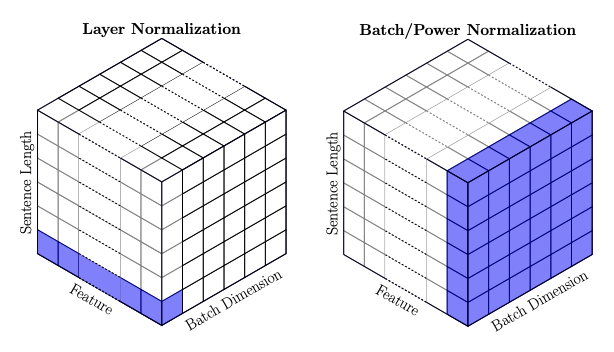

In [ ]:
# @title Simple test of normalization

torch.manual_seed(123)
batch_example = torch.randn(2, 5)
layer = nn.Sequential(nn.Linear(5, 6), nn.ReLU())
out = layer(batch_example)
print(f"{out.shape=}")
print(f"{out=}")

mean = out.mean(dim=-1, keepdim=True)
var = out.var(dim=-1, keepdim=True)
print(f"{mean=}")
print(f"{var=}")
normalized = (out - mean) / torch.sqrt(var)
print(f"{normalized=}")

mean_normalized = normalized.mean(dim=-1, keepdim=True)
var_normalized = normalized.var(dim=-1, keepdim=True)
print(f"{mean_normalized=}")
print(f"{var_normalized=}")

out.shape=torch.Size([2, 6])
out=tensor([[0.2260, 0.3470, 0.0000, 0.2216, 0.0000, 0.0000],
        [0.2133, 0.2394, 0.0000, 0.5198, 0.3297, 0.0000]],
       grad_fn=<ReluBackward0>)
mean=tensor([[0.1324],
        [0.2170]], grad_fn=<MeanBackward1>)
var=tensor([[0.0231],
        [0.0398]], grad_fn=<VarBackward0>)
normalized=tensor([[ 0.6159,  1.4126, -0.8719,  0.5872, -0.8719, -0.8719],
        [-0.0189,  0.1121, -1.0876,  1.5173,  0.5647, -1.0876]],
       grad_fn=<DivBackward0>)
mean_normalized=tensor([[9.9341e-09],
        [1.9868e-08]], grad_fn=<MeanBackward1>)
var_normalized=tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


In [ ]:
# @title Real impl

class LayerNorm(nn.Module):
  def __init__(self, emb_dim):
    super().__init__()
    self.eps = 1e-5
    self.scale = nn.Parameter(torch.ones(emb_dim))
    self.shift = nn.Parameter(torch.zeros(emb_dim))

  def forward(self, x):
    # x [B, N, H_DIM]
    mean = x.mean(dim=-1, keepdim=True) # [B, N, 1]
    #  in the variance calculation, we divide by the number of inputs n in the variance formula. This approach does
    # not apply Bessel’s correction, which typically uses n – 1 instead of n in the denomi-
    # nator to adjust for bias in sample variance estimation. This decision results in a so-
    # called biased estimate of the variance. For LLMs, where the embedding dimension n
    # is significantly large, the difference between using n and n – 1 is practically negligible.
    # I chose this approach to ensure compatibility with the GPT-2 model’s normalization
    # layers and because it reflects TensorFlow’s default behavior, which was used to
    # implement the original GPT-2 model. Using a similar setting ensures our method is
    # compatible with the pretrained weights we will load in chapter 6.
    var = x.var(dim=-1, keepdim=True, unbiased=False)   # [B, N, 1]
    normalized = (x - mean) / torch.sqrt(var + self.eps) # [B, N, H_DIM]
    return self.scale * normalized + self.shift

ln = LayerNorm(5)
out = ln(batch_example)
print(out)

out_mean = out.mean(dim=-1, keepdim=True)
out_var = out.var(dim=-1, keepdim=True, unbiased=False)
print(f"{out_mean=}")
print(f"{out_var=}")

tensor([[ 0.5528,  1.0693, -0.0223,  0.2656, -1.8654],
        [ 0.9087, -1.3767, -0.9564,  1.1304,  0.2940]], grad_fn=<AddBackward0>)
out_mean=tensor([[-2.9802e-08],
        [ 0.0000e+00]], grad_fn=<MeanBackward1>)
out_var=tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


# GeLU

- Smoother than ReLU
- SwiGLU is another widely used activation

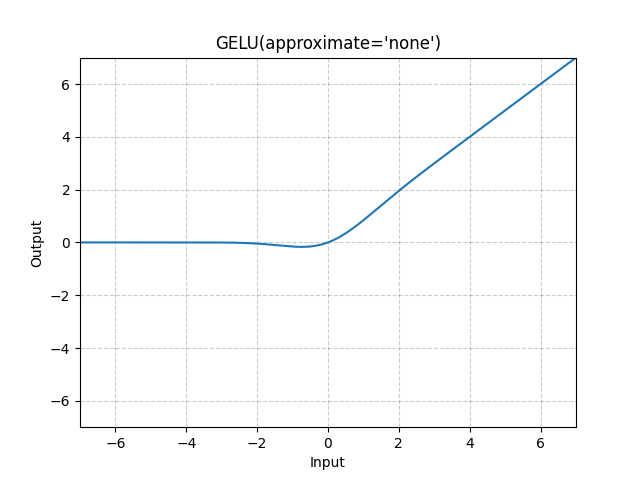

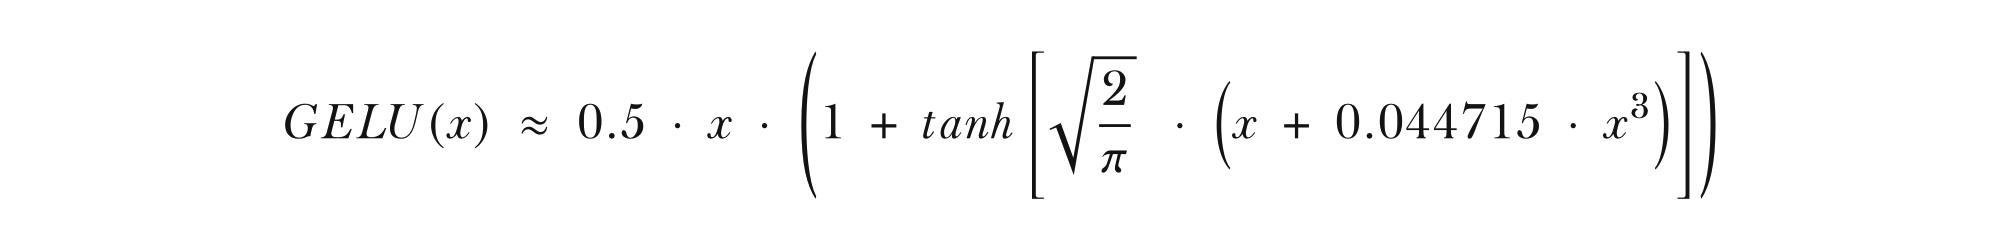

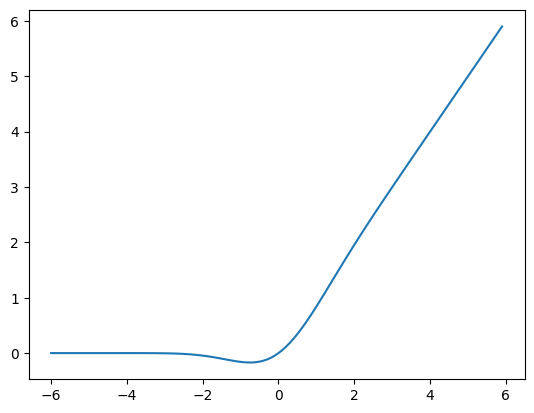

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

class GELU(nn.Module):
  def __init__(self):
    super().__init__()


  def forward(self, x):
    return 0.5 * x * (1 + torch.tanh(torch.sqrt(torch.tensor(2 / torch.pi)) * (x + 0.044715 * torch.pow(x, 3))))

# Test
gelu = GELU()
data_example = torch.tensor(np.arange(-6, 6, 0.1))
out = gelu(data_example)

plt.plot(data_example.numpy(), out.numpy())

# FFN

In [ ]:
class FeedForward(nn.Module):
  def __init__(self, config):
    super().__init__()
    self.layers = nn.Sequential(
        nn.Linear(config["emb_dim"], config["emb_dim"] * 4),
        GELU(),
        nn.Linear(config["emb_dim"] * 4, config["emb_dim"]),
    )

  def forward(self, x):
    return self.layers(x)

# Skip Connection

In [ ]:
# @title Test a toy skip connection

class ExampleDeepNeuralNetwork(nn.Module):
  def __init__(self, layer_sizes, use_shortcut):
    super().__init__()
    self.use_shortcut = use_shortcut
    self.layers = nn.ModuleList([
        nn.Sequential(
            nn.Linear(layer_sizes[0], layer_sizes[1]),
            GELU(),
        ),
        nn.Sequential(
            nn.Linear(layer_sizes[1], layer_sizes[2]),
            GELU(),
        ),
        nn.Sequential(
            nn.Linear(layer_sizes[2], layer_sizes[3]),
            GELU(),
        ),
        nn.Sequential(
            nn.Linear(layer_sizes[3], layer_sizes[4]),
            GELU(),
        ),
        nn.Sequential(
            nn.Linear(layer_sizes[4], layer_sizes[5]),
            GELU(),
        ),
    ])

  def forward(self, x):
    for l in self.layers:
      y = l(x)
      if self.use_shortcut:
        y += x
      x = y
    return x

# Transformer block

Connect the components together

In [ ]:
# @title MHA coplied from Chap 03

class MultiHeadAttention(nn.Module):
  def __init__(self, d_in, d_out, context_length, num_heads, dropout, qkv_bias=False):
    super().__init__()

    assert d_out % num_heads == 0, "d_out must be divisible by num_heads!"

    self.heads = num_heads
    self.head_dim = d_out // num_heads

    self.wk = nn.Linear(d_in, d_out, bias=qkv_bias) # [E, H]
    self.wq = nn.Linear(d_in, d_out, bias=qkv_bias) # [E, H]
    self.wv = nn.Linear(d_in, d_out, bias=qkv_bias) # [E, H]
    self.droput = nn.Dropout(dropout)
    self.out_proj = nn.Linear(d_out, d_out)
    self.register_buffer('mask', torch.triu(torch.ones(context_length, context_length), diagonal=1))

  def forward(self, x):
    """Forward.

    Args:
      x: [B, N, E]

    Returns:
      [B, N, H]
    """
    b, n, d_in = x.shape

    k = self.wk(x) # [B, N, H]
    q = self.wq(x) # [B, N, H]
    v = self.wv(x) # [B, N, H]

    k = k.view(b, n, self.heads, self.head_dim).transpose(1, 2) # [B, HEADS, N, HEAD_DIM]
    q = q.view(b, n, self.heads, self.head_dim).transpose(1, 2) # [B, HEADS, N, HEAD_DIM]
    v = v.view(b, n, self.heads, self.head_dim).transpose(1, 2) # [B, HEADS, N, HEAD_DIM]

    attn = q @ k.transpose(-1, -2) # [B, HEADS, N, N]
    assert attn.shape == (b, self.heads, n, n)
    # print(f"Before causal: {attn=}")

    # [:n, :n] is to truncate to the length of input tokens.
    attn = attn.masked_fill(self.mask.bool()[:n, :n], -torch.inf)
    # print(f"After causal: {attn[0][0]=}")

    attn /= self.head_dim ** 0.5
    attn = nn.functional.softmax(attn, dim=-1)
    # print(f"After softmax: {attn[0][0]=}")
    attn = self.droput(attn)
    res = attn @ v # [B, HEADS, N, H]
    res = res.transpose(1, 2).contiguous().view(b, n, -1) # [B, N, H]

    res = self.out_proj(res)  # [B, N, H]

    return res

In [ ]:
# @title The Transformer block

class TransformerBlock(nn.Module):

  def __init__(self, config):
    super().__init__()

    self.norm1 = LayerNorm(config["emb_dim"])
    self.norm2 = LayerNorm(config["emb_dim"])
    self.mha = MultiHeadAttention(
        d_in=config["emb_dim"],
        d_out=config["emb_dim"],
        context_length=config['context_length'],
        num_heads=config["n_heads"],
        dropout=config["drop_rate"],
        qkv_bias=config["qkv_bias"]
    )
    self.ffn = FeedForward(config)
    self.dropout = nn.Dropout(config['drop_rate'])

  def forward(self, x):
    shortcut = x
    y = self.norm1(x)
    y = self.mha(y)
    # TODO: is this needed since the MHA already has the dropout internally.
    y = self.dropout(y)
    x = y + shortcut

    shortcut = x
    y = self.norm2(x)
    y = self.ffn(y)
    y = self.dropout(y)
    y = y + shortcut

    return y


# The GPT Model

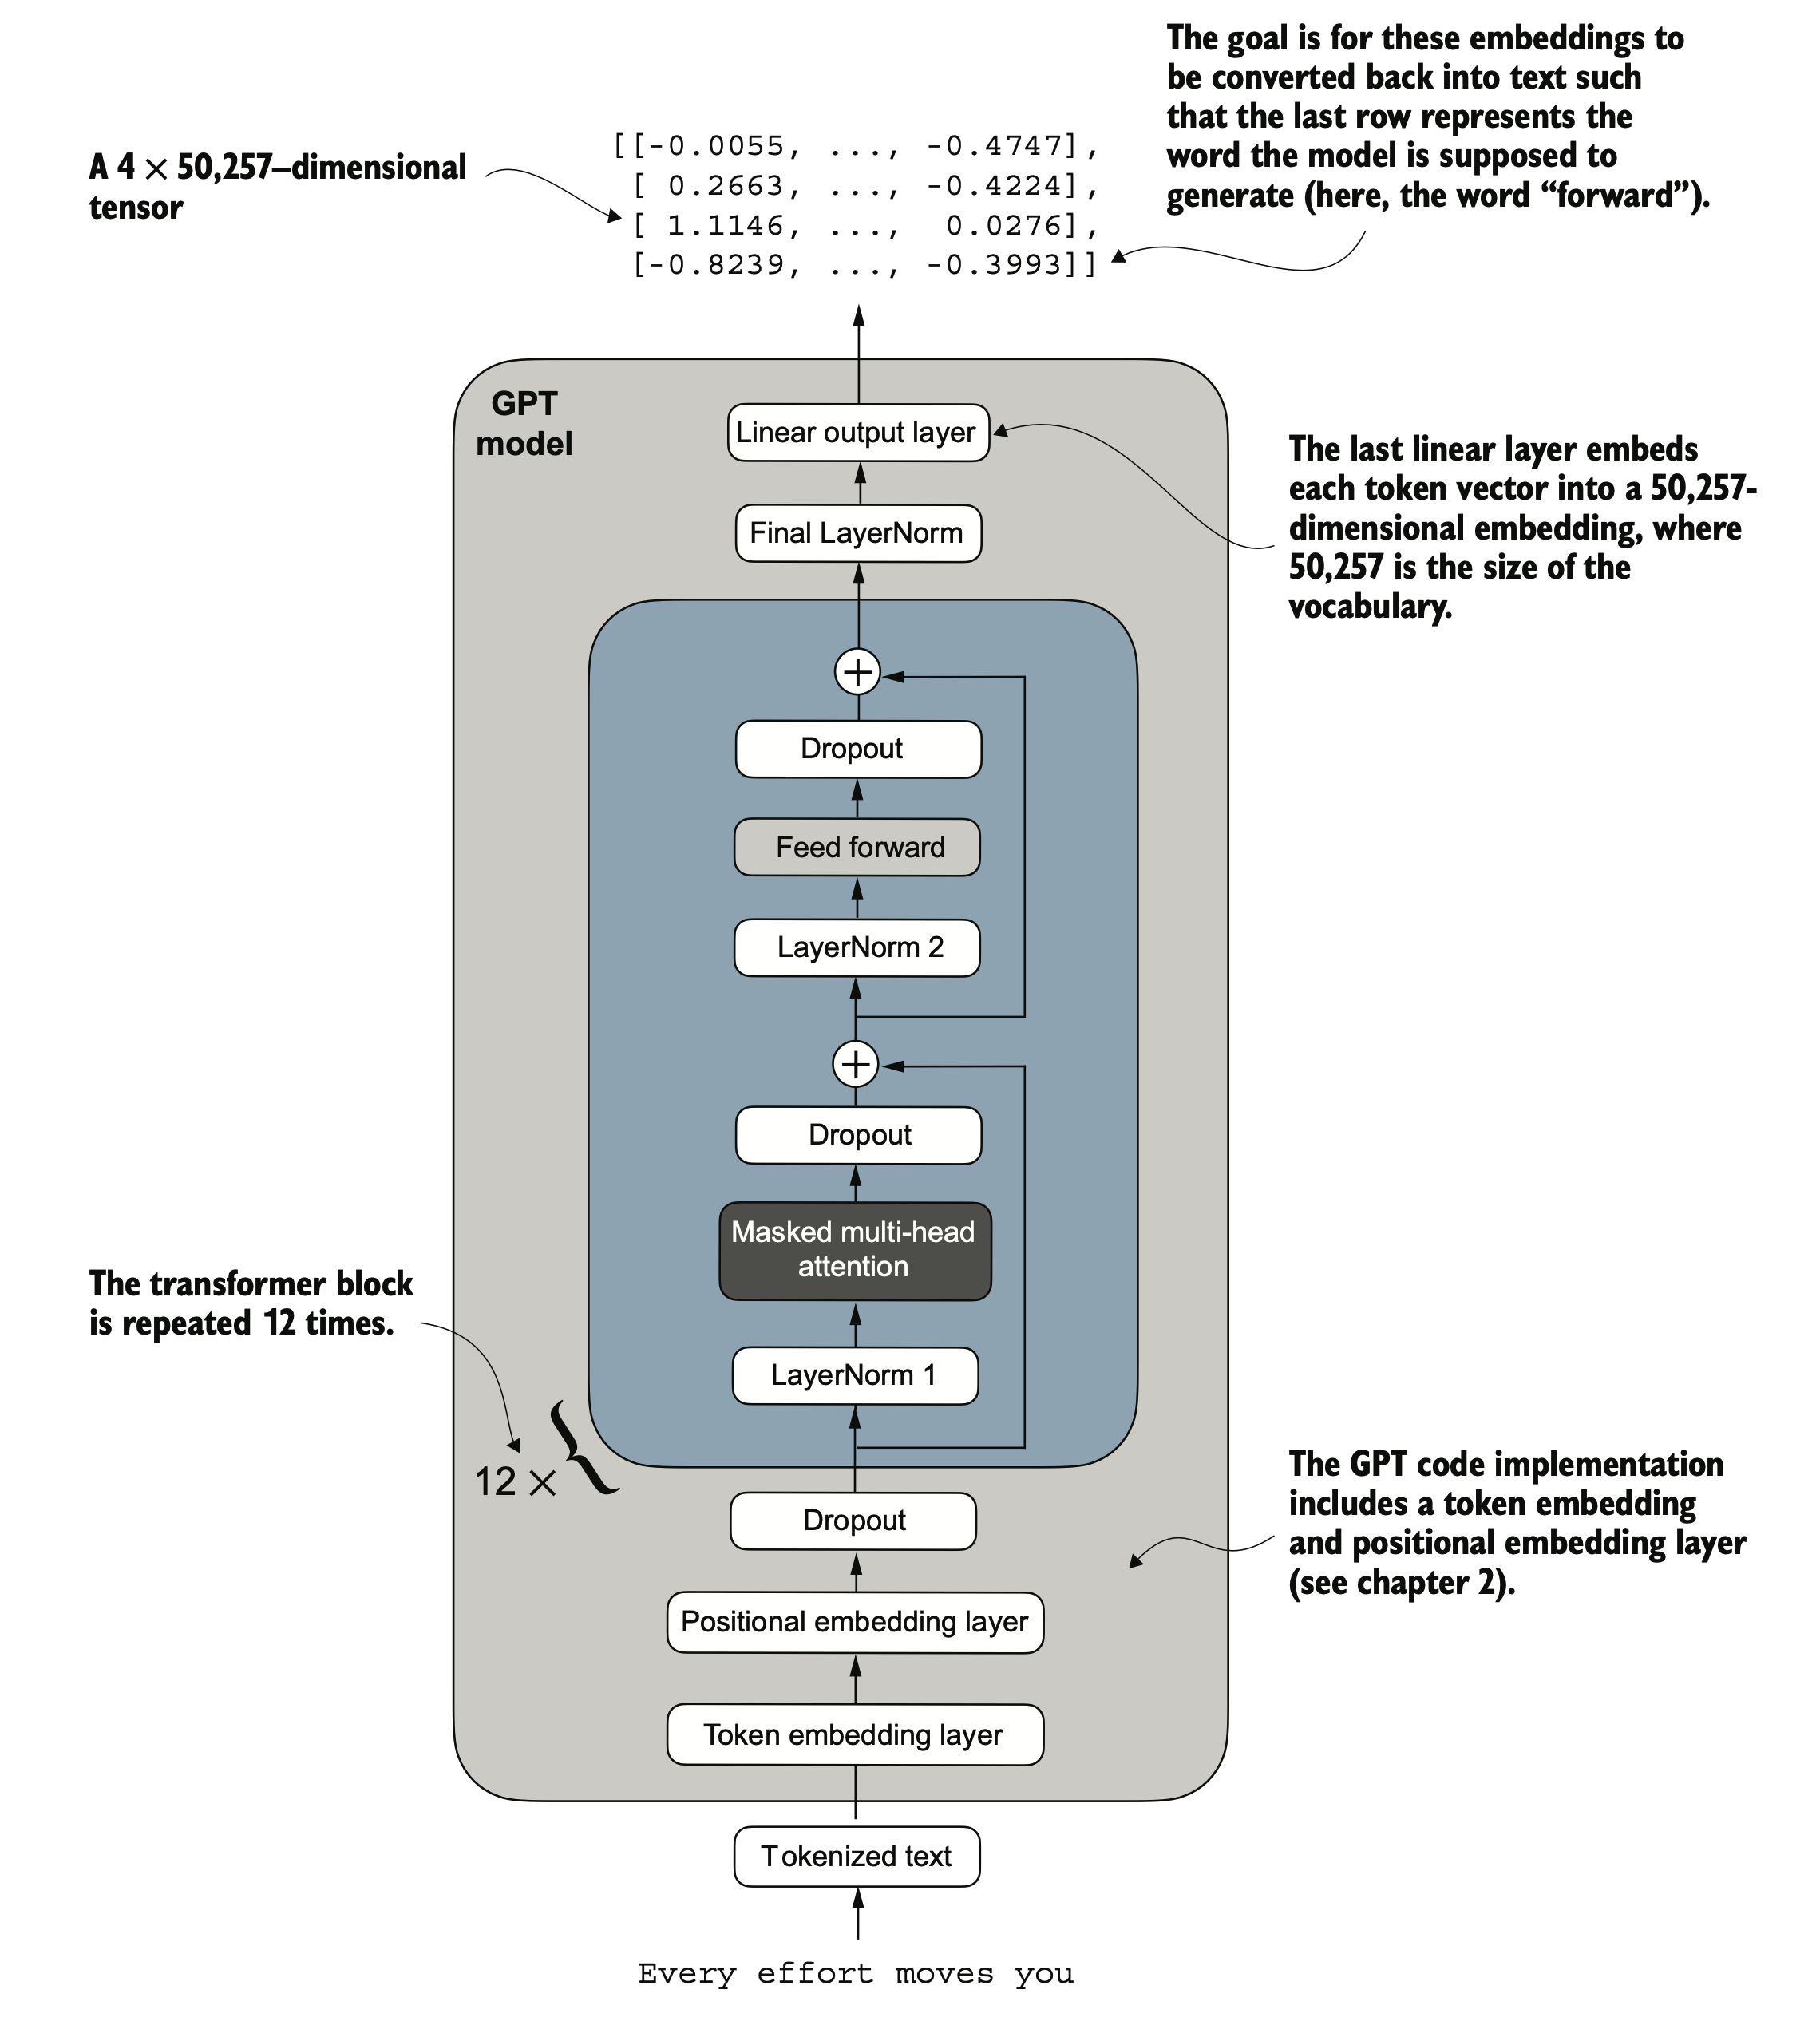

In [ ]:
class GPTModel(nn.Module):
  def __init__(self, config):
    super().__init__()
    self.config = config
    self.tok_emb = nn.Embedding(config["vocab_size"], config["emb_dim"])
    self.pos_emb = nn.Embedding(config["context_length"], config["emb_dim"])
    self.drop = nn.Dropout(config["drop_rate"])
    self.trf_blocks = nn.Sequential(*[TransformerBlock(config) for _ in range(config["n_layers"])])
    self.final_norm = LayerNorm(config["emb_dim"])
    self.out_head = nn.Linear(config["emb_dim"], config["vocab_size"], bias=False)

  def forward(self, x):
    bs, seq_len = x.shape
    tok_emb = self.tok_emb(x)
    pos_emb = self.pos_emb(torch.arange(seq_len, device=x.device))
    x = tok_emb + pos_emb
    x = self.drop(x)
    x = self.trf_blocks(x)
    x = self.final_norm(x)
    logits = self.out_head(x)
    # print(f"{logits.shape=}")
    return logits


## Weight Typing

We can see above that the model has 163M params; but GPT-2 has 124M params. Why is there difference?

This is because GPT-2 uses the same weights for the 1) input embedding, and 2) output projection. This is called **Weight Typing**.

We will enable this later. Based on the author's experience, weight typing has **negative impact** on model performance.

# Predict Text

In [ ]:
# @title A better generation fn

def generate_text_simple(model, idx, max_new_tokens, context_size):
  """Greedy decoding."""
  for i in range(max_new_tokens):
    idx_cond = idx[:, -context_size:]
    with torch.no_grad():
      logits = model(idx_cond)    # [B, N, D_IN]
    logits = logits[:, -1, :] # [B, D_IN]
    probs = nn.functional.softmax(logits, -1)  # [B, D_IN]
    idx_next = probs.argmax(-1) # [B]

    idx = torch.cat([idx, idx_next.view(-1, 1)], -1)

  return idx

# Utility for token & text conversions

In [ ]:
def text_to_token_ids(text: str, tokenizer) -> torch.Tensor:
  encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
  encoded_tensor = torch.tensor(encoded).unsqueeze(0) # [1, N]
  return encoded_tensor

def token_ids_to_text(token_ids: torch.Tensor, tokenizer) -> str:
  """Convert token ids to text.

  It assumes the token_ids has B dim == 1.
  """
  return tokenizer.decode(token_ids.squeeze().numpy())

text = "test test testtesttest"
token_ids = text_to_token_ids(text, tokenizer)
converted_back_text = token_ids_to_text(token_ids, tokenizer)
assert converted_back_text == text

# Load GPT-2 Model

The weights are originally saved in Tensorflow.

In [ ]:
!pip install tensorflow>=2.15.0 tqdm>=4.66

In [ ]:
# @title Download weights

import urllib.request
urls = [
    "https://raw.githubusercontent.com/rasbt/LLMs-from-scratch/main/ch07/01_main-chapter-code/gpt_download.py",
    "https://raw.githubusercontent.com/rasbt/LLMs-from-scratch/main/ch07/01_main-chapter-code/previous_chapters.py"
]

for url in urls:
  filename = url.split('/')[-1]
  urllib.request.urlretrieve(url, filename)

In [ ]:
from gpt_download import download_and_load_gpt2

print(f"Downloading GPT-2 model size {model_size}")
settings, params = download_and_load_gpt2(
    model_size=model_size, models_dir="gpt2"
)

checkpoint: 100%|██████████| 77.0/77.0 [00:00<00:00, 120kiB/s]
encoder.json: 100%|██████████| 1.04M/1.04M [00:01<00:00, 524kiB/s]
hparams.json: 100%|██████████| 90.0/90.0 [00:00<00:00, 153kiB/s]
model.ckpt.data-00000-of-00001: 100%|██████████| 498M/498M [02:31<00:00, 3.29MiB/s]
model.ckpt.index: 100%|██████████| 5.21k/5.21k [00:00<00:00, 8.86MiB/s]
model.ckpt.meta: 100%|██████████| 471k/471k [00:01<00:00, 396kiB/s]
vocab.bpe: 100%|██████████| 456k/456k [00:01<00:00, 382kiB/s]


In [ ]:
# @title Inspect the downloaded weights

import numpy as np

print(f"LLM architecture settings: {settings}")

print(f"Parameter dict (containing the actual weight tensors) keys: {params.keys()}")

for k, v in params.items():
  # print(f"{type(v)=}")
  if isinstance(v, np.ndarray):
    print(f"{k}: {v.shape}")
  else:
    print(f"{k}: {len(v)}")
    # print(f"{v=}")

LLM architecture settings: {'n_vocab': 50257, 'n_ctx': 1024, 'n_embd': 768, 'n_head': 12, 'n_layer': 12}
Parameter dict (containing the actual weight tensors) keys: dict_keys(['blocks', 'b', 'g', 'wpe', 'wte'])
blocks: 12
b: (768,)
g: (768,)
wpe: (1024, 768)
wte: (50257, 768)


In [ ]:
# @title Initialize the model

print(f"Initiating GPT-2 for config: {BASE_CONFIG}")

gpt = GPTModel(BASE_CONFIG)
gpt.eval()

Initiating GPT-2 for config: {'vocab_size': 50257, 'context_length': 1024, 'drop_rate': 0.1, 'qkv_bias': True, 'emb_dim': 768, 'n_layers': 12, 'n_heads': 12}


GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (mha): MultiHeadAttention(
        (wk): Linear(in_features=768, out_features=768, bias=True)
        (wq): Linear(in_features=768, out_features=768, bias=True)
        (wv): Linear(in_features=768, out_features=768, bias=True)
        (droput): Dropout(p=0.1, inplace=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
      )
      (ffn): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (mha): MultiHeadAttention(
        

In [ ]:
def assign(left, right):
  if left.shape != right.shape:
    raise ValueError(f"Shape mismatch: {left.shape} != {right.shape}")
  return torch.nn.Parameter(torch.tensor(right))

In [ ]:
def load_weights_into_gpt(gpt, params):
  gpt.pos_emb.weight = assign(gpt.pos_emb.weight, params["wpe"])
  gpt.tok_emb.weight = assign(gpt.tok_emb.weight, params["wte"])

  for b in range(len(params["blocks"])):
    q_w, k_w, v_w = np.split(
        (params["blocks"][b]["attn"]["c_attn"])["w"], 3, axis=-1)
    gpt.trf_blocks[b].mha.wq.weight = assign(
        gpt.trf_blocks[b].mha.wq.weight, q_w.T)
    gpt.trf_blocks[b].mha.wk.weight = assign(
        gpt.trf_blocks[b].mha.wk.weight, k_w.T)
    gpt.trf_blocks[b].mha.wv.weight = assign(
        gpt.trf_blocks[b].mha.wv.weight, v_w.T)
    q_b, k_b, v_b = np.split(
        (params["blocks"][b]["attn"]["c_attn"])["b"], 3, axis=-1)
    gpt.trf_blocks[b].mha.wq.bias = assign(
        gpt.trf_blocks[b].mha.wq.bias, q_b)
    gpt.trf_blocks[b].mha.wk.bias = assign(
        gpt.trf_blocks[b].mha.wk.bias, k_b)
    gpt.trf_blocks[b].mha.wv.bias = assign(
        gpt.trf_blocks[b].mha.wv.bias, v_b)

    gpt.trf_blocks[b].mha.out_proj.weight = assign(
        gpt.trf_blocks[b].mha.out_proj.weight,
        params["blocks"][b]["attn"]["c_proj"]["w"].T)
    gpt.trf_blocks[b].mha.out_proj.bias = assign(
        gpt.trf_blocks[b].mha.out_proj.bias,
        params["blocks"][b]["attn"]["c_proj"]["b"])

    gpt.trf_blocks[b].ffn.layers[0].weight = assign(
        gpt.trf_blocks[b].ffn.layers[0].weight,
        params["blocks"][b]["mlp"]["c_fc"]["w"].T)
    gpt.trf_blocks[b].ffn.layers[0].bias = assign(
        gpt.trf_blocks[b].ffn.layers[0].bias,
        params["blocks"][b]["mlp"]["c_fc"]["b"])
    gpt.trf_blocks[b].ffn.layers[2].weight = assign(
        gpt.trf_blocks[b].ffn.layers[2].weight,
        params["blocks"][b]["mlp"]["c_proj"]["w"].T)
    gpt.trf_blocks[b].ffn.layers[2].bias = assign(
        gpt.trf_blocks[b].ffn.layers[2].bias,
        params["blocks"][b]["mlp"]["c_proj"]["b"])

    gpt.trf_blocks[b].norm1.scale = assign(
        gpt.trf_blocks[b].norm1.scale,
        params["blocks"][b]["ln_1"]["g"])
    gpt.trf_blocks[b].norm1.shift = assign(
        gpt.trf_blocks[b].norm1.shift,
        params["blocks"][b]["ln_1"]["b"])
    gpt.trf_blocks[b].norm2.scale = assign(
        gpt.trf_blocks[b].norm2.scale,
        params["blocks"][b]["ln_2"]["g"])
    gpt.trf_blocks[b].norm2.shift = assign(
        gpt.trf_blocks[b].norm2.shift,
        params["blocks"][b]["ln_2"]["b"])

  gpt.final_norm.scale = assign(gpt.final_norm.scale, params["g"])
  gpt.final_norm.shift = assign(gpt.final_norm.shift, params["b"])
  gpt.out_head.weight = assign(gpt.out_head.weight, params["wte"])

load_weights_into_gpt(gpt, params)
gpt.to(device)

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (mha): MultiHeadAttention(
        (wk): Linear(in_features=768, out_features=768, bias=True)
        (wq): Linear(in_features=768, out_features=768, bias=True)
        (wv): Linear(in_features=768, out_features=768, bias=True)
        (droput): Dropout(p=0.1, inplace=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
      )
      (ffn): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (mha): MultiHeadAttention(
        

# Decoding Strategies

## Temperature Scaling

1. It applies a “temperature” on each token’s probability. This is done by a) dividing the temperature on each token’s logits, 2) then using softmax to compute the probability.

  - When T==1, no scaling - equivalent as directly doing step 2.
  - When T > 1, the step 2 distribution is more uniform.
  - When T < 1, the step 2 distribution is more biased on high probability.

2. This is similar to the ATTN block dividing the attention softmax by sqrt(D_K)
Then sample the token based on the corresponding probability (torch.multimonial())



temperature=0.1, counts=[('forward', 99), ('toward', 1)]
temperature=0.5, counts=[('forward', 64), ('toward', 34), ('closer', 2)]
temperature=1, counts=[('forward', 56), ('toward', 38), ('closer', 5), ('you', 1)]
temperature=5, counts=[('forward', 26), ('toward', 25), ('closer', 15), ('inches', 9), ('every', 7), ('you', 7), ('pizza', 5), ('effort', 3), ('moves', 3)]
temperature=10, counts=[('forward', 21), ('toward', 20), ('you', 13), ('closer', 11), ('every', 10), ('moves', 8), ('effort', 8), ('pizza', 6), ('inches', 3)]
temperature=20, counts=[('forward', 19), ('you', 16), ('inches', 13), ('toward', 12), ('effort', 12), ('closer', 12), ('pizza', 7), ('every', 7), ('moves', 2)]


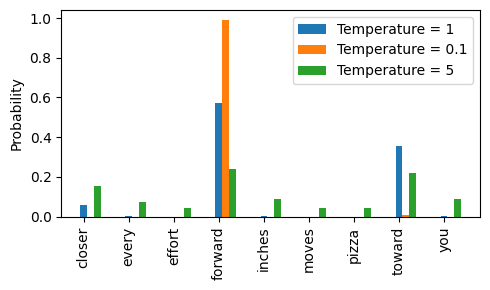

In [ ]:
# @title simple test

import copy

vocab = {
    "closer": 0,
    "every": 1,
    "effort": 2,
    "forward": 3,
    "inches": 4,
    "moves": 5,
    "pizza": 6,
    "toward": 7,
    "you": 8,
}

inverse_vocab = {v: k for k, v in vocab.items()}

next_token_logits = torch.tensor(
    [4.51, 0.89, -1.90, 6.75, 1.63, -1.62, -1.89, 6.28, 1.79]
)
assert len(next_token_logits) == len(vocab)

def softmax_with_temperature(logits, temperature):
  logits = copy.deepcopy(logits)
  if temperature:
    assert temperature > 0, f"{temperature} MUST > 0"
    logits /= temperature
  return nn.functional.softmax(logits, dim=-1)

def sample_n_times(next_token_logits, n, temperature):
  counts = {}
  for _ in range(n):
    probas = softmax_with_temperature(next_token_logits, temperature)
    next_token_id = probas.multinomial(num_samples=1).item()
    next_text = inverse_vocab[next_token_id]
    if next_text in counts:
      counts[next_text] += 1
    else:
      counts[next_text] = 1
  return sorted([(k, v) for k, v in counts.items()], key=lambda x: x[1], reverse=True)

# When temp increases, it expects a more uniformed distribution.
for temperature in (0.1, 0.5, 1, 5, 10, 20):
  counts = sample_n_times(next_token_logits, 100, temperature)
  print(f"{temperature=}, {counts=}")

# Plot distribution @ different temp
temperatures = [1, 0.1, 5]
scaled_probas = [softmax_with_temperature(next_token_logits, T)
for T in temperatures]
x = torch.arange(len(vocab))
bar_width = 0.15
fig, ax = plt.subplots(figsize=(5, 3))
for i, T in enumerate(temperatures):
  rects = ax.bar(x + i * bar_width, scaled_probas[i], bar_width, label=f'Temperature = {T}')
ax.set_ylabel('Probability')
ax.set_xticks(x)
ax.set_xticklabels(vocab.keys(), rotation=90)
ax.legend()
plt.tight_layout()
plt.show()

## Top-K

When sampling, only sample among the top-k results. This helps to **avoid the very non-sense tokens** to be sampled.

It can be used together with the **temperature scaling**.

In [ ]:
# @title simple test

def sample_n_times(next_token_logits, n, temperature, k):
  counts = {}
  for _ in range(n):
    top_logits, top_pos = torch.topk(next_token_logits, k)  # [B, K]
    top_k_logits = torch.where(
        condition=next_token_logits < top_logits[-1],
        input=torch.tensor(float('-inf')),
        other=next_token_logits
    )

    probas = softmax_with_temperature(next_token_logits, temperature)
    next_token_id = probas.multinomial(num_samples=1).item()
    next_text = inverse_vocab[next_token_id]
    if next_text in counts:
      counts[next_text] += 1
    else:
      counts[next_text] = 1
  return sorted([(k, v) for k, v in counts.items()], key=lambda x: x[1], reverse=True)

# When temp increases, it expects a more uniformed distribution.
for temperature in (0.1, 0.5, 1, 5, 10, 20):
  counts = sample_n_times(next_token_logits, 100, temperature, k=3)
  print(f"{temperature=}, {counts=}")

temperature=0.1, counts=[('forward', 99), ('toward', 1)]
temperature=0.5, counts=[('forward', 72), ('toward', 28)]
temperature=1, counts=[('forward', 59), ('toward', 33), ('closer', 8)]
temperature=5, counts=[('forward', 22), ('toward', 22), ('closer', 15), ('inches', 9), ('you', 9), ('every', 9), ('moves', 5), ('effort', 5), ('pizza', 4)]
temperature=10, counts=[('forward', 20), ('toward', 16), ('inches', 13), ('you', 12), ('effort', 11), ('moves', 8), ('pizza', 8), ('closer', 7), ('every', 5)]
temperature=20, counts=[('closer', 15), ('inches', 13), ('toward', 13), ('pizza', 13), ('forward', 11), ('every', 11), ('moves', 9), ('you', 9), ('effort', 6)]


## Combine temperature scaling and top-k

In [ ]:
def generate(
    model, idx, max_new_tokens, context_size,
    temperature: float, top_k=1, eos_id=None) -> torch.Tensor:
  """Combined temperature scaling + top-k decoding."""
  model.eval()
  for i in range(max_new_tokens):
    idx_cond = idx[:, -context_size:]
    with torch.no_grad():
      logits = model(idx_cond)    # [B, N, D_IN]
    logits = logits[:, -1, :] # [B, D_IN]

    # Top-k
    top_logits, top_pos = torch.topk(logits, top_k, dim=-1)  # [B, K]
    threshold = top_logits[:, -1].unsqueeze(dim=1)          # [B, 1]
    top_k_logits = torch.where(
        condition=(logits - threshold < 0),
        input=torch.tensor(float('-inf')),
        other=logits
    )

    # Temperature scaling
    probs = softmax_with_temperature(top_k_logits, temperature) # [B, D_IN]

    idx_next = probs.multinomial(num_samples=1) # [B, 1]

    idx = torch.cat([idx, idx_next.view(-1, 1)], -1)  # [B, D_IN + max_new_tokens]
    if eos_id and idx_next == eos_id:
      break

  model.train()
  return idx


In [ ]:
# @title Test
torch.manual_seed(123)

idx = text_to_token_ids("Is Texas in USA?", tokenizer).to(device)
print(f"{idx.shape=}")
for _ in range(5):
  print("=" * 80)

  out = generate(
      gpt,
      idx,
      max_new_tokens=25,
      context_size=BASE_CONFIG["context_length"],
      temperature=1.5,
      top_k=50)

  print(token_ids_to_text(out[0, :].to('cpu'), tokenizer))


idx.shape=torch.Size([1, 5])
Is Texas in USA?

A lot can happen because of the nature of this world of yours. You have a very small number (no one
Is Texas in USA?

What do u know on why Texas has so many athletes like DeLaHoya, Taveras is only one
Is Texas in USA?

It's pretty good news. Yes it's been bad there, but all I ask, is for Dallas Mavericks guard
Is Texas in USA? Click here If you have questions please refer to the article below from The Texas Observer. The Texas Sun also notes that "as
Is Texas in USA? Or is America an independent country, and when you live your nation becomes yours, right? Is it good we have such laws


In [ ]:
# @title Another test

import copy
from tqdm import tqdm

def sample_resp(model,
                data: list[dict[str, str]] = test_data,
                n_examples: int = 3) -> list[dict[str, str]]:
  torch.manual_seed(123)

  n_examples = min(n_examples, len(data))
  ret = copy.deepcopy(data[:n_examples])


  for entry in tqdm(ret):
    text = format_input(entry, include_resp=False)
    correct_resp = entry["output"]
    tokens = text_to_token_ids(text, tokenizer).to(device)

    out = generate(
        model,
        tokens,
        max_new_tokens=100,
        context_size=BASE_CONFIG["context_length"],
        temperature=0.0,
        top_k=50,
        eos_id=50256)

    out_text = token_ids_to_text(out[0, :].to('cpu'), tokenizer)[len(text):].replace("### Response:", "").replace("<|endoftext|>", "").strip()
    entry["model_response"] = out_text
  return ret

def visualize_sampled_resp(data: list[dict[str, str]]):
  for entry in data:
    print("=" * 80)
    print("[ Input ]")
    print(format_input(entry, include_resp=False))
    print("[ Output ]")
    print(entry["model_response"])
    print("\n[ Correct Output ]")
    print(entry["output"])

samples = sample_resp(gpt)
visualize_sampled_resp(samples)


100%|██████████| 3/3 [00:04<00:00,  1.61s/it]

[ Input ]
Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Rewrite the sentence using a simile.

### Input:
The car is very fast.

[ Output ]
Yes please (and I'm not sure what you want).

### Code (no errors):

The car continues on its journey.



Good, you now have the car.

### Code (no errors):

The car is slow.



Good, you now have the car.

### Code (no errors):

The car is slow.

[ Correct Output ]
The car is as fast as lightning.
[ Input ]
Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
What type of cloud is typically associated with thunderstorms?

[ Output ]
Satellite Observations (SSO) on high resolution data sets, ranging from 1 km to 100 km over satellite frequency.

### Instruction:

What type of cloud is typically associated with storms?

Vengance (Gravitational) hurricanes, small earthquakes, and tornados.

### Instructio

# Loss metrics

## Quick check loss

In [ ]:
torch.manual_seed(123)

for it in train_loader:
  input, target = it
  print(f"{inputs.shape=}")
  print(f"{targets.shape=}")

  with torch.no_grad():
    gpt.train()
    logits = gpt(inputs.to(device)) # [B, N, N_CLASS]
    gpt.eval()
  last_logit = logits[:, -1, :]     # [B, N_CLASS]
  last_target = target[:, -1]       # [B]

  loss = nn.functional.cross_entropy(last_logit, last_target)
  print(f"{loss=:.2f}, perplexity={torch.exp(loss)}")
  break

inputs.shape=torch.Size([8, 81])
targets.shape=torch.Size([8, 81])
loss=13.55, perplexity=770387.125


## More formal check of loss

In [ ]:
from previous_chapters import (
    calc_loss_loader,
    train_model_simple
)

torch.manual_seed(123)

with torch.no_grad():
  gpt.eval()
  train_loss = calc_loss_loader(train_loader, gpt, device, num_batches=5)
  val_loss = calc_loss_loader(val_loader, gpt, device, num_batches=5)
  gpt.train()

print(f"{train_loss=:.2f}")
print(f"{val_loss=:.2f}")

train_loss=4.24
val_loss=4.15


# Train

## Training loop

In [ ]:
import time
start_time = time.time()
torch.manual_seed(123)
optimizer = torch.optim.AdamW(
    gpt.parameters(), lr=0.00005, weight_decay=0.1
)
num_epochs = 4

train_losses, val_losses, tokens_seen = train_model_simple(
    gpt, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=5, eval_iter=5,
    start_context=format_input(val_data[0]), tokenizer=tokenizer
)

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step 000000): Train loss 3.354, Val loss 3.292
Ep 1 (Step 000005): Train loss 1.836, Val loss 1.836
Ep 1 (Step 000010): Train loss 1.195, Val loss 1.224
Ep 1 (Step 000015): Train loss 1.080, Val loss 1.170
Ep 1 (Step 000020): Train loss 1.066, Val loss 1.032
Ep 1 (Step 000025): Train loss 0.954, Val loss 1.077
Ep 1 (Step 000030): Train loss 0.943, Val loss 1.009
Ep 1 (Step 000035): Train loss 0.940, Val loss 1.022
Ep 1 (Step 000040): Train loss 0.846, Val loss 0.958
Ep 1 (Step 000045): Train loss 0.985, Val loss 0.898
Ep 1 (Step 000050): Train loss 0.913, Val loss 0.908
Ep 1 (Step 000055): Train loss 0.814, Val loss 0.934
Ep 1 (Step 000060): Train loss 0.858, Val loss 0.925
Ep 1 (Step 000065): Train loss 0.840, Val loss 0.856
Ep 1 (Step 000070): Train loss 0.760, Val loss 0.855
Ep 1 (Step 000075): Train loss 0.729, Val loss 0.887
Ep 1 (Step 000080): Train loss 0.865, Val loss 0.880
Ep 1 (Step 000085): Train loss 0.785, Val loss 0.868
Ep 1 (Step 000090): Train loss 0.733, Val loss

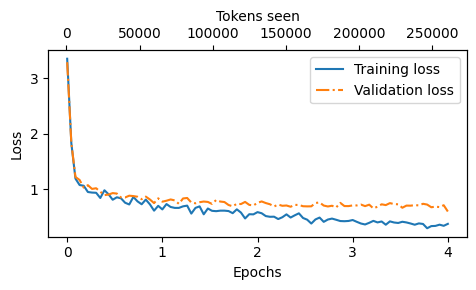

In [ ]:
from previous_chapters import plot_losses
epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

In [ ]:
# Sample and visualize results
samples = sample_resp(gpt, n_examples=10)
visualize_sampled_resp(samples)

100%|██████████| 10/10 [00:03<00:00,  3.33it/s]

[ Input ]
Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Rewrite the sentence using a simile.

### Input:
The car is very fast.

[ Output ]
The car is as fast as a bullet.

[ Correct Output ]
The car is as fast as lightning.
[ Input ]
Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
What type of cloud is typically associated with thunderstorms?

[ Output ]
The type of cloud typically associated with thunderstorms typically is an area of low precipitation.

[ Correct Output ]
The type of cloud typically associated with thunderstorms is cumulonimbus.
[ Input ]
Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Name the author of 'Pride and Prejudice'.

[ Output ]
The author is Robert Frost.

[ Correct Output ]
Jane Austen.
[ Input ]
Below is an instruction that descr

## Save loaded model weights

In [ ]:
import re

file_name = f"{re.sub(r'[ ()]', '', CHOOSE_MODEL) }-sft.pth"
torch.save(gpt.state_dict(), file_name)
print(f"Model saved as {file_name}")

Model saved as gpt2-small124M-sft.pth


# Eval

Note, the section is not finished. The original instruction uses LLAMA3 as an autorater to give rating.

## Save eval results

In [ ]:
samples = sample_resp(gpt, n_examples=10000000)

100%|██████████| 110/110 [00:33<00:00,  3.28it/s]


In [ ]:
with open("instruction-data-with-response.json", "w") as file:
  json.dump(samples, file, indent=4)

with open("instruction-data-with-response.json", "r") as file:
  loaded_samples = json.load(file)
  assert len(loaded_samples) == len(samples)
  assert loaded_samples[0] == samples[0]
  pprint.pprint(loaded_samples[0])

{'input': 'The car is very fast.',
 'instruction': 'Rewrite the sentence using a simile.',
 'model_response': 'The car is as fast as a bullet.',
 'output': 'The car is as fast as lightning.'}


## Run LLAMA3 locally

- This uses Ollama library, which is a c++ impl for inference engine.
- Note this section is not finished, since the Ollama needs a local workstation to run.

In [ ]:
# @title Install Ollama

# This is needed to detect GPU in colab env.
!sudo apt-get install -y pciutils

! curl https://ollama.ai/install.sh | sh

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
pciutils is already the newest version (1:3.7.0-6).
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 13281    0 13281    0     0  37501      0 --:--:-- --:--:-- --:--:-- 37516
>>> Cleaning up old version at /usr/local/lib/ollama
>>> Installing ollama to /usr/local
>>> Downloading Linux amd64 bundle
######################################################################## 100.0%
>>> Adding ollama user to video group...
>>> Adding current user to ollama group...
>>> Creating ollama systemd service...
>>> NVIDIA GPU installed.
>>> The Ollama API is now available at 127.0.0.1:11434.
>>> Install complete. Run "ollama" from the command line.


In [ ]:
# @title Libs

import os
import psutil
import threading
import subprocess
import requests
import json

def run_ollama_in_subprocess():
  os.environ['OLLAMA_HOST'] = '0.0.0.0:11434'
  os.environ['OLLAMA_ORIGINS'] = '*'
  subprocess.Popen(["ollama", "serve"])



def check_if_running(process_name):
  running = False
  for proc in psutil.process_iter(["name"]):
    if process_name in proc.info["name"]:
      running = True
      break
  return running



In [ ]:
# @title Run Ollama with the llama3 model

# Starting Ollama server
ollama_thread = threading.Thread(target=run_ollama_in_subprocess)
ollama_thread.start()
ollama_running = check_if_running("ollama")
if not ollama_running:
  raise RuntimeError(
      "Ollama not running. Launch ollama before proceeding."
  )

# Download model
!ollama pull llama3

In [ ]:
prompt = """
What is AI?
Can you explain in three paragraphs?
"""

def query_ollama(prompt, model: str = "llama3") -> str:
  url = 'http://localhost:11434/api/chat'
  payload = {
      "model": model,
      "temperature": 0.6,
      "stream": False,
      "seed": 123,
      "num_ctx": 2048,
      "messages": [
          {"role": "system", "content": "You are an AI assistant!"},
          {"role": "user", "content": prompt}
      ]
  }

  response = requests.post(url, json=payload)
  message_str = response.content.decode('utf-8')
  message_dict = json.loads(message_str)
  print(message_dict)
  return message_dict['message']['content']

query_ollama(prompt, model="llama3")

{'model': 'llama3', 'created_at': '2025-05-18T03:27:35.573488654Z', 'message': {'role': 'assistant', 'content': "I'd be happy to explain what AI is!\n\nArtificial Intelligence (AI) refers to the development of computer systems that can perform tasks that typically require human intelligence, such as learning, problem-solving, and decision-making. This includes abilities like recognizing patterns, understanding language, and adapting to new situations. AI systems are designed to simulate the cognitive functions of the human brain, but they don't have consciousness or self-awareness.\n\nOne way AI works is by using algorithms and data to train machine learning models. These models can analyze large amounts of information, identify trends and relationships, and make predictions or decisions based on that analysis. For example, a recommendation engine might use AI to suggest products you might like based on your past purchases and browsing history. AI can also be used for tasks like image 

"I'd be happy to explain what AI is!\n\nArtificial Intelligence (AI) refers to the development of computer systems that can perform tasks that typically require human intelligence, such as learning, problem-solving, and decision-making. This includes abilities like recognizing patterns, understanding language, and adapting to new situations. AI systems are designed to simulate the cognitive functions of the human brain, but they don't have consciousness or self-awareness.\n\nOne way AI works is by using algorithms and data to train machine learning models. These models can analyze large amounts of information, identify trends and relationships, and make predictions or decisions based on that analysis. For example, a recommendation engine might use AI to suggest products you might like based on your past purchases and browsing history. AI can also be used for tasks like image recognition, natural language processing (NLP), and speech recognition.\n\nAI has many practical applications in

In [ ]:
loaded_samples[0]

{'instruction': 'Rewrite the sentence using a simile.',
 'input': 'The car is very fast.',
 'output': 'The car is as fast as lightning.',
 'model_response': 'The car is as fast as a bullet.'}

In [ ]:
# @title Test autorater

for entry in loaded_samples[:3]:
  prompt = (
      f"Given the input `{format_input(entry)}` "
      f"and correct output `{entry['output']}`, "
      f"score the model response `{entry['model_response']}`"
      f" on a scale from 0 to 100, where 100 is the best score. "
  )
  print("\nDataset response:")
  print(">>", entry['output'])
  print("\nModel response:")
  print(">>", entry["model_response"])
  print("\nScore:")
  print(">>", query_ollama(prompt))
  print("\n-------------------------")


Dataset response:
>> The car is as fast as lightning.

Model response:
>> The car is as fast as a bullet.

Score:
{'model': 'llama3', 'created_at': '2025-05-18T03:27:38.797391169Z', 'message': {'role': 'assistant', 'content': 'I\'d rate the model\'s response "The car is as fast as a bullet." as 90 out of 100.\n\nHere\'s why:\n\n* The original instruction was to rewrite the sentence using a simile.\n* A simile is a figure of speech that compares two different things using "like" or "as."\n* "The car is as fast as lightning" meets this criteria perfectly, as it uses the phrase "as fast as" to compare the car\'s speed to lightning\'s speed.\n* While "a bullet" could be considered a simile in this context, it\'s not as precise or common as using "as fast as" with a more vivid comparison like "lightning."'}, 'done_reason': 'stop', 'done': True, 'total_duration': 3209361823, 'load_duration': 23471601, 'prompt_eval_count': 122, 'prompt_eval_duration': 11086769, 'eval_count': 142, 'eval_durat

In [ ]:
def generate_model_scores(json_data, json_key, model="llama3"):
  scores = []
  for entry in tqdm(json_data, desc="Scoring entries"):
    prompt = (
        f"Given the input `{format_input(entry)}` "
        f"and correct output `{entry['output']}`, "
        f"score the model response `{entry[json_key]}`"
        f" on a scale from 0 to 100, where 100 is the best score. "
        f"Respond with the integer number only."
    )
    try:
      score = query_ollama(prompt, model)
      scores.append(int(score))
    except ValueError:
      print(f"Could not convert score: {score}")
      continue
  return scores

In [ ]:
scores = generate_model_scores(loaded_samples, "model_response")
print(f"Number of scores: {len(scores)} of {len(test_data)}")
print(f"Average score: {sum(scores)/len(scores):.2f}\n")

Scoring entries:   2%|▏         | 2/110 [00:00<00:10, 10.78it/s]

{'model': 'llama3', 'created_at': '2025-05-18T03:27:44.018642962Z', 'message': {'role': 'assistant', 'content': '97'}, 'done_reason': 'stop', 'done': True, 'total_duration': 88516714, 'load_duration': 21964223, 'prompt_eval_count': 128, 'prompt_eval_duration': 10449434, 'eval_count': 2, 'eval_duration': 55150547}
{'model': 'llama3', 'created_at': '2025-05-18T03:27:44.113172015Z', 'message': {'role': 'assistant', 'content': '20'}, 'done_reason': 'stop', 'done': True, 'total_duration': 91967082, 'load_duration': 22735305, 'prompt_eval_count': 143, 'prompt_eval_duration': 10700132, 'eval_count': 2, 'eval_duration': 57507549}
{'model': 'llama3', 'created_at': '2025-05-18T03:27:44.200988767Z', 'message': {'role': 'assistant', 'content': '12'}, 'done_reason': 'stop', 'done': True, 'total_duration': 84518784, 'load_duration': 21821534, 'prompt_eval_count': 111, 'prompt_eval_duration': 9210480, 'eval_count': 2, 'eval_duration': 52630655}


Scoring entries:   4%|▎         | 4/110 [00:00<00:09, 11.12it/s]

{'model': 'llama3', 'created_at': '2025-05-18T03:27:44.288856747Z', 'message': {'role': 'assistant', 'content': '76'}, 'done_reason': 'stop', 'done': True, 'total_duration': 85474983, 'load_duration': 22365726, 'prompt_eval_count': 117, 'prompt_eval_duration': 9664649, 'eval_count': 2, 'eval_duration': 52551849}
{'model': 'llama3', 'created_at': '2025-05-18T03:27:44.382669745Z', 'message': {'role': 'assistant', 'content': '20'}, 'done_reason': 'stop', 'done': True, 'total_duration': 90988046, 'load_duration': 21878864, 'prompt_eval_count': 141, 'prompt_eval_duration': 10519978, 'eval_count': 2, 'eval_duration': 57672761}


Scoring entries:   5%|▌         | 6/110 [00:00<00:09, 11.00it/s]

{'model': 'llama3', 'created_at': '2025-05-18T03:27:44.473202181Z', 'message': {'role': 'assistant', 'content': '20'}, 'done_reason': 'stop', 'done': True, 'total_duration': 88573567, 'load_duration': 22740071, 'prompt_eval_count': 129, 'prompt_eval_duration': 10712213, 'eval_count': 2, 'eval_duration': 54225738}


Scoring entries:   7%|▋         | 8/110 [00:00<00:09, 10.90it/s]

{'model': 'llama3', 'created_at': '2025-05-18T03:27:44.569982753Z', 'message': {'role': 'assistant', 'content': '80'}, 'done_reason': 'stop', 'done': True, 'total_duration': 93862292, 'load_duration': 23088877, 'prompt_eval_count': 138, 'prompt_eval_duration': 10347137, 'eval_count': 2, 'eval_duration': 59555835}
{'model': 'llama3', 'created_at': '2025-05-18T03:27:44.659281717Z', 'message': {'role': 'assistant', 'content': '0'}, 'done_reason': 'stop', 'done': True, 'total_duration': 87140965, 'load_duration': 22170460, 'prompt_eval_count': 126, 'prompt_eval_duration': 9498974, 'eval_count': 2, 'eval_duration': 54595079}
{'model': 'llama3', 'created_at': '2025-05-18T03:27:44.753870561Z', 'message': {'role': 'assistant', 'content': '4'}, 'done_reason': 'stop', 'done': True, 'total_duration': 91444831, 'load_duration': 21625708, 'prompt_eval_count': 138, 'prompt_eval_duration': 10496775, 'eval_count': 2, 'eval_duration': 58382692}


Scoring entries:   9%|▉         | 10/110 [00:00<00:09, 10.72it/s]

{'model': 'llama3', 'created_at': '2025-05-18T03:27:44.851032989Z', 'message': {'role': 'assistant', 'content': '98'}, 'done_reason': 'stop', 'done': True, 'total_duration': 94953368, 'load_duration': 23987113, 'prompt_eval_count': 146, 'prompt_eval_duration': 10556209, 'eval_count': 2, 'eval_duration': 59546415}
{'model': 'llama3', 'created_at': '2025-05-18T03:27:44.938453342Z', 'message': {'role': 'assistant', 'content': '20'}, 'done_reason': 'stop', 'done': True, 'total_duration': 84507348, 'load_duration': 21676195, 'prompt_eval_count': 115, 'prompt_eval_duration': 9017954, 'eval_count': 2, 'eval_duration': 53014659}


Scoring entries:  11%|█         | 12/110 [00:01<00:09, 10.88it/s]

{'model': 'llama3', 'created_at': '2025-05-18T03:27:45.029700001Z', 'message': {'role': 'assistant', 'content': '20'}, 'done_reason': 'stop', 'done': True, 'total_duration': 89282476, 'load_duration': 22443911, 'prompt_eval_count': 129, 'prompt_eval_duration': 10559856, 'eval_count': 2, 'eval_duration': 55443552}


Scoring entries:  13%|█▎        | 14/110 [00:01<00:08, 11.02it/s]

{'model': 'llama3', 'created_at': '2025-05-18T03:27:45.120512699Z', 'message': {'role': 'assistant', 'content': '100'}, 'done_reason': 'stop', 'done': True, 'total_duration': 87832874, 'load_duration': 21912892, 'prompt_eval_count': 124, 'prompt_eval_duration': 9673714, 'eval_count': 2, 'eval_duration': 55357247}
{'model': 'llama3', 'created_at': '2025-05-18T03:27:45.206413569Z', 'message': {'role': 'assistant', 'content': '4'}, 'done_reason': 'stop', 'done': True, 'total_duration': 83363890, 'load_duration': 21759394, 'prompt_eval_count': 108, 'prompt_eval_duration': 8726645, 'eval_count': 2, 'eval_duration': 52005934}
{'model': 'llama3', 'created_at': '2025-05-18T03:27:45.317654154Z', 'message': {'role': 'assistant', 'content': '4'}, 'done_reason': 'stop', 'done': True, 'total_duration': 108220012, 'load_duration': 21590109, 'prompt_eval_count': 194, 'prompt_eval_duration': 14147348, 'eval_count': 2, 'eval_duration': 71506238}


Scoring entries:  15%|█▍        | 16/110 [00:01<00:08, 10.57it/s]

{'model': 'llama3', 'created_at': '2025-05-18T03:27:45.411972069Z', 'message': {'role': 'assistant', 'content': '20'}, 'done_reason': 'stop', 'done': True, 'total_duration': 92063314, 'load_duration': 21543899, 'prompt_eval_count': 144, 'prompt_eval_duration': 10608459, 'eval_count': 2, 'eval_duration': 59028461}
{'model': 'llama3', 'created_at': '2025-05-18T03:27:45.49920178Z', 'message': {'role': 'assistant', 'content': '100'}, 'done_reason': 'stop', 'done': True, 'total_duration': 84179951, 'load_duration': 21757681, 'prompt_eval_count': 116, 'prompt_eval_duration': 8923262, 'eval_count': 2, 'eval_duration': 52519023}


Scoring entries:  16%|█▋        | 18/110 [00:01<00:08, 10.83it/s]

{'model': 'llama3', 'created_at': '2025-05-18T03:27:45.586654099Z', 'message': {'role': 'assistant', 'content': '65'}, 'done_reason': 'stop', 'done': True, 'total_duration': 85411016, 'load_duration': 21665477, 'prompt_eval_count': 122, 'prompt_eval_duration': 8977425, 'eval_count': 2, 'eval_duration': 53927655}


Scoring entries:  18%|█▊        | 20/110 [00:01<00:08, 10.84it/s]

{'model': 'llama3', 'created_at': '2025-05-18T03:27:45.67996352Z', 'message': {'role': 'assistant', 'content': '4'}, 'done_reason': 'stop', 'done': True, 'total_duration': 90160346, 'load_duration': 22591784, 'prompt_eval_count': 129, 'prompt_eval_duration': 9991933, 'eval_count': 2, 'eval_duration': 56577097}
{'model': 'llama3', 'created_at': '2025-05-18T03:27:45.77085835Z', 'message': {'role': 'assistant', 'content': '4'}, 'done_reason': 'stop', 'done': True, 'total_duration': 88390962, 'load_duration': 21984583, 'prompt_eval_count': 134, 'prompt_eval_duration': 10744611, 'eval_count': 2, 'eval_duration': 54694185}
{'model': 'llama3', 'created_at': '2025-05-18T03:27:45.862752483Z', 'message': {'role': 'assistant', 'content': '80'}, 'done_reason': 'stop', 'done': True, 'total_duration': 88577673, 'load_duration': 22299702, 'prompt_eval_count': 131, 'prompt_eval_duration': 9903848, 'eval_count': 2, 'eval_duration': 55518984}


Scoring entries:  20%|██        | 22/110 [00:02<00:08, 10.89it/s]

{'model': 'llama3', 'created_at': '2025-05-18T03:27:45.952498783Z', 'message': {'role': 'assistant', 'content': '4'}, 'done_reason': 'stop', 'done': True, 'total_duration': 87347604, 'load_duration': 21716594, 'prompt_eval_count': 124, 'prompt_eval_duration': 9567169, 'eval_count': 2, 'eval_duration': 55243657}
{'model': 'llama3', 'created_at': '2025-05-18T03:27:46.043660276Z', 'message': {'role': 'assistant', 'content': '40'}, 'done_reason': 'stop', 'done': True, 'total_duration': 88368039, 'load_duration': 21637533, 'prompt_eval_count': 128, 'prompt_eval_duration': 9760419, 'eval_count': 2, 'eval_duration': 56119513}


Scoring entries:  22%|██▏       | 24/110 [00:02<00:07, 10.91it/s]

{'model': 'llama3', 'created_at': '2025-05-18T03:27:46.13506137Z', 'message': {'role': 'assistant', 'content': '80'}, 'done_reason': 'stop', 'done': True, 'total_duration': 89070408, 'load_duration': 22575444, 'prompt_eval_count': 130, 'prompt_eval_duration': 9866388, 'eval_count': 2, 'eval_duration': 55709854}


Scoring entries:  24%|██▎       | 26/110 [00:02<00:07, 10.76it/s]

{'model': 'llama3', 'created_at': '2025-05-18T03:27:46.22712417Z', 'message': {'role': 'assistant', 'content': '4'}, 'done_reason': 'stop', 'done': True, 'total_duration': 89023912, 'load_duration': 21782479, 'prompt_eval_count': 132, 'prompt_eval_duration': 10352618, 'eval_count': 2, 'eval_duration': 56001977}
{'model': 'llama3', 'created_at': '2025-05-18T03:27:46.326850712Z', 'message': {'role': 'assistant', 'content': '0'}, 'done_reason': 'stop', 'done': True, 'total_duration': 97246275, 'load_duration': 22734836, 'prompt_eval_count': 160, 'prompt_eval_duration': 11880100, 'eval_count': 2, 'eval_duration': 61225017}
{'model': 'llama3', 'created_at': '2025-05-18T03:27:46.418942579Z', 'message': {'role': 'assistant', 'content': '50'}, 'done_reason': 'stop', 'done': True, 'total_duration': 88660688, 'load_duration': 22058112, 'prompt_eval_count': 120, 'prompt_eval_duration': 10396095, 'eval_count': 2, 'eval_duration': 55228053}


Scoring entries:  25%|██▌       | 28/110 [00:02<00:07, 10.68it/s]

{'model': 'llama3', 'created_at': '2025-05-18T03:27:46.517247547Z', 'message': {'role': 'assistant', 'content': '20'}, 'done_reason': 'stop', 'done': True, 'total_duration': 95792740, 'load_duration': 22037110, 'prompt_eval_count': 155, 'prompt_eval_duration': 11223008, 'eval_count': 2, 'eval_duration': 61495982}
{'model': 'llama3', 'created_at': '2025-05-18T03:27:46.609715463Z', 'message': {'role': 'assistant', 'content': '100'}, 'done_reason': 'stop', 'done': True, 'total_duration': 88991933, 'load_duration': 23438805, 'prompt_eval_count': 125, 'prompt_eval_duration': 10472920, 'eval_count': 2, 'eval_duration': 54225681}


Scoring entries:  27%|██▋       | 30/110 [00:02<00:07, 10.81it/s]

{'model': 'llama3', 'created_at': '2025-05-18T03:27:46.696874597Z', 'message': {'role': 'assistant', 'content': '20'}, 'done_reason': 'stop', 'done': True, 'total_duration': 84976074, 'load_duration': 21927395, 'prompt_eval_count': 120, 'prompt_eval_duration': 9135115, 'eval_count': 2, 'eval_duration': 53109757}


Scoring entries:  29%|██▉       | 32/110 [00:02<00:07, 10.72it/s]

{'model': 'llama3', 'created_at': '2025-05-18T03:27:46.797432758Z', 'message': {'role': 'assistant', 'content': '40'}, 'done_reason': 'stop', 'done': True, 'total_duration': 96954993, 'load_duration': 31154321, 'prompt_eval_count': 126, 'prompt_eval_duration': 9737605, 'eval_count': 2, 'eval_duration': 55132296}
{'model': 'llama3', 'created_at': '2025-05-18T03:27:46.887646534Z', 'message': {'role': 'assistant', 'content': '70'}, 'done_reason': 'stop', 'done': True, 'total_duration': 87039889, 'load_duration': 21591045, 'prompt_eval_count': 122, 'prompt_eval_duration': 9466201, 'eval_count': 2, 'eval_duration': 55119516}
{'model': 'llama3', 'created_at': '2025-05-18T03:27:46.988713848Z', 'message': {'role': 'assistant', 'content': '40'}, 'done_reason': 'stop', 'done': True, 'total_duration': 97345136, 'load_duration': 22237257, 'prompt_eval_count': 162, 'prompt_eval_duration': 11728089, 'eval_count': 2, 'eval_duration': 61769698}


Scoring entries:  31%|███       | 34/110 [00:03<00:07, 10.67it/s]

{'model': 'llama3', 'created_at': '2025-05-18T03:27:47.076882159Z', 'message': {'role': 'assistant', 'content': '60'}, 'done_reason': 'stop', 'done': True, 'total_duration': 85103143, 'load_duration': 21882755, 'prompt_eval_count': 116, 'prompt_eval_duration': 9031706, 'eval_count': 2, 'eval_duration': 53334023}
{'model': 'llama3', 'created_at': '2025-05-18T03:27:47.167120377Z', 'message': {'role': 'assistant', 'content': '20'}, 'done_reason': 'stop', 'done': True, 'total_duration': 87101602, 'load_duration': 21716777, 'prompt_eval_count': 126, 'prompt_eval_duration': 9532182, 'eval_count': 2, 'eval_duration': 54934723}


Scoring entries:  33%|███▎      | 36/110 [00:03<00:06, 10.79it/s]

{'model': 'llama3', 'created_at': '2025-05-18T03:27:47.257280558Z', 'message': {'role': 'assistant', 'content': '4'}, 'done_reason': 'stop', 'done': True, 'total_duration': 88099985, 'load_duration': 21861932, 'prompt_eval_count': 131, 'prompt_eval_duration': 9738707, 'eval_count': 2, 'eval_duration': 55632505}


Scoring entries:  35%|███▍      | 38/110 [00:03<00:06, 10.83it/s]

{'model': 'llama3', 'created_at': '2025-05-18T03:27:47.349300008Z', 'message': {'role': 'assistant', 'content': '40'}, 'done_reason': 'stop', 'done': True, 'total_duration': 89124443, 'load_duration': 21809290, 'prompt_eval_count': 126, 'prompt_eval_duration': 10234461, 'eval_count': 2, 'eval_duration': 56232870}
{'model': 'llama3', 'created_at': '2025-05-18T03:27:47.440457244Z', 'message': {'role': 'assistant', 'content': '20'}, 'done_reason': 'stop', 'done': True, 'total_duration': 88865707, 'load_duration': 22256757, 'prompt_eval_count': 130, 'prompt_eval_duration': 9753282, 'eval_count': 2, 'eval_duration': 55924620}
{'model': 'llama3', 'created_at': '2025-05-18T03:27:47.531576416Z', 'message': {'role': 'assistant', 'content': '100'}, 'done_reason': 'stop', 'done': True, 'total_duration': 87548423, 'load_duration': 21976467, 'prompt_eval_count': 132, 'prompt_eval_duration': 9814425, 'eval_count': 2, 'eval_duration': 54888008}


Scoring entries:  36%|███▋      | 40/110 [00:03<00:06, 10.49it/s]

{'model': 'llama3', 'created_at': '2025-05-18T03:27:47.644501021Z', 'message': {'role': 'assistant', 'content': '4'}, 'done_reason': 'stop', 'done': True, 'total_duration': 110415256, 'load_duration': 22850738, 'prompt_eval_count': 170, 'prompt_eval_duration': 13693741, 'eval_count': 2, 'eval_duration': 72821081}


Scoring entries:  38%|███▊      | 42/110 [00:03<00:06, 10.60it/s]

{'model': 'llama3', 'created_at': '2025-05-18T03:27:47.736495478Z', 'message': {'role': 'assistant', 'content': '95'}, 'done_reason': 'stop', 'done': True, 'total_duration': 88620989, 'load_duration': 23354171, 'prompt_eval_count': 124, 'prompt_eval_duration': 9835479, 'eval_count': 2, 'eval_duration': 54541750}
{'model': 'llama3', 'created_at': '2025-05-18T03:27:47.828827329Z', 'message': {'role': 'assistant', 'content': '4'}, 'done_reason': 'stop', 'done': True, 'total_duration': 89775434, 'load_duration': 21816419, 'prompt_eval_count': 136, 'prompt_eval_duration': 9967642, 'eval_count': 2, 'eval_duration': 57066628}
{'model': 'llama3', 'created_at': '2025-05-18T03:27:47.927243909Z', 'message': {'role': 'assistant', 'content': '50'}, 'done_reason': 'stop', 'done': True, 'total_duration': 95201255, 'load_duration': 23762348, 'prompt_eval_count': 150, 'prompt_eval_duration': 10888296, 'eval_count': 2, 'eval_duration': 59601476}


Scoring entries:  40%|████      | 44/110 [00:04<00:06, 10.62it/s]

{'model': 'llama3', 'created_at': '2025-05-18T03:27:48.016040617Z', 'message': {'role': 'assistant', 'content': '91'}, 'done_reason': 'stop', 'done': True, 'total_duration': 86198448, 'load_duration': 22669414, 'prompt_eval_count': 108, 'prompt_eval_duration': 9287957, 'eval_count': 2, 'eval_duration': 53354120}
{'model': 'llama3', 'created_at': '2025-05-18T03:27:48.109689373Z', 'message': {'role': 'assistant', 'content': '72'}, 'done_reason': 'stop', 'done': True, 'total_duration': 90459210, 'load_duration': 24954918, 'prompt_eval_count': 124, 'prompt_eval_duration': 9578034, 'eval_count': 2, 'eval_duration': 54998022}


Scoring entries:  42%|████▏     | 46/110 [00:04<00:05, 10.75it/s]

{'model': 'llama3', 'created_at': '2025-05-18T03:27:48.197065809Z', 'message': {'role': 'assistant', 'content': '80'}, 'done_reason': 'stop', 'done': True, 'total_duration': 85186998, 'load_duration': 22338727, 'prompt_eval_count': 119, 'prompt_eval_duration': 9309334, 'eval_count': 2, 'eval_duration': 52533049}


Scoring entries:  44%|████▎     | 48/110 [00:04<00:05, 10.86it/s]

{'model': 'llama3', 'created_at': '2025-05-18T03:27:48.28862394Z', 'message': {'role': 'assistant', 'content': '60'}, 'done_reason': 'stop', 'done': True, 'total_duration': 88326004, 'load_duration': 22045866, 'prompt_eval_count': 132, 'prompt_eval_duration': 9873987, 'eval_count': 2, 'eval_duration': 55551071}
{'model': 'llama3', 'created_at': '2025-05-18T03:27:48.377373078Z', 'message': {'role': 'assistant', 'content': '86'}, 'done_reason': 'stop', 'done': True, 'total_duration': 86356041, 'load_duration': 21676676, 'prompt_eval_count': 123, 'prompt_eval_duration': 9584625, 'eval_count': 2, 'eval_duration': 54234615}
{'model': 'llama3', 'created_at': '2025-05-18T03:27:48.467842188Z', 'message': {'role': 'assistant', 'content': '20'}, 'done_reason': 'stop', 'done': True, 'total_duration': 87503563, 'load_duration': 21817877, 'prompt_eval_count': 128, 'prompt_eval_duration': 9533687, 'eval_count': 2, 'eval_duration': 55299886}


Scoring entries:  45%|████▌     | 50/110 [00:04<00:05, 10.97it/s]

{'model': 'llama3', 'created_at': '2025-05-18T03:27:48.554837031Z', 'message': {'role': 'assistant', 'content': '91'}, 'done_reason': 'stop', 'done': True, 'total_duration': 84847224, 'load_duration': 22523024, 'prompt_eval_count': 109, 'prompt_eval_duration': 8766638, 'eval_count': 2, 'eval_duration': 52762758}
{'model': 'llama3', 'created_at': '2025-05-18T03:27:48.645462377Z', 'message': {'role': 'assistant', 'content': '67'}, 'done_reason': 'stop', 'done': True, 'total_duration': 87505565, 'load_duration': 21701667, 'prompt_eval_count': 126, 'prompt_eval_duration': 9479534, 'eval_count': 2, 'eval_duration': 55482447}


Scoring entries:  47%|████▋     | 52/110 [00:04<00:05, 10.97it/s]

{'model': 'llama3', 'created_at': '2025-05-18T03:27:48.737123733Z', 'message': {'role': 'assistant', 'content': '80'}, 'done_reason': 'stop', 'done': True, 'total_duration': 89645608, 'load_duration': 22154235, 'prompt_eval_count': 134, 'prompt_eval_duration': 10816899, 'eval_count': 2, 'eval_duration': 55457637}
{'model': 'llama3', 'created_at': '2025-05-18T03:27:48.831563325Z', 'message': {'role': 'assistant', 'content': '20'}, 'done_reason': 'stop', 'done': True, 'total_duration': 91527955, 'load_duration': 21708269, 'prompt_eval_count': 145, 'prompt_eval_duration': 10586604, 'eval_count': 2, 'eval_duration': 58338092}


Scoring entries:  49%|████▉     | 54/110 [00:05<00:05, 10.52it/s]

{'model': 'llama3', 'created_at': '2025-05-18T03:27:48.945888225Z', 'message': {'role': 'assistant', 'content': '0'}, 'done_reason': 'stop', 'done': True, 'total_duration': 112070867, 'load_duration': 21562670, 'prompt_eval_count': 200, 'prompt_eval_duration': 15459321, 'eval_count': 2, 'eval_duration': 73530411}
{'model': 'llama3', 'created_at': '2025-05-18T03:27:49.036196159Z', 'message': {'role': 'assistant', 'content': '4'}, 'done_reason': 'stop', 'done': True, 'total_duration': 87588962, 'load_duration': 21554851, 'prompt_eval_count': 124, 'prompt_eval_duration': 9645919, 'eval_count': 2, 'eval_duration': 55472584}


Scoring entries:  51%|█████     | 56/110 [00:05<00:05, 10.32it/s]

{'model': 'llama3', 'created_at': '2025-05-18T03:27:49.147725478Z', 'message': {'role': 'assistant', 'content': '4'}, 'done_reason': 'stop', 'done': True, 'total_duration': 109418395, 'load_duration': 21473304, 'prompt_eval_count': 187, 'prompt_eval_duration': 13887255, 'eval_count': 2, 'eval_duration': 73089132}


Scoring entries:  53%|█████▎    | 58/110 [00:05<00:04, 10.48it/s]

{'model': 'llama3', 'created_at': '2025-05-18T03:27:49.242531686Z', 'message': {'role': 'assistant', 'content': '0'}, 'done_reason': 'stop', 'done': True, 'total_duration': 91781326, 'load_duration': 21603647, 'prompt_eval_count': 140, 'prompt_eval_duration': 10523735, 'eval_count': 2, 'eval_duration': 58810123}
{'model': 'llama3', 'created_at': '2025-05-18T03:27:49.332226734Z', 'message': {'role': 'assistant', 'content': '67'}, 'done_reason': 'stop', 'done': True, 'total_duration': 87312555, 'load_duration': 21559220, 'prompt_eval_count': 124, 'prompt_eval_duration': 9461928, 'eval_count': 2, 'eval_duration': 55480801}
{'model': 'llama3', 'created_at': '2025-05-18T03:27:49.420579511Z', 'message': {'role': 'assistant', 'content': '0'}, 'done_reason': 'stop', 'done': True, 'total_duration': 85569725, 'load_duration': 22325137, 'prompt_eval_count': 117, 'prompt_eval_duration': 8859256, 'eval_count': 2, 'eval_duration': 53513649}


Scoring entries:  55%|█████▍    | 60/110 [00:05<00:04, 10.66it/s]

{'model': 'llama3', 'created_at': '2025-05-18T03:27:49.511816568Z', 'message': {'role': 'assistant', 'content': '80'}, 'done_reason': 'stop', 'done': True, 'total_duration': 89141112, 'load_duration': 21862673, 'prompt_eval_count': 132, 'prompt_eval_duration': 9836876, 'eval_count': 2, 'eval_duration': 56531583}
{'model': 'llama3', 'created_at': '2025-05-18T03:27:49.599908542Z', 'message': {'role': 'assistant', 'content': '70'}, 'done_reason': 'stop', 'done': True, 'total_duration': 84881097, 'load_duration': 22342650, 'prompt_eval_count': 111, 'prompt_eval_duration': 8740784, 'eval_count': 2, 'eval_duration': 52898429}


Scoring entries:  56%|█████▋    | 62/110 [00:05<00:04, 10.83it/s]

{'model': 'llama3', 'created_at': '2025-05-18T03:27:49.689767497Z', 'message': {'role': 'assistant', 'content': '20'}, 'done_reason': 'stop', 'done': True, 'total_duration': 87902058, 'load_duration': 21512994, 'prompt_eval_count': 131, 'prompt_eval_duration': 9697348, 'eval_count': 2, 'eval_duration': 55840892}


Scoring entries:  58%|█████▊    | 64/110 [00:05<00:04, 10.88it/s]

{'model': 'llama3', 'created_at': '2025-05-18T03:27:49.781884166Z', 'message': {'role': 'assistant', 'content': '44'}, 'done_reason': 'stop', 'done': True, 'total_duration': 89187395, 'load_duration': 22573456, 'prompt_eval_count': 134, 'prompt_eval_duration': 9889732, 'eval_count': 2, 'eval_duration': 55882049}
{'model': 'llama3', 'created_at': '2025-05-18T03:27:49.871740233Z', 'message': {'role': 'assistant', 'content': '20'}, 'done_reason': 'stop', 'done': True, 'total_duration': 87613871, 'load_duration': 21657200, 'prompt_eval_count': 131, 'prompt_eval_duration': 9656001, 'eval_count': 2, 'eval_duration': 55464853}
{'model': 'llama3', 'created_at': '2025-05-18T03:27:49.963837645Z', 'message': {'role': 'assistant', 'content': '20'}, 'done_reason': 'stop', 'done': True, 'total_duration': 89280767, 'load_duration': 21552149, 'prompt_eval_count': 133, 'prompt_eval_duration': 9906318, 'eval_count': 2, 'eval_duration': 56890028}


Scoring entries:  60%|██████    | 66/110 [00:06<00:04, 10.84it/s]

{'model': 'llama3', 'created_at': '2025-05-18T03:27:50.057324374Z', 'message': {'role': 'assistant', 'content': '0'}, 'done_reason': 'stop', 'done': True, 'total_duration': 91271369, 'load_duration': 22228419, 'prompt_eval_count': 142, 'prompt_eval_duration': 10583317, 'eval_count': 2, 'eval_duration': 57634298}
{'model': 'llama3', 'created_at': '2025-05-18T03:27:50.147817985Z', 'message': {'role': 'assistant', 'content': '4'}, 'done_reason': 'stop', 'done': True, 'total_duration': 87460915, 'load_duration': 21630921, 'prompt_eval_count': 122, 'prompt_eval_duration': 9474254, 'eval_count': 2, 'eval_duration': 55458803}


Scoring entries:  62%|██████▏   | 68/110 [00:06<00:03, 10.88it/s]

{'model': 'llama3', 'created_at': '2025-05-18T03:27:50.239982524Z', 'message': {'role': 'assistant', 'content': '77'}, 'done_reason': 'stop', 'done': True, 'total_duration': 90090818, 'load_duration': 22595465, 'prompt_eval_count': 135, 'prompt_eval_duration': 9922958, 'eval_count': 2, 'eval_duration': 56661234}


Scoring entries:  64%|██████▎   | 70/110 [00:06<00:03, 10.86it/s]

{'model': 'llama3', 'created_at': '2025-05-18T03:27:50.332653744Z', 'message': {'role': 'assistant', 'content': '80'}, 'done_reason': 'stop', 'done': True, 'total_duration': 89653551, 'load_duration': 21562533, 'prompt_eval_count': 138, 'prompt_eval_duration': 10384731, 'eval_count': 2, 'eval_duration': 56880839}
{'model': 'llama3', 'created_at': '2025-05-18T03:27:50.424973189Z', 'message': {'role': 'assistant', 'content': '20'}, 'done_reason': 'stop', 'done': True, 'total_duration': 89839873, 'load_duration': 22643250, 'prompt_eval_count': 128, 'prompt_eval_duration': 9460767, 'eval_count': 2, 'eval_duration': 56869387}
{'model': 'llama3', 'created_at': '2025-05-18T03:27:50.515994659Z', 'message': {'role': 'assistant', 'content': '80'}, 'done_reason': 'stop', 'done': True, 'total_duration': 88420922, 'load_duration': 21984770, 'prompt_eval_count': 133, 'prompt_eval_duration': 9753613, 'eval_count': 2, 'eval_duration': 55825440}


Scoring entries:  65%|██████▌   | 72/110 [00:06<00:03, 10.85it/s]

{'model': 'llama3', 'created_at': '2025-05-18T03:27:50.609369003Z', 'message': {'role': 'assistant', 'content': '45'}, 'done_reason': 'stop', 'done': True, 'total_duration': 91182857, 'load_duration': 23747156, 'prompt_eval_count': 134, 'prompt_eval_duration': 9821322, 'eval_count': 2, 'eval_duration': 56784319}


Scoring entries:  67%|██████▋   | 74/110 [00:06<00:03, 10.58it/s]

{'model': 'llama3', 'created_at': '2025-05-18T03:27:50.722285687Z', 'message': {'role': 'assistant', 'content': '4'}, 'done_reason': 'stop', 'done': True, 'total_duration': 109796149, 'load_duration': 21585368, 'prompt_eval_count': 186, 'prompt_eval_duration': 13850552, 'eval_count': 2, 'eval_duration': 73451251}
{'model': 'llama3', 'created_at': '2025-05-18T03:27:50.809659696Z', 'message': {'role': 'assistant', 'content': '1'}, 'done_reason': 'stop', 'done': True, 'total_duration': 85156922, 'load_duration': 21547711, 'prompt_eval_count': 118, 'prompt_eval_duration': 9650246, 'eval_count': 2, 'eval_duration': 53132809}
{'model': 'llama3', 'created_at': '2025-05-18T03:27:50.908306204Z', 'message': {'role': 'assistant', 'content': '20'}, 'done_reason': 'stop', 'done': True, 'total_duration': 95707152, 'load_duration': 21855934, 'prompt_eval_count': 159, 'prompt_eval_duration': 11117837, 'eval_count': 2, 'eval_duration': 61868727}


Scoring entries:  69%|██████▉   | 76/110 [00:07<00:03, 10.63it/s]

{'model': 'llama3', 'created_at': '2025-05-18T03:27:50.995653328Z', 'message': {'role': 'assistant', 'content': '75'}, 'done_reason': 'stop', 'done': True, 'total_duration': 85030541, 'load_duration': 21934981, 'prompt_eval_count': 120, 'prompt_eval_duration': 9087702, 'eval_count': 2, 'eval_duration': 53211145}
{'model': 'llama3', 'created_at': '2025-05-18T03:27:51.086898954Z', 'message': {'role': 'assistant', 'content': '20'}, 'done_reason': 'stop', 'done': True, 'total_duration': 88480107, 'load_duration': 22540759, 'prompt_eval_count': 133, 'prompt_eval_duration': 9757522, 'eval_count': 2, 'eval_duration': 55388715}


Scoring entries:  71%|███████   | 78/110 [00:07<00:03, 10.64it/s]

{'model': 'llama3', 'created_at': '2025-05-18T03:27:51.183156848Z', 'message': {'role': 'assistant', 'content': '96'}, 'done_reason': 'stop', 'done': True, 'total_duration': 93976392, 'load_duration': 21659058, 'prompt_eval_count': 140, 'prompt_eval_duration': 11590988, 'eval_count': 2, 'eval_duration': 59764318}


Scoring entries:  73%|███████▎  | 80/110 [00:07<00:02, 10.66it/s]

{'model': 'llama3', 'created_at': '2025-05-18T03:27:51.279096299Z', 'message': {'role': 'assistant', 'content': '0'}, 'done_reason': 'stop', 'done': True, 'total_duration': 92921504, 'load_duration': 21604662, 'prompt_eval_count': 148, 'prompt_eval_duration': 10759302, 'eval_count': 2, 'eval_duration': 59710521}
{'model': 'llama3', 'created_at': '2025-05-18T03:27:51.370044966Z', 'message': {'role': 'assistant', 'content': '20'}, 'done_reason': 'stop', 'done': True, 'total_duration': 88682461, 'load_duration': 21486006, 'prompt_eval_count': 135, 'prompt_eval_duration': 9860008, 'eval_count': 2, 'eval_duration': 56483705}
{'model': 'llama3', 'created_at': '2025-05-18T03:27:51.464264166Z', 'message': {'role': 'assistant', 'content': '4'}, 'done_reason': 'stop', 'done': True, 'total_duration': 91516451, 'load_duration': 22175586, 'prompt_eval_count': 142, 'prompt_eval_duration': 10463455, 'eval_count': 2, 'eval_duration': 58129000}


Scoring entries:  75%|███████▍  | 82/110 [00:07<00:02, 10.72it/s]

{'model': 'llama3', 'created_at': '2025-05-18T03:27:51.554308252Z', 'message': {'role': 'assistant', 'content': '40'}, 'done_reason': 'stop', 'done': True, 'total_duration': 87892443, 'load_duration': 22683405, 'prompt_eval_count': 125, 'prompt_eval_duration': 9588635, 'eval_count': 2, 'eval_duration': 54743425}
{'model': 'llama3', 'created_at': '2025-05-18T03:27:51.654050854Z', 'message': {'role': 'assistant', 'content': '0'}, 'done_reason': 'stop', 'done': True, 'total_duration': 97042239, 'load_duration': 21829944, 'prompt_eval_count': 166, 'prompt_eval_duration': 11392639, 'eval_count': 2, 'eval_duration': 62826157}


Scoring entries:  76%|███████▋  | 84/110 [00:07<00:02, 10.66it/s]

{'model': 'llama3', 'created_at': '2025-05-18T03:27:51.743922713Z', 'message': {'role': 'assistant', 'content': '20'}, 'done_reason': 'stop', 'done': True, 'total_duration': 87788903, 'load_duration': 21819334, 'prompt_eval_count': 125, 'prompt_eval_duration': 9623492, 'eval_count': 2, 'eval_duration': 54886487}


Scoring entries:  78%|███████▊  | 86/110 [00:08<00:02, 10.73it/s]

{'model': 'llama3', 'created_at': '2025-05-18T03:27:51.835891551Z', 'message': {'role': 'assistant', 'content': '65'}, 'done_reason': 'stop', 'done': True, 'total_duration': 88933076, 'load_duration': 21527206, 'prompt_eval_count': 137, 'prompt_eval_duration': 9927940, 'eval_count': 2, 'eval_duration': 56606426}
{'model': 'llama3', 'created_at': '2025-05-18T03:27:51.927639926Z', 'message': {'role': 'assistant', 'content': '20'}, 'done_reason': 'stop', 'done': True, 'total_duration': 89511866, 'load_duration': 21530756, 'prompt_eval_count': 136, 'prompt_eval_duration': 9912592, 'eval_count': 2, 'eval_duration': 57183972}
{'model': 'llama3', 'created_at': '2025-05-18T03:27:52.017723704Z', 'message': {'role': 'assistant', 'content': '94'}, 'done_reason': 'stop', 'done': True, 'total_duration': 87102287, 'load_duration': 21801842, 'prompt_eval_count': 125, 'prompt_eval_duration': 10241779, 'eval_count': 2, 'eval_duration': 54211968}


Scoring entries:  80%|████████  | 88/110 [00:08<00:02, 10.80it/s]

{'model': 'llama3', 'created_at': '2025-05-18T03:27:52.110192717Z', 'message': {'role': 'assistant', 'content': '4'}, 'done_reason': 'stop', 'done': True, 'total_duration': 90337467, 'load_duration': 22159469, 'prompt_eval_count': 136, 'prompt_eval_duration': 10568694, 'eval_count': 2, 'eval_duration': 56817691}
{'model': 'llama3', 'created_at': '2025-05-18T03:27:52.204346418Z', 'message': {'role': 'assistant', 'content': '44'}, 'done_reason': 'stop', 'done': True, 'total_duration': 91484590, 'load_duration': 22609216, 'prompt_eval_count': 137, 'prompt_eval_duration': 10630305, 'eval_count': 2, 'eval_duration': 57339118}


Scoring entries:  82%|████████▏ | 90/110 [00:08<00:01, 10.83it/s]

{'model': 'llama3', 'created_at': '2025-05-18T03:27:52.293565885Z', 'message': {'role': 'assistant', 'content': '4'}, 'done_reason': 'stop', 'done': True, 'total_duration': 87291878, 'load_duration': 21605876, 'prompt_eval_count': 127, 'prompt_eval_duration': 9492373, 'eval_count': 2, 'eval_duration': 55338690}


Scoring entries:  84%|████████▎ | 92/110 [00:08<00:01, 10.91it/s]

{'model': 'llama3', 'created_at': '2025-05-18T03:27:52.384087473Z', 'message': {'role': 'assistant', 'content': '60'}, 'done_reason': 'stop', 'done': True, 'total_duration': 87734284, 'load_duration': 21752360, 'prompt_eval_count': 129, 'prompt_eval_duration': 9581317, 'eval_count': 2, 'eval_duration': 55550970}
{'model': 'llama3', 'created_at': '2025-05-18T03:27:52.473703528Z', 'message': {'role': 'assistant', 'content': '20'}, 'done_reason': 'stop', 'done': True, 'total_duration': 87428287, 'load_duration': 21724077, 'prompt_eval_count': 130, 'prompt_eval_duration': 9741962, 'eval_count': 2, 'eval_duration': 55170089}
{'model': 'llama3', 'created_at': '2025-05-18T03:27:52.566270904Z', 'message': {'role': 'assistant', 'content': '14'}, 'done_reason': 'stop', 'done': True, 'total_duration': 89796308, 'load_duration': 21848330, 'prompt_eval_count': 136, 'prompt_eval_duration': 9721608, 'eval_count': 2, 'eval_duration': 57433041}


Scoring entries:  85%|████████▌ | 94/110 [00:08<00:01, 10.55it/s]

{'model': 'llama3', 'created_at': '2025-05-18T03:27:52.677758826Z', 'message': {'role': 'assistant', 'content': '20'}, 'done_reason': 'stop', 'done': True, 'total_duration': 109317315, 'load_duration': 23215972, 'prompt_eval_count': 178, 'prompt_eval_duration': 13648704, 'eval_count': 2, 'eval_duration': 71480521}
{'model': 'llama3', 'created_at': '2025-05-18T03:27:52.767617167Z', 'message': {'role': 'assistant', 'content': '60'}, 'done_reason': 'stop', 'done': True, 'total_duration': 86941224, 'load_duration': 21752621, 'prompt_eval_count': 128, 'prompt_eval_duration': 9734947, 'eval_count': 2, 'eval_duration': 54633883}


Scoring entries:  87%|████████▋ | 96/110 [00:08<00:01, 10.61it/s]

{'model': 'llama3', 'created_at': '2025-05-18T03:27:52.863434356Z', 'message': {'role': 'assistant', 'content': '20'}, 'done_reason': 'stop', 'done': True, 'total_duration': 93429409, 'load_duration': 21827218, 'prompt_eval_count': 142, 'prompt_eval_duration': 10536502, 'eval_count': 2, 'eval_duration': 60112414}


Scoring entries:  89%|████████▉ | 98/110 [00:09<00:01, 10.89it/s]

{'model': 'llama3', 'created_at': '2025-05-18T03:27:52.950711353Z', 'message': {'role': 'assistant', 'content': '60'}, 'done_reason': 'stop', 'done': True, 'total_duration': 84226504, 'load_duration': 22105512, 'prompt_eval_count': 119, 'prompt_eval_duration': 9047630, 'eval_count': 2, 'eval_duration': 52247778}
{'model': 'llama3', 'created_at': '2025-05-18T03:27:53.035993268Z', 'message': {'role': 'assistant', 'content': '20'}, 'done_reason': 'stop', 'done': True, 'total_duration': 83135126, 'load_duration': 21614979, 'prompt_eval_count': 110, 'prompt_eval_duration': 8791907, 'eval_count': 2, 'eval_duration': 51933489}
{'model': 'llama3', 'created_at': '2025-05-18T03:27:53.12773537Z', 'message': {'role': 'assistant', 'content': '0'}, 'done_reason': 'stop', 'done': True, 'total_duration': 88644005, 'load_duration': 22509004, 'prompt_eval_count': 139, 'prompt_eval_duration': 9922425, 'eval_count': 2, 'eval_duration': 55309507}


Scoring entries:  91%|█████████ | 100/110 [00:09<00:00, 10.92it/s]

{'model': 'llama3', 'created_at': '2025-05-18T03:27:53.218190672Z', 'message': {'role': 'assistant', 'content': '90'}, 'done_reason': 'stop', 'done': True, 'total_duration': 88210505, 'load_duration': 21522881, 'prompt_eval_count': 133, 'prompt_eval_duration': 9943550, 'eval_count': 2, 'eval_duration': 55878896}
{'model': 'llama3', 'created_at': '2025-05-18T03:27:53.30689605Z', 'message': {'role': 'assistant', 'content': '60'}, 'done_reason': 'stop', 'done': True, 'total_duration': 86058350, 'load_duration': 22062543, 'prompt_eval_count': 128, 'prompt_eval_duration': 8966184, 'eval_count': 2, 'eval_duration': 54183103}


Scoring entries:  93%|█████████▎| 102/110 [00:09<00:00, 11.01it/s]

{'model': 'llama3', 'created_at': '2025-05-18T03:27:53.396083532Z', 'message': {'role': 'assistant', 'content': '20'}, 'done_reason': 'stop', 'done': True, 'total_duration': 87217248, 'load_duration': 21709314, 'prompt_eval_count': 131, 'prompt_eval_duration': 9796472, 'eval_count': 2, 'eval_duration': 54759064}
{'model': 'llama3', 'created_at': '2025-05-18T03:27:53.516007455Z', 'message': {'role': 'assistant', 'content': '10'}, 'done_reason': 'stop', 'done': True, 'total_duration': 117116024, 'load_duration': 21756580, 'prompt_eval_count': 213, 'prompt_eval_duration': 15701019, 'eval_count': 2, 'eval_duration': 78601726}


Scoring entries:  95%|█████████▍| 104/110 [00:09<00:00, 10.59it/s]

{'model': 'llama3', 'created_at': '2025-05-18T03:27:53.601983972Z', 'message': {'role': 'assistant', 'content': '85'}, 'done_reason': 'stop', 'done': True, 'total_duration': 83867854, 'load_duration': 22238150, 'prompt_eval_count': 106, 'prompt_eval_duration': 8653426, 'eval_count': 2, 'eval_duration': 52194022}
{'model': 'llama3', 'created_at': '2025-05-18T03:27:53.699227406Z', 'message': {'role': 'assistant', 'content': '20'}, 'done_reason': 'stop', 'done': True, 'total_duration': 94626212, 'load_duration': 21515315, 'prompt_eval_count': 166, 'prompt_eval_duration': 11459844, 'eval_count': 2, 'eval_duration': 60851434}


Scoring entries:  96%|█████████▋| 106/110 [00:09<00:00, 10.62it/s]

{'model': 'llama3', 'created_at': '2025-05-18T03:27:53.789113996Z', 'message': {'role': 'assistant', 'content': '20'}, 'done_reason': 'stop', 'done': True, 'total_duration': 87788896, 'load_duration': 22086531, 'prompt_eval_count': 129, 'prompt_eval_duration': 9769229, 'eval_count': 2, 'eval_duration': 55063140}


Scoring entries:  98%|█████████▊| 108/110 [00:10<00:00, 10.66it/s]

{'model': 'llama3', 'created_at': '2025-05-18T03:27:53.880883805Z', 'message': {'role': 'assistant', 'content': '0'}, 'done_reason': 'stop', 'done': True, 'total_duration': 88631752, 'load_duration': 21682205, 'prompt_eval_count': 130, 'prompt_eval_duration': 9718497, 'eval_count': 2, 'eval_duration': 56422078}
{'model': 'llama3', 'created_at': '2025-05-18T03:27:53.975050365Z', 'message': {'role': 'assistant', 'content': '80'}, 'done_reason': 'stop', 'done': True, 'total_duration': 92016888, 'load_duration': 21711505, 'prompt_eval_count': 145, 'prompt_eval_duration': 10640194, 'eval_count': 2, 'eval_duration': 58706524}
{'model': 'llama3', 'created_at': '2025-05-18T03:27:54.067156067Z', 'message': {'role': 'assistant', 'content': '4'}, 'done_reason': 'stop', 'done': True, 'total_duration': 88956261, 'load_duration': 23698778, 'prompt_eval_count': 123, 'prompt_eval_duration': 10096943, 'eval_count': 2, 'eval_duration': 54282383}


Scoring entries: 100%|██████████| 110/110 [00:10<00:00, 10.75it/s]

{'model': 'llama3', 'created_at': '2025-05-18T03:27:54.16127666Z', 'message': {'role': 'assistant', 'content': '20'}, 'done_reason': 'stop', 'done': True, 'total_duration': 91688320, 'load_duration': 22314674, 'prompt_eval_count': 138, 'prompt_eval_duration': 10531544, 'eval_count': 2, 'eval_duration': 57944621}
Number of scores: 110 of 110
Average score: 38.45



In [ ]:
!nvidia-smi

Sun May 18 03:27:54 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA L4                      Off |   00000000:00:03.0 Off |                    0 |
| N/A   79C    P0             77W /   72W |   15407MiB /  23034MiB |     60%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

# Sample using LLAMA3

In [ ]:
def sample_resp_ollama(model: str = "llama3",
                       data: list[dict[str, str]] = test_data,
                       n_examples: int = 3) -> list[dict[str, str]]:
  torch.manual_seed(123)

  n_examples = min(n_examples, len(data))
  ret = copy.deepcopy(data[:n_examples])

  for entry in tqdm(ret):
    text = format_input(entry, include_resp=False)
    pred = query_ollama(text, model=model)

    out_text = pred.replace("### Response:", "").replace("<|endoftext|>", "").strip()
    entry["model_response"] = out_text
  return ret

samples = sample_resp_ollama()
print
pprint.pprint(samples)

 33%|███▎      | 1/3 [00:01<00:02,  1.10s/it]

{'model': 'llama3', 'created_at': '2025-05-18T03:27:55.472032755Z', 'message': {'role': 'assistant', 'content': "Here's the rewritten sentence:\n\nThe car is as swift as a cheetah on the open savannah.\n\nThis simile compares the car's speed to that of a cheetah, conveying just how rapid and agile it is."}, 'done_reason': 'stop', 'done': True, 'total_duration': 1092627201, 'load_duration': 21764736, 'prompt_eval_count': 60, 'prompt_eval_duration': 7959152, 'eval_count': 48, 'eval_duration': 1061619281}


 67%|██████▋   | 2/3 [00:02<00:01,  1.46s/it]

{'model': 'llama3', 'created_at': '2025-05-18T03:27:57.182589553Z', 'message': {'role': 'assistant', 'content': 'The type of cloud typically associated with thunderstorms is cumulonimbus clouds. Cumulonimbus clouds are tall, dense clouds that can reach heights of over 10,000 meters (33,000 feet) and are often accompanied by heavy rain, hail, lightning, and strong winds. They are commonly known as "thunderheads" because they produce thunderstorms.'}, 'done_reason': 'stop', 'done': True, 'total_duration': 1707138432, 'load_duration': 21917333, 'prompt_eval_count': 53, 'prompt_eval_duration': 7227926, 'eval_count': 76, 'eval_duration': 1677211635}


100%|██████████| 3/3 [00:03<00:00,  1.07s/it]

{'model': 'llama3', 'created_at': '2025-05-18T03:27:57.593664147Z', 'message': {'role': 'assistant', 'content': "The author of 'Pride and Prejudice' is Jane Austen."}, 'done_reason': 'stop', 'done': True, 'total_duration': 407943895, 'load_duration': 22238239, 'prompt_eval_count': 54, 'prompt_eval_duration': 7313313, 'eval_count': 17, 'eval_duration': 377686733}
[{'input': 'The car is very fast.',
  'instruction': 'Rewrite the sentence using a simile.',
  'model_response': "Here's the rewritten sentence:\n"
                    '\n'
                    'The car is as swift as a cheetah on the open savannah.\n'
                    '\n'
                    "This simile compares the car's speed to that of a "
                    'cheetah, conveying just how rapid and agile it is.',
  'output': 'The car is as fast as lightning.'},
 {'input': '',
  'instruction': 'What type of cloud is typically associated with '
                 'thunderstorms?',
  'model_response': 'The type of cloud typic

In [ ]:
samples = sample_resp_ollama(n_examples=10000000)

samples_out_file = "llama3-data-with-response.json"
with open(samples_out_file, "w") as file:
  json.dump(samples, file, indent=4)

with open(samples_out_file, "r") as file:
  loaded_samples_llama3 = json.load(file)
  assert len(loaded_samples_llama3) == len(samples)
  assert loaded_samples_llama3[0] == samples[0]

  1%|          | 1/110 [00:00<01:11,  1.53it/s]

{'model': 'llama3', 'created_at': '2025-05-18T03:27:58.254882102Z', 'message': {'role': 'assistant', 'content': "Here's a rewritten version of the sentence using a simile:\n\nThe car is as fast as a cheetah on a highway."}, 'done_reason': 'stop', 'done': True, 'total_duration': 649136190, 'load_duration': 21644643, 'prompt_eval_count': 60, 'prompt_eval_duration': 7873856, 'eval_count': 28, 'eval_duration': 618817560}


  2%|▏         | 2/110 [00:02<02:23,  1.33s/it]

{'model': 'llama3', 'created_at': '2025-05-18T03:28:00.059711464Z', 'message': {'role': 'assistant', 'content': 'The type of cloud typically associated with thunderstorms is a cumulonimbus cloud. Cumulonimbus clouds are tall, dense clouds that can reach heights of over 10,000 meters (33,000 feet) and are often accompanied by heavy rain, hail, lightning, and strong winds. They are commonly referred to as "thunderheads" due to their association with thunderstorms.'}, 'done_reason': 'stop', 'done': True, 'total_duration': 1801397456, 'load_duration': 22644457, 'prompt_eval_count': 53, 'prompt_eval_duration': 7073494, 'eval_count': 80, 'eval_duration': 1770854407}


  3%|▎         | 3/110 [00:02<01:37,  1.10it/s]

{'model': 'llama3', 'created_at': '2025-05-18T03:28:00.475161105Z', 'message': {'role': 'assistant', 'content': "The author of 'Pride and Prejudice' is Jane Austen."}, 'done_reason': 'stop', 'done': True, 'total_duration': 411747260, 'load_duration': 26692391, 'prompt_eval_count': 54, 'prompt_eval_duration': 7289691, 'eval_count': 17, 'eval_duration': 377060128}


  4%|▎         | 4/110 [00:03<01:08,  1.55it/s]

{'model': 'llama3', 'created_at': '2025-05-18T03:28:00.710161963Z', 'message': {'role': 'assistant', 'content': 'The periodic symbol for chlorine is Cl.'}, 'done_reason': 'stop', 'done': True, 'total_duration': 231524708, 'load_duration': 23861943, 'prompt_eval_count': 50, 'prompt_eval_duration': 7049121, 'eval_count': 9, 'eval_duration': 199898112}


  5%|▍         | 5/110 [00:04<01:28,  1.18it/s]

{'model': 'llama3', 'created_at': '2025-05-18T03:28:01.913756633Z', 'message': {'role': 'assistant', 'content': 'Here is the corrected sentence:\n\nIt\'s time to go home.\n\n(I changed "Its" (possessive pronoun) to "It\'s" (contraction of "it is"), and added a period at the end to make it a complete sentence.)'}, 'done_reason': 'stop', 'done': True, 'total_duration': 1200494996, 'load_duration': 21698111, 'prompt_eval_count': 58, 'prompt_eval_duration': 7171992, 'eval_count': 53, 'eval_duration': 1170941987}


  5%|▌         | 6/110 [00:04<01:16,  1.36it/s]

{'model': 'llama3', 'created_at': '2025-05-18T03:28:02.436945027Z', 'message': {'role': 'assistant', 'content': "Here's the rewritten sentence:\n\nThe lecturer presented the information in a transparent and easy-to-understand way."}, 'done_reason': 'stop', 'done': True, 'total_duration': 519455120, 'load_duration': 21674641, 'prompt_eval_count': 59, 'prompt_eval_duration': 7254864, 'eval_count': 22, 'eval_duration': 489720417}


  6%|▋         | 7/110 [00:09<03:32,  2.06s/it]

{'model': 'llama3', 'created_at': '2025-05-18T03:28:07.229073369Z', 'message': {'role': 'assistant', 'content': 'Here\'s one:\n\nOne day, I tried to "adult" by making myself a fancy lunch - you know, the kind where you slice your own avocado and arrange it artfully on whole-grain bread. Sounds simple enough, right? Well, let me tell you, it was more like a recipe for disaster.\n\nAs I was carefully spreading the guacamole, my cat, Mr. Whiskers, decided to "help" by jumping onto the counter and batting at the knife. I tried to shoo him away, but he was having too much fun. Next thing I knew, I had a slice of avocado stuck to my forehead, a glob of hummus on my shirt, and a trail of crumbs leading straight to Mr. Whiskers\' food dish.\n\nI looked in the mirror and thought, "Yep, that\'s me - the cat-lady-turned-avocado-statue." Needless to say, I went back to making peanut butter sandwiches... or at least, I would have if Mr. Whiskers didn\'t steal the jar again!'}, 'done_reason': 'stop'

  7%|▋         | 8/110 [00:09<02:30,  1.48s/it]

{'model': 'llama3', 'created_at': '2025-05-18T03:28:07.462085799Z', 'message': {'role': 'assistant', 'content': 'The correct spelling is actually "receive".'}, 'done_reason': 'stop', 'done': True, 'total_duration': 229731539, 'load_duration': 21678060, 'prompt_eval_count': 56, 'prompt_eval_duration': 7231395, 'eval_count': 9, 'eval_duration': 200029493}


  8%|▊         | 9/110 [00:10<02:11,  1.30s/it]

{'model': 'llama3', 'created_at': '2025-05-18T03:28:08.38002551Z', 'message': {'role': 'assistant', 'content': 'As she walked into her childhood home, Emma was overcome with nostalgia, remembering the countless hours she spent playing in the backyard as a kid and the happy memories that had shaped who she is today.'}, 'done_reason': 'stop', 'done': True, 'total_duration': 914892243, 'load_duration': 21574707, 'prompt_eval_count': 53, 'prompt_eval_duration': 6968623, 'eval_count': 40, 'eval_duration': 885648175}


  9%|▉         | 10/110 [00:11<02:01,  1.22s/it]

{'model': 'llama3', 'created_at': '2025-05-18T03:28:09.40824122Z', 'message': {'role': 'assistant', 'content': 'Based on the definition of prime and composite numbers, here are the classifications:\n\n* 11: Prime\n* 14: Composite (since it can be divided by 2 and 7)\n* 19: Prime'}, 'done_reason': 'stop', 'done': True, 'total_duration': 1024697825, 'load_duration': 22544308, 'prompt_eval_count': 65, 'prompt_eval_duration': 7552731, 'eval_count': 45, 'eval_duration': 993899298}


 10%|█         | 11/110 [00:12<01:30,  1.10it/s]

{'model': 'llama3', 'created_at': '2025-05-18T03:28:09.616954358Z', 'message': {'role': 'assistant', 'content': 'The capital of Denmark is Copenhagen.'}, 'done_reason': 'stop', 'done': True, 'total_duration': 205485905, 'load_duration': 21878097, 'prompt_eval_count': 49, 'prompt_eval_duration': 6898831, 'eval_count': 8, 'eval_duration': 175944010}


 11%|█         | 12/110 [00:12<01:10,  1.38it/s]

{'model': 'llama3', 'created_at': '2025-05-18T03:28:09.913029949Z', 'message': {'role': 'assistant', 'content': 'The opposite of "wet" is "dry".'}, 'done_reason': 'stop', 'done': True, 'total_duration': 293165241, 'load_duration': 21571531, 'prompt_eval_count': 52, 'prompt_eval_duration': 6895593, 'eval_count': 12, 'eval_duration': 263999857}


 12%|█▏        | 13/110 [00:12<00:57,  1.70it/s]

{'model': 'llama3', 'created_at': '2025-05-18T03:28:10.193011124Z', 'message': {'role': 'assistant', 'content': 'The type of sentence is: Interrogative Sentence'}, 'done_reason': 'stop', 'done': True, 'total_duration': 276761226, 'load_duration': 21564841, 'prompt_eval_count': 58, 'prompt_eval_duration': 7097951, 'eval_count': 11, 'eval_duration': 247374035}


 13%|█▎        | 14/110 [00:12<00:46,  2.05it/s]

{'model': 'llama3', 'created_at': '2025-05-18T03:28:10.447316544Z', 'message': {'role': 'assistant', 'content': 'The chemical symbol for mercury is Hg.'}, 'done_reason': 'stop', 'done': True, 'total_duration': 251117724, 'load_duration': 21664556, 'prompt_eval_count': 50, 'prompt_eval_duration': 7041090, 'eval_count': 10, 'eval_duration': 221636517}


 14%|█▎        | 15/110 [00:21<04:41,  2.97s/it]

{'model': 'llama3', 'created_at': '2025-05-18T03:28:19.161007864Z', 'message': {'role': 'assistant', 'content': "Active transport is a vital mechanism that allows cells to maintain proper ion and molecule balances, despite concentration gradients that would otherwise lead to diffusion away from their source. This process is essential for maintaining cellular homeostasis and is distinct from passive transport mechanisms like diffusion.\n\nThe process of active transport involves the following steps:\n\n1. **Energy input**: The cell expends energy to pump molecules or ions across a membrane against their concentration gradient. This energy can come from various sources, including ATP hydrolysis, proton gradients, or electron transfer reactions.\n2. **Specific carrier protein**: A specific carrier protein, often embedded in the plasma membrane or located within the cell's cytoskeleton, plays a crucial role in facilitating active transport. These proteins recognize and bind to specific mol

 15%|█▍        | 16/110 [00:23<04:04,  2.60s/it]

{'model': 'llama3', 'created_at': '2025-05-18T03:28:20.901381394Z', 'message': {'role': 'assistant', 'content': "Here are the classifications:\n\n* Mercury: Liquid (Mercury is a metal that is typically found in its liquid state at room temperature)\n* Oxygen: Gas (Oxygen is a colorless, odorless gas that makes up approximately 21% of the Earth's atmosphere)\n* Wood: Solid (Wood is a solid material made up of cellulose fibers and other organic compounds)"}, 'done_reason': 'stop', 'done': True, 'total_duration': 1736627445, 'load_duration': 22113533, 'prompt_eval_count': 66, 'prompt_eval_duration': 7799962, 'eval_count': 77, 'eval_duration': 1705859927}


 15%|█▌        | 17/110 [00:24<03:21,  2.17s/it]

{'model': 'llama3', 'created_at': '2025-05-18T03:28:22.080741533Z', 'message': {'role': 'assistant', 'content': 'Since there are 1000 meters in 1 kilometer, we can multiply 3 kilometers by 1000 to get:\n\n3 kilometers × 1000 = 3000 meters\n\nSo, 3 kilometers is equal to 3000 meters!'}, 'done_reason': 'stop', 'done': True, 'total_duration': 1176092000, 'load_duration': 23241859, 'prompt_eval_count': 49, 'prompt_eval_duration': 6860629, 'eval_count': 52, 'eval_duration': 1145231292}


 16%|█▋        | 18/110 [00:24<02:29,  1.62s/it]

{'model': 'llama3', 'created_at': '2025-05-18T03:28:22.425262545Z', 'message': {'role': 'assistant', 'content': "Here's the revised sentence:\n\nSomething was left in a note."}, 'done_reason': 'stop', 'done': True, 'total_duration': 341018565, 'load_duration': 21827776, 'prompt_eval_count': 60, 'prompt_eval_duration': 7086603, 'eval_count': 14, 'eval_duration': 311302090}


 17%|█▋        | 19/110 [00:25<01:52,  1.24s/it]

{'model': 'llama3', 'created_at': '2025-05-18T03:28:22.767650689Z', 'message': {'role': 'assistant', 'content': 'A synonym for "excited" is **eager**.'}, 'done_reason': 'stop', 'done': True, 'total_duration': 339306399, 'load_duration': 22906285, 'prompt_eval_count': 50, 'prompt_eval_duration': 6910591, 'eval_count': 14, 'eval_duration': 308677949}


 18%|█▊        | 20/110 [00:25<01:33,  1.04s/it]

{'model': 'llama3', 'created_at': '2025-05-18T03:28:23.352825511Z', 'message': {'role': 'assistant', 'content': 'Here\'s a completed sentence:\n\n"Never have I ever gone hiking without my trusty compass and a good map."'}, 'done_reason': 'stop', 'done': True, 'total_duration': 581694096, 'load_duration': 39235194, 'prompt_eval_count': 59, 'prompt_eval_duration': 7123040, 'eval_count': 24, 'eval_duration': 534520157}


 19%|█▉        | 21/110 [00:26<01:14,  1.19it/s]

{'model': 'llama3', 'created_at': '2025-05-18T03:28:23.719236413Z', 'message': {'role': 'assistant', 'content': 'The adjectives from the input list are:\n\n* tall\n* quickly'}, 'done_reason': 'stop', 'done': True, 'total_duration': 363167097, 'load_duration': 21701740, 'prompt_eval_count': 60, 'prompt_eval_duration': 7166382, 'eval_count': 15, 'eval_duration': 333566074}


 20%|██        | 22/110 [00:27<01:28,  1.01s/it]

{'model': 'llama3', 'created_at': '2025-05-18T03:28:25.121098101Z', 'message': {'role': 'assistant', 'content': 'To convert 1000 grams to kilograms, you can divide the number of grams by 1000 (since there are 1000 grams in 1 kilogram).\n\n1000 g ÷ 1000 = 1 kg\n\nSo, 1000 grams is equal to 1 kilogram.'}, 'done_reason': 'stop', 'done': True, 'total_duration': 1398530191, 'load_duration': 22799131, 'prompt_eval_count': 50, 'prompt_eval_duration': 6915728, 'eval_count': 62, 'eval_duration': 1368077163}


 21%|██        | 23/110 [00:27<01:09,  1.25it/s]

{'model': 'llama3', 'created_at': '2025-05-18T03:28:25.439127852Z', 'message': {'role': 'assistant', 'content': 'The opposite of "deep" is "superficial".'}, 'done_reason': 'stop', 'done': True, 'total_duration': 314552876, 'load_duration': 21961252, 'prompt_eval_count': 51, 'prompt_eval_duration': 6896421, 'eval_count': 13, 'eval_duration': 284995963}


 22%|██▏       | 24/110 [00:28<00:56,  1.52it/s]

{'model': 'llama3', 'created_at': '2025-05-18T03:28:25.763916952Z', 'message': {'role': 'assistant', 'content': 'The given list of animals can be categorized as "Fish".'}, 'done_reason': 'stop', 'done': True, 'total_duration': 321624450, 'load_duration': 22270847, 'prompt_eval_count': 61, 'prompt_eval_duration': 7171149, 'eval_count': 13, 'eval_duration': 291421858}


 23%|██▎       | 25/110 [00:28<00:53,  1.59it/s]

{'model': 'llama3', 'created_at': '2025-05-18T03:28:26.326324112Z', 'message': {'role': 'assistant', 'content': 'The translation of "library" into Spanish is:\n\n"Biblioteca"\n\nLet me know if you need anything else!'}, 'done_reason': 'stop', 'done': True, 'total_duration': 559037084, 'load_duration': 21977290, 'prompt_eval_count': 49, 'prompt_eval_duration': 6830351, 'eval_count': 24, 'eval_duration': 529502726}


 24%|██▎       | 26/110 [00:31<01:55,  1.38s/it]

{'model': 'llama3', 'created_at': '2025-05-18T03:28:29.459621141Z', 'message': {'role': 'assistant', 'content': 'The term "hyperbole" refers to a figure of speech in which a statement or phrase is intentionally exaggerated or overstated for emphasis, humor, or effect. Hyperboles are often used in literature, poetry, and everyday language to add drama, emphasis, or humor to a point being made. Examples of hyperbole include saying "I\'m so hungry I could eat a whole elephant" when you\'re just feeling slightly peckish, or claiming "I\'ve told you a million times not to do that!" when you\'ve actually only said it five times. Hyperboles are meant to be understood as exaggerations rather than literal truths, and they can add flavor and interest to language.'}, 'done_reason': 'stop', 'done': True, 'total_duration': 3130181616, 'load_duration': 21525255, 'prompt_eval_count': 49, 'prompt_eval_duration': 6923126, 'eval_count': 140, 'eval_duration': 3100993773}


 25%|██▍       | 27/110 [00:33<02:01,  1.47s/it]

{'model': 'llama3', 'created_at': '2025-05-18T03:28:31.128807308Z', 'message': {'role': 'assistant', 'content': 'The translation of "Hello" into Russian is:\n\nЗдравствуйте (Zdravstvuyte)\n\nThis is a more formal way to greet someone in Russian, often used during the daytime or when speaking to someone you don\'t know well. If you want to use a more informal greeting, you can say:\n\nПривет (Privyet)'}, 'done_reason': 'stop', 'done': True, 'total_duration': 1665984967, 'load_duration': 22415696, 'prompt_eval_count': 49, 'prompt_eval_duration': 6819666, 'eval_count': 74, 'eval_duration': 1636084663}


 25%|██▌       | 28/110 [00:38<03:20,  2.44s/it]

{'model': 'llama3', 'created_at': '2025-05-18T03:28:35.848444469Z', 'message': {'role': 'assistant', 'content': 'The term "kinetic energy" refers to the energy of motion possessed by an object or particle. It is the energy an object has due to its motion, such as its speed, velocity, and acceleration. The more massive an object is and the faster it moves, the more kinetic energy it possesses.\n\nIn other words, kinetic energy is the energy associated with an object\'s movement, whether it\'s rolling, flying, spinning, or sliding. This type of energy is directly related to the object\'s motion and can be converted into other forms of energy, such as thermal or potential energy.\n\nFor example, a moving car has kinetic energy because of its motion, while a stationary car does not. Similarly, a spinning top possesses kinetic energy due to its rotation, whereas a still top has no kinetic energy.\n\nThe formula to calculate kinetic energy is:\n\nKinetic Energy (KE) = 0.5 x m x v^2\n\nWhere:

 26%|██▋       | 29/110 [00:38<02:25,  1.79s/it]

{'model': 'llama3', 'created_at': '2025-05-18T03:28:36.126697845Z', 'message': {'role': 'assistant', 'content': 'The opposite of "hot" is "cold".'}, 'done_reason': 'stop', 'done': True, 'total_duration': 275179421, 'load_duration': 21838020, 'prompt_eval_count': 51, 'prompt_eval_duration': 6999938, 'eval_count': 11, 'eval_duration': 245020740}


 27%|██▋       | 30/110 [00:39<02:14,  1.68s/it]

{'model': 'llama3', 'created_at': '2025-05-18T03:28:37.550081035Z', 'message': {'role': 'assistant', 'content': 'To convert 5 miles to kilometers, we can use the conversion factor: 1 mile = 1.60934 kilometers.\n\nSo,\n\n5 miles × 1.60934 kilometers/mile = 8.0467 kilometers\n\nTherefore, 5 miles is equivalent to approximately 8.05 kilometers.'}, 'done_reason': 'stop', 'done': True, 'total_duration': 1419764634, 'load_duration': 22083248, 'prompt_eval_count': 49, 'prompt_eval_duration': 7073182, 'eval_count': 63, 'eval_duration': 1389923598}


 28%|██▊       | 31/110 [00:40<01:40,  1.27s/it]

{'model': 'llama3', 'created_at': '2025-05-18T03:28:37.846821956Z', 'message': {'role': 'assistant', 'content': 'The chemical formula for magnesium sulfate is MgSO4.'}, 'done_reason': 'stop', 'done': True, 'total_duration': 293441146, 'load_duration': 21735892, 'prompt_eval_count': 51, 'prompt_eval_duration': 6908026, 'eval_count': 12, 'eval_duration': 263600476}


 29%|██▉       | 32/110 [00:41<01:31,  1.18s/it]

{'model': 'llama3', 'created_at': '2025-05-18T03:28:38.80877278Z', 'message': {'role': 'assistant', 'content': 'Here\'s a rewritten version that replaces the cliché phrase:\n\n"It\'s surprisingly easy"\n\nThis rephrased sentence conveys the same meaning as the original, but in a more unique and original way.'}, 'done_reason': 'stop', 'done': True, 'total_duration': 958513205, 'load_duration': 21709954, 'prompt_eval_count': 64, 'prompt_eval_duration': 7573106, 'eval_count': 42, 'eval_duration': 928444722}


 30%|███       | 33/110 [00:41<01:21,  1.06s/it]

{'model': 'llama3', 'created_at': '2025-05-18T03:28:39.589240892Z', 'message': {'role': 'assistant', 'content': 'Here are five different types of vegetables:\n\n1. Broccoli\n2. Carrots\n3. Spinach\n4. Bell Peppers\n5. Tomatoes'}, 'done_reason': 'stop', 'done': True, 'total_duration': 777296643, 'load_duration': 22122517, 'prompt_eval_count': 49, 'prompt_eval_duration': 6885343, 'eval_count': 34, 'eval_duration': 746952205}


 31%|███       | 34/110 [00:43<01:29,  1.18s/it]

{'model': 'llama3', 'created_at': '2025-05-18T03:28:41.069621632Z', 'message': {'role': 'assistant', 'content': "To convert 7 kilometers to meters, we can use the conversion factor: 1 kilometer = 1000 meters.\n\nSo, let's multiply 7 kilometers by 1000:\n\n7 km x 1000 m/km = 7000 meters\n\nTherefore, 7 kilometers is equal to 7000 meters."}, 'done_reason': 'stop', 'done': True, 'total_duration': 1477179983, 'load_duration': 22055689, 'prompt_eval_count': 49, 'prompt_eval_duration': 6907988, 'eval_count': 66, 'eval_duration': 1447474188}


 32%|███▏      | 35/110 [00:43<01:08,  1.10it/s]

{'model': 'llama3', 'created_at': '2025-05-18T03:28:41.344366917Z', 'message': {'role': 'assistant', 'content': 'The opposite of "heavy" is "light".'}, 'done_reason': 'stop', 'done': True, 'total_duration': 271504553, 'load_duration': 21983905, 'prompt_eval_count': 51, 'prompt_eval_duration': 7025457, 'eval_count': 11, 'eval_duration': 241783485}


 33%|███▎      | 36/110 [00:44<00:54,  1.36it/s]

{'model': 'llama3', 'created_at': '2025-05-18T03:28:41.662102062Z', 'message': {'role': 'assistant', 'content': 'The past tense of "sing" is "sang".'}, 'done_reason': 'stop', 'done': True, 'total_duration': 314392578, 'load_duration': 21612609, 'prompt_eval_count': 52, 'prompt_eval_duration': 6868845, 'eval_count': 13, 'eval_duration': 285228953}


 34%|███▎      | 37/110 [00:44<00:43,  1.68it/s]

{'model': 'llama3', 'created_at': '2025-05-18T03:28:41.936047528Z', 'message': {'role': 'assistant', 'content': 'The molecular formula for carbon dioxide is CO2.'}, 'done_reason': 'stop', 'done': True, 'total_duration': 270744690, 'load_duration': 21827342, 'prompt_eval_count': 51, 'prompt_eval_duration': 6923406, 'eval_count': 11, 'eval_duration': 241309780}


 35%|███▍      | 38/110 [00:44<00:39,  1.81it/s]

{'model': 'llama3', 'created_at': '2025-05-18T03:28:42.391436318Z', 'message': {'role': 'assistant', 'content': 'Here is the sentence in passive voice:\n\nThe plants were watered by the gardener.'}, 'done_reason': 'stop', 'done': True, 'total_duration': 452491978, 'load_duration': 23048494, 'prompt_eval_count': 60, 'prompt_eval_duration': 7204170, 'eval_count': 19, 'eval_duration': 421503360}


 35%|███▌      | 39/110 [00:45<00:34,  2.07it/s]

{'model': 'llama3', 'created_at': '2025-05-18T03:28:42.709094705Z', 'message': {'role': 'assistant', 'content': 'The past tense of "throw" is "threw".'}, 'done_reason': 'stop', 'done': True, 'total_duration': 314509034, 'load_duration': 21807415, 'prompt_eval_count': 52, 'prompt_eval_duration': 7310075, 'eval_count': 13, 'eval_duration': 284623169}


 36%|███▋      | 40/110 [00:50<02:21,  2.02s/it]

{'model': 'llama3', 'created_at': '2025-05-18T03:28:48.324844296Z', 'message': {'role': 'assistant', 'content': 'A sonnet is a type of poem that originated in Italy in the 13th century. It\'s a highly structured form of poetry, typically written in iambic pentameter, which means that each line consists of five feet (syllables) with an unstressed syllable followed by a stressed one.\n\nThere are two main forms of sonnets: the Shakespearean sonnet and the Italian sonnet. A Shakespearean sonnet consists of 14 lines, with four quatrains (four-line stanzas) and a final couplet (two-line stanza). The poem typically explores a theme or idea, with a turn or "volta" in the third quatrain that shifts the focus or tone.\n\nAn Italian sonnet, also known as a Petrarchan sonnet, has 14 lines as well, but it\'s divided into an octave (eight-line stanza) and a sestet (six-line stanza). The poem often follows a pattern of alternating rhymes between the two parts.\n\nSonnets can explore a wide range of 

 37%|███▋      | 41/110 [00:51<01:53,  1.65s/it]

{'model': 'llama3', 'created_at': '2025-05-18T03:28:49.111740964Z', 'message': {'role': 'assistant', 'content': 'Here is a sentence that uses the word "innovative":\n\nThe company\'s innovative approach to product design resulted in a revolutionary new smartphone that quickly gained popularity worldwide.'}, 'done_reason': 'stop', 'done': True, 'total_duration': 783463548, 'load_duration': 21657027, 'prompt_eval_count': 53, 'prompt_eval_duration': 6994370, 'eval_count': 34, 'eval_duration': 754041261}


 38%|███▊      | 42/110 [00:51<01:26,  1.27s/it]

{'model': 'llama3', 'created_at': '2025-05-18T03:28:49.476007069Z', 'message': {'role': 'assistant', 'content': 'The plural form of "cactus" is "cacti".'}, 'done_reason': 'stop', 'done': True, 'total_duration': 360949659, 'load_duration': 22529929, 'prompt_eval_count': 51, 'prompt_eval_duration': 7018415, 'eval_count': 15, 'eval_duration': 330632848}


 39%|███▉      | 43/110 [00:53<01:28,  1.32s/it]

{'model': 'llama3', 'created_at': '2025-05-18T03:28:50.918107523Z', 'message': {'role': 'assistant', 'content': 'The translation of the phrase "Where is the bathroom?" into German is:\n\n"Wo ist die Toilette?"\n\n(Note: In Germany, the common term for "bathroom" is actually "Bad", but if you want to ask where it is specifically, saying "Toilette" is more accurate and polite.)'}, 'done_reason': 'stop', 'done': True, 'total_duration': 1438902124, 'load_duration': 22803896, 'prompt_eval_count': 54, 'prompt_eval_duration': 6946561, 'eval_count': 64, 'eval_duration': 1408495963}


 40%|████      | 44/110 [00:53<01:09,  1.05s/it]

{'model': 'llama3', 'created_at': '2025-05-18T03:28:51.327937635Z', 'message': {'role': 'assistant', 'content': 'The past-tense verb that describes a person laughing is "laughed".'}, 'done_reason': 'stop', 'done': True, 'total_duration': 406526126, 'load_duration': 22841274, 'prompt_eval_count': 54, 'prompt_eval_duration': 7002422, 'eval_count': 17, 'eval_duration': 375971027}


 41%|████      | 45/110 [00:54<01:03,  1.03it/s]

{'model': 'llama3', 'created_at': '2025-05-18T03:28:52.13070138Z', 'message': {'role': 'assistant', 'content': 'Here is a sentence using the word "transient":\n\nThe nomadic tribe was known for its transient lifestyle, moving from place to place in search of food and shelter.'}, 'done_reason': 'stop', 'done': True, 'total_duration': 799095295, 'load_duration': 22328756, 'prompt_eval_count': 52, 'prompt_eval_duration': 7003521, 'eval_count': 35, 'eval_duration': 769053708}


 42%|████▏     | 46/110 [00:55<00:57,  1.11it/s]

{'model': 'llama3', 'created_at': '2025-05-18T03:28:52.86441446Z', 'message': {'role': 'assistant', 'content': 'Here is a sentence that uses the word "optimistic":\n\nAfter meeting with her new business partners, Sarah felt optimistic about the future of their startup venture.'}, 'done_reason': 'stop', 'done': True, 'total_duration': 730514040, 'load_duration': 22260684, 'prompt_eval_count': 52, 'prompt_eval_duration': 5210855, 'eval_count': 32, 'eval_duration': 702330625}


 43%|████▎     | 47/110 [00:55<00:51,  1.23it/s]

{'model': 'llama3', 'created_at': '2025-05-18T03:28:53.473246065Z', 'message': {'role': 'assistant', 'content': "Here's the reworded sentence in the form of an indirect question:\n\nCould you tell me what time the meeting is?"}, 'done_reason': 'stop', 'done': True, 'total_duration': 605757569, 'load_duration': 21822200, 'prompt_eval_count': 60, 'prompt_eval_duration': 7146851, 'eval_count': 26, 'eval_duration': 576037273}


 44%|████▎     | 48/110 [00:56<00:44,  1.40it/s]

{'model': 'llama3', 'created_at': '2025-05-18T03:28:53.948519929Z', 'message': {'role': 'assistant', 'content': 'I would categorize the sentence "What a beautiful day!" as an EXCLAMATION!'}, 'done_reason': 'stop', 'done': True, 'total_duration': 472003086, 'load_duration': 22410737, 'prompt_eval_count': 68, 'prompt_eval_duration': 7484592, 'eval_count': 20, 'eval_duration': 441248639}


 45%|████▍     | 49/110 [00:56<00:37,  1.63it/s]

{'model': 'llama3', 'created_at': '2025-05-18T03:28:54.335630889Z', 'message': {'role': 'assistant', 'content': 'The opposite of "rich" is typically considered to be "poor".'}, 'done_reason': 'stop', 'done': True, 'total_duration': 383994906, 'load_duration': 22142807, 'prompt_eval_count': 51, 'prompt_eval_duration': 7369108, 'eval_count': 16, 'eval_duration': 353664484}


 45%|████▌     | 50/110 [00:57<00:31,  1.90it/s]

{'model': 'llama3', 'created_at': '2025-05-18T03:28:54.65917752Z', 'message': {'role': 'assistant', 'content': 'A synonym for the verb "Begin" is "Start".'}, 'done_reason': 'stop', 'done': True, 'total_duration': 319881116, 'load_duration': 22601341, 'prompt_eval_count': 55, 'prompt_eval_duration': 7055092, 'eval_count': 13, 'eval_duration': 288986554}


 46%|████▋     | 51/110 [00:57<00:30,  1.90it/s]

{'model': 'llama3', 'created_at': '2025-05-18T03:28:55.179035194Z', 'message': {'role': 'assistant', 'content': 'Here is the revised text with the plural noun "songs" spelled correctly:\n\nThe birds sing beautiful songs.'}, 'done_reason': 'stop', 'done': True, 'total_duration': 516707320, 'load_duration': 21827791, 'prompt_eval_count': 64, 'prompt_eval_duration': 7460559, 'eval_count': 22, 'eval_duration': 486701794}


 47%|████▋     | 52/110 [00:57<00:26,  2.15it/s]

{'model': 'llama3', 'created_at': '2025-05-18T03:28:55.505361667Z', 'message': {'role': 'assistant', 'content': "Here's the transformed sentence:\n\nCould you help me tomorrow?"}, 'done_reason': 'stop', 'done': True, 'total_duration': 323113978, 'load_duration': 22921789, 'prompt_eval_count': 62, 'prompt_eval_duration': 7476752, 'eval_count': 13, 'eval_duration': 292033252}


 48%|████▊     | 53/110 [00:59<00:39,  1.45it/s]

{'model': 'llama3', 'created_at': '2025-05-18T03:28:56.711426892Z', 'message': {'role': 'assistant', 'content': 'Based on the characteristics and categories of each item, I would classify them as follows:\n\n* Bicycle: Man-made object (vehicle)\n* Rose: Living thing (plant)\n* Tiger: Living thing (animal)\n\nLet me know if you have any further requests!'}, 'done_reason': 'stop', 'done': True, 'total_duration': 1202933117, 'load_duration': 21747470, 'prompt_eval_count': 54, 'prompt_eval_duration': 7015042, 'eval_count': 53, 'eval_duration': 1173417740}


 49%|████▉     | 54/110 [01:02<01:28,  1.58s/it]

{'model': 'llama3', 'created_at': '2025-05-18T03:29:00.378568202Z', 'message': {'role': 'assistant', 'content': 'The term "irony" refers to a situation where there is a discrepancy or incongruity between what is expected to happen and what actually occurs, often with an unexpected twist or contrast. There are several types of irony, including:\n\n1. Verbal irony: When someone says something but means the opposite, often to convey sarcasm or humor.\n2. Situational irony: A situation where the outcome is the opposite of what was expected, often due to unforeseen circumstances.\n3. Dramatic irony: When a character in a story knows something that the audience does not know, leading to an unexpected twist.\n\nFor example, if someone said "Oh great, another lovely traffic jam" when they\'re stuck in a long traffic jam, it\'s verbal irony because they don\'t actually think it\'s lovely!'}, 'done_reason': 'stop', 'done': True, 'total_duration': 3663888227, 'load_duration': 22473011, 'prompt_ev

 50%|█████     | 55/110 [01:03<01:06,  1.20s/it]

{'model': 'llama3', 'created_at': '2025-05-18T03:29:00.6995625Z', 'message': {'role': 'assistant', 'content': 'The translation of "Welcome" into German is:\n\nWillkommen'}, 'done_reason': 'stop', 'done': True, 'total_duration': 317365264, 'load_duration': 23289245, 'prompt_eval_count': 49, 'prompt_eval_duration': 6933401, 'eval_count': 13, 'eval_duration': 286383647}


 51%|█████     | 56/110 [01:07<01:58,  2.19s/it]

{'model': 'llama3', 'created_at': '2025-05-18T03:29:05.204336067Z', 'message': {'role': 'assistant', 'content': 'The primary function of the human heart is to pump blood throughout the body, supplying oxygenated and nutrient-rich blood to various organs and tissues. The heart is a muscular organ that works continuously, beating around 100,000 times per day.\n\nIn essence, the heart\'s main task is to circulate blood through two major pathways: the pulmonary circuit (de-oxygenated blood returning from the lungs) and the systemic circulation (oxygenated blood being delivered to the rest of the body). The heart accomplishes this through a complex process involving the contraction and relaxation of its chambers, which generates pressure that propels blood forward.\n\nThe heart\'s pumping action is controlled by electrical impulses that originate in the sinoatrial node, also known as the "heart\'s pacemaker." These signals regulate the heartbeat, ensuring a consistent flow of blood to meet 

 52%|█████▏    | 57/110 [01:08<01:30,  1.71s/it]

{'model': 'llama3', 'created_at': '2025-05-18T03:29:05.770122188Z', 'message': {'role': 'assistant', 'content': 'Here is the reworded sentence in the future tense:\n\nHe will be reading a novel inspired by his grandmother.'}, 'done_reason': 'stop', 'done': True, 'total_duration': 562483082, 'load_duration': 23043648, 'prompt_eval_count': 65, 'prompt_eval_duration': 7426633, 'eval_count': 24, 'eval_duration': 531203496}


 53%|█████▎    | 58/110 [01:08<01:08,  1.31s/it]

{'model': 'llama3', 'created_at': '2025-05-18T03:29:06.15893433Z', 'message': {'role': 'assistant', 'content': 'Here is the sentence converted to active voice:\n\nThe government passed the law.'}, 'done_reason': 'stop', 'done': True, 'total_duration': 385223397, 'load_duration': 21853877, 'prompt_eval_count': 61, 'prompt_eval_duration': 7127406, 'eval_count': 16, 'eval_duration': 355428892}


 54%|█████▎    | 59/110 [01:08<00:53,  1.05s/it]

{'model': 'llama3', 'created_at': '2025-05-18T03:29:06.590517829Z', 'message': {'role': 'assistant', 'content': 'The increasing global reliance on fossil fuels has made the transition to renewable energy sources inevitable.'}, 'done_reason': 'stop', 'done': True, 'total_duration': 428241047, 'load_duration': 21935578, 'prompt_eval_count': 53, 'prompt_eval_duration': 6984449, 'eval_count': 18, 'eval_duration': 398608001}


 55%|█████▍    | 60/110 [01:10<00:57,  1.15s/it]

{'model': 'llama3', 'created_at': '2025-05-18T03:29:07.972695486Z', 'message': {'role': 'assistant', 'content': "I would categorize this sentence as opinion-based. While some people may genuinely believe that chocolate is the best dessert, it's subjective and not a verifiable fact that can be proven or disproven. There are many different types of desserts and people have their own preferences when it comes to sweet treats."}, 'done_reason': 'stop', 'done': True, 'total_duration': 1379063659, 'load_duration': 23123145, 'prompt_eval_count': 64, 'prompt_eval_duration': 7349929, 'eval_count': 61, 'eval_duration': 1347771868}


 55%|█████▌    | 61/110 [01:10<00:43,  1.12it/s]

{'model': 'llama3', 'created_at': '2025-05-18T03:29:08.271016501Z', 'message': {'role': 'assistant', 'content': 'The antonym of "old" is "young".'}, 'done_reason': 'stop', 'done': True, 'total_duration': 294702227, 'load_duration': 22068422, 'prompt_eval_count': 52, 'prompt_eval_duration': 6988825, 'eval_count': 12, 'eval_duration': 264806516}


 56%|█████▋    | 62/110 [01:10<00:33,  1.41it/s]

{'model': 'llama3', 'created_at': '2025-05-18T03:29:08.546015095Z', 'message': {'role': 'assistant', 'content': 'A synonym for "hardworking" is diligent.'}, 'done_reason': 'stop', 'done': True, 'total_duration': 271578402, 'load_duration': 21753960, 'prompt_eval_count': 50, 'prompt_eval_duration': 6997618, 'eval_count': 11, 'eval_duration': 242097481}


 57%|█████▋    | 63/110 [01:11<00:28,  1.64it/s]

{'model': 'llama3', 'created_at': '2025-05-18T03:29:08.931677646Z', 'message': {'role': 'assistant', 'content': 'The boiling point of sulfur is 444.6°C (824°F).'}, 'done_reason': 'stop', 'done': True, 'total_duration': 382229500, 'load_duration': 22026482, 'prompt_eval_count': 52, 'prompt_eval_duration': 6917349, 'eval_count': 16, 'eval_duration': 352564597}


 58%|█████▊    | 64/110 [01:11<00:23,  1.93it/s]

{'model': 'llama3', 'created_at': '2025-05-18T03:29:09.229158637Z', 'message': {'role': 'assistant', 'content': 'The plural form of "child" is "children".'}, 'done_reason': 'stop', 'done': True, 'total_duration': 294345068, 'load_duration': 22806008, 'prompt_eval_count': 52, 'prompt_eval_duration': 6836056, 'eval_count': 12, 'eval_duration': 263971040}


 59%|█████▉    | 65/110 [01:11<00:20,  2.18it/s]

{'model': 'llama3', 'created_at': '2025-05-18T03:29:09.5495051Z', 'message': {'role': 'assistant', 'content': 'An antonym of "complicated" is "simple".'}, 'done_reason': 'stop', 'done': True, 'total_duration': 316979530, 'load_duration': 21595938, 'prompt_eval_count': 53, 'prompt_eval_duration': 6939607, 'eval_count': 13, 'eval_duration': 287704625}


 60%|██████    | 66/110 [01:12<00:21,  2.02it/s]

{'model': 'llama3', 'created_at': '2025-05-18T03:29:10.130913159Z', 'message': {'role': 'assistant', 'content': 'Here are three forms of water:\n\n1. Liquid Water\n2. Ice (Solid)\n3. Steam (Gas)'}, 'done_reason': 'stop', 'done': True, 'total_duration': 578073539, 'load_duration': 21794391, 'prompt_eval_count': 48, 'prompt_eval_duration': 6804582, 'eval_count': 25, 'eval_duration': 548741613}


 61%|██████    | 67/110 [01:13<00:21,  2.04it/s]

{'model': 'llama3', 'created_at': '2025-05-18T03:29:10.606917788Z', 'message': {'role': 'assistant', 'content': 'Here is the rewritten sentence in the form of a question:\n\nDid the dog chase the cat?'}, 'done_reason': 'stop', 'done': True, 'total_duration': 472615816, 'load_duration': 21718483, 'prompt_eval_count': 59, 'prompt_eval_duration': 7059516, 'eval_count': 20, 'eval_duration': 443138504}


 62%|██████▏   | 68/110 [01:13<00:20,  2.06it/s]

{'model': 'llama3', 'created_at': '2025-05-18T03:29:11.085708211Z', 'message': {'role': 'assistant', 'content': 'Here is the completed request:\n\n1. The movie was long.\n2. It was interesting.'}, 'done_reason': 'stop', 'done': True, 'total_duration': 475443027, 'load_duration': 22934911, 'prompt_eval_count': 60, 'prompt_eval_duration': 7127888, 'eval_count': 20, 'eval_duration': 444637255}


 63%|██████▎   | 69/110 [01:15<00:42,  1.03s/it]

{'model': 'llama3', 'created_at': '2025-05-18T03:29:13.383157583Z', 'message': {'role': 'assistant', 'content': 'Based on their chemical properties, I would classify the substances as follows:\n\n* Lemon juice: Acid (Lemon juice is a solution of citric acid and other compounds that have a pH level below 7)\n* Soap: Base (Soaps are typically bases, often made from alkali metals like sodium or potassium, which have a pH level above 7)\n* Water: Neutral (Water has a pH level close to 7, making it neutral)\n\nLet me know if you need further clarification!'}, 'done_reason': 'stop', 'done': True, 'total_duration': 2294239887, 'load_duration': 21805042, 'prompt_eval_count': 66, 'prompt_eval_duration': 7448465, 'eval_count': 102, 'eval_duration': 2264195780}


 64%|██████▎   | 70/110 [01:16<00:37,  1.06it/s]

{'model': 'llama3', 'created_at': '2025-05-18T03:29:14.121971572Z', 'message': {'role': 'assistant', 'content': 'A synonym of "sad" is "melancholy". Other possible synonyms include gloomy, depressed, sorrowful, unhappy, miserable, and dismal.'}, 'done_reason': 'stop', 'done': True, 'total_duration': 735268189, 'load_duration': 21825736, 'prompt_eval_count': 51, 'prompt_eval_duration': 6948916, 'eval_count': 32, 'eval_duration': 705698838}


 65%|██████▍   | 71/110 [01:17<00:35,  1.10it/s]

{'model': 'llama3', 'created_at': '2025-05-18T03:29:14.950860634Z', 'message': {'role': 'assistant', 'content': 'Here\'s the corrected sentence:\n\nI prefer homemade cookies to store bought.\n\nThe original sentence had two spelling errors: "boaght" should be spelled as "bought".'}, 'done_reason': 'stop', 'done': True, 'total_duration': 825370648, 'load_duration': 21688442, 'prompt_eval_count': 64, 'prompt_eval_duration': 7347789, 'eval_count': 36, 'eval_duration': 795520270}


 65%|██████▌   | 72/110 [01:18<00:33,  1.15it/s]

{'model': 'llama3', 'created_at': '2025-05-18T03:29:15.734947652Z', 'message': {'role': 'assistant', 'content': 'The homeless shelter struggled to keep up with the transient population of people who passed through their doors each week, offering temporary refuge and support before they continued on their journey.'}, 'done_reason': 'stop', 'done': True, 'total_duration': 780643051, 'load_duration': 21756725, 'prompt_eval_count': 52, 'prompt_eval_duration': 6970995, 'eval_count': 34, 'eval_duration': 751193893}


 66%|██████▋   | 73/110 [01:19<00:40,  1.09s/it]

{'model': 'llama3', 'created_at': '2025-05-18T03:29:17.337566284Z', 'message': {'role': 'assistant', 'content': 'The translation of "I am lost" into Italian is:\n\n"Sono perso/a"\n\n(Note: The verb "essere" (to be) is used in the present tense, and the adjective "perduto" means "lost". If you want to specify that you\'re a woman, you would use the feminine form "Sono persa")'}, 'done_reason': 'stop', 'done': True, 'total_duration': 1599021105, 'load_duration': 21813520, 'prompt_eval_count': 51, 'prompt_eval_duration': 7055394, 'eval_count': 71, 'eval_duration': 1569400045}


 67%|██████▋   | 74/110 [01:20<00:40,  1.14s/it]

{'model': 'llama3', 'created_at': '2025-05-18T03:29:18.587498248Z', 'message': {'role': 'assistant', 'content': 'Based on the input, I would classify this text as a **technical document**. The language used is formal and instructional, providing step-by-step guidance on how to complete a specific task (installing software), which is typical of technical documents such as manuals or guides.'}, 'done_reason': 'stop', 'done': True, 'total_duration': 1246505178, 'load_duration': 21761475, 'prompt_eval_count': 66, 'prompt_eval_duration': 7339859, 'eval_count': 55, 'eval_duration': 1216657620}


 68%|██████▊   | 75/110 [01:21<00:34,  1.00it/s]

{'model': 'llama3', 'created_at': '2025-05-18T03:29:19.25674497Z', 'message': {'role': 'assistant', 'content': 'Here is the sorted list in descending order:\n\n* 25\n* 16\n* 10\n* 7\n* 2'}, 'done_reason': 'stop', 'done': True, 'total_duration': 665821769, 'load_duration': 21693846, 'prompt_eval_count': 67, 'prompt_eval_duration': 7412961, 'eval_count': 29, 'eval_duration': 635892026}


 69%|██████▉   | 76/110 [01:22<00:36,  1.07s/it]

{'model': 'llama3', 'created_at': '2025-05-18T03:29:20.505824833Z', 'message': {'role': 'assistant', 'content': 'The translation of "Can I have some water?" into French is:\n\n"Pouvez-vous me donner un peu d\'eau?"\n\n(Note: The phrase "Pouvez-vous" is used to say "can you", and "donner" means "to give".)'}, 'done_reason': 'stop', 'done': True, 'total_duration': 1245726309, 'load_duration': 22495827, 'prompt_eval_count': 53, 'prompt_eval_duration': 6926673, 'eval_count': 55, 'eval_duration': 1215502250}


 70%|███████   | 77/110 [01:23<00:32,  1.00it/s]

{'model': 'llama3', 'created_at': '2025-05-18T03:29:21.332660358Z', 'message': {'role': 'assistant', 'content': "Here's a simile for you:\n\nHer tone was as cold as a winter morning on the mountain top, leaving me feeling shivers despite the warmth of the summer day."}, 'done_reason': 'stop', 'done': True, 'total_duration': 823500801, 'load_duration': 21812132, 'prompt_eval_count': 54, 'prompt_eval_duration': 7006272, 'eval_count': 36, 'eval_duration': 793949973}


 71%|███████   | 78/110 [01:24<00:32,  1.00s/it]

{'model': 'llama3', 'created_at': '2025-05-18T03:29:22.339781721Z', 'message': {'role': 'assistant', 'content': 'Based on their grammatical categories, I would classify the given words as follows:\n\n* "Swim" is a verb.\n* "Beautiful" is an adjective.\n* "Quickly" is an adverb.'}, 'done_reason': 'stop', 'done': True, 'total_duration': 1003567834, 'load_duration': 21676156, 'prompt_eval_count': 59, 'prompt_eval_duration': 7161224, 'eval_count': 44, 'eval_duration': 973906907}


 72%|███████▏  | 79/110 [01:29<01:10,  2.27s/it]

{'model': 'llama3', 'created_at': '2025-05-18T03:29:27.56143171Z', 'message': {'role': 'assistant', 'content': "To calculate the density, we can use the formula:\n\nDensity = Mass / Volume\n\nGiven values:\nMass (m) = 15 grams\nVolume (V) = 5 cubic centimeters\n\nFirst, let's convert the mass from grams to kilograms. There are 1000 grams in a kilogram, so:\n\nm (kg) = 15 g ÷ 1000 = 0.015 kg\n\nNow we can plug in the values:\n\nDensity = m / V\n= 0.015 kg / 5 cm³\n\nTo simplify the units, let's convert the volume from cubic centimeters to liters. There are 1000 milliliters (mL) in a liter, and 1 mL is equal to 1 cubic centimeter, so:\n\nV (L) = 5 cm³ ÷ 1000 = 0.005 L\n\nNow we can recalculate the density using the simplified units:\n\nDensity = m / V\n= 0.015 kg / 0.005 L\n= 3 kg/L\n\nSo, the density of the object is approximately 3 kilograms per liter."}, 'done_reason': 'stop', 'done': True, 'total_duration': 5218316836, 'load_duration': 21714471, 'prompt_eval_count': 65, 'prompt_eval_

 73%|███████▎  | 80/110 [01:30<00:50,  1.68s/it]

{'model': 'llama3', 'created_at': '2025-05-18T03:29:27.884726675Z', 'message': {'role': 'assistant', 'content': 'The abbreviation for "Master of Business Administration" is MBA.'}, 'done_reason': 'stop', 'done': True, 'total_duration': 319956416, 'load_duration': 22689092, 'prompt_eval_count': 54, 'prompt_eval_duration': 6997787, 'eval_count': 13, 'eval_duration': 289499929}


 74%|███████▎  | 81/110 [01:30<00:37,  1.30s/it]

{'model': 'llama3', 'created_at': '2025-05-18T03:29:28.295608367Z', 'message': {'role': 'assistant', 'content': 'The Roman numeral "IX" converts to the number 9 in regular numbers.'}, 'done_reason': 'stop', 'done': True, 'total_duration': 407732781, 'load_duration': 21689285, 'prompt_eval_count': 53, 'prompt_eval_duration': 6861186, 'eval_count': 17, 'eval_duration': 378430151}


 75%|███████▍  | 82/110 [01:30<00:27,  1.01it/s]

{'model': 'llama3', 'created_at': '2025-05-18T03:29:28.570110061Z', 'message': {'role': 'assistant', 'content': 'The opposite of "horizontal" is "vertical".'}, 'done_reason': 'stop', 'done': True, 'total_duration': 271460654, 'load_duration': 22320062, 'prompt_eval_count': 51, 'prompt_eval_duration': 6966134, 'eval_count': 11, 'eval_duration': 241477170}


 75%|███████▌  | 83/110 [01:31<00:25,  1.05it/s]

{'model': 'llama3', 'created_at': '2025-05-18T03:29:29.421547415Z', 'message': {'role': 'assistant', 'content': 'The translation of "Where can I buy tickets?" into Italian is:\n\n"Di dove posso acquistare biglietti?"\n\nLet me know if you need any further assistance!'}, 'done_reason': 'stop', 'done': True, 'total_duration': 848344850, 'load_duration': 21815559, 'prompt_eval_count': 53, 'prompt_eval_duration': 6951888, 'eval_count': 37, 'eval_duration': 818892084}


 76%|███████▋  | 84/110 [01:33<00:29,  1.13s/it]

{'model': 'llama3', 'created_at': '2025-05-18T03:29:30.961371977Z', 'message': {'role': 'assistant', 'content': 'Here\'s a rewritten version of the sentence that avoids clichés:\n\n"He exuded a calm and collected demeanor, his composure unwavering in the face of pressure."\n\nI replaced the original phrase "as cool as a cucumber" with a more descriptive and nuanced description that conveys the same idea without relying on a common idiom.'}, 'done_reason': 'stop', 'done': True, 'total_duration': 1536525539, 'load_duration': 22515117, 'prompt_eval_count': 64, 'prompt_eval_duration': 7318561, 'eval_count': 68, 'eval_duration': 1505895605}


 77%|███████▋  | 85/110 [01:33<00:23,  1.08it/s]

{'model': 'llama3', 'created_at': '2025-05-18T03:29:31.41697462Z', 'message': {'role': 'assistant', 'content': 'The main verb in the sentence "The dog barked loudly" is "barked".'}, 'done_reason': 'stop', 'done': True, 'total_duration': 452382306, 'load_duration': 22717688, 'prompt_eval_count': 60, 'prompt_eval_duration': 7367006, 'eval_count': 19, 'eval_duration': 421491729}


 78%|███████▊  | 86/110 [01:34<00:21,  1.10it/s]

{'model': 'llama3', 'created_at': '2025-05-18T03:29:32.288528292Z', 'message': {'role': 'assistant', 'content': 'Here\'s a sentence that uses the word "elucidate":\n\nThe professor\'s clear explanation was able to elucidate the complex mathematical concept, making it easy for her students to understand.'}, 'done_reason': 'stop', 'done': True, 'total_duration': 868527240, 'load_duration': 22301199, 'prompt_eval_count': 53, 'prompt_eval_duration': 6992975, 'eval_count': 38, 'eval_duration': 838427745}


 79%|███████▉  | 87/110 [01:36<00:25,  1.12s/it]

{'model': 'llama3', 'created_at': '2025-05-18T03:29:33.892131841Z', 'message': {'role': 'assistant', 'content': 'The corrected sentence would be:\n\nMy friend and I went to the store.\n\nIn English grammar, when two nouns are used together as subjects of a sentence, the correct order is usually "I" followed by the other noun(s). In this case, since it\'s referring to yourself and your friend, the correct phrase is "my friend and I".'}, 'done_reason': 'stop', 'done': True, 'total_duration': 1600015387, 'load_duration': 22276150, 'prompt_eval_count': 58, 'prompt_eval_duration': 7176826, 'eval_count': 71, 'eval_duration': 1569809432}


 80%|████████  | 88/110 [01:37<00:26,  1.20s/it]

{'model': 'llama3', 'created_at': '2025-05-18T03:29:35.287132558Z', 'message': {'role': 'assistant', 'content': 'The formula for calculating work done (W) is:\n\nW = F × d\n\nWhere:\n\n* W is the work done\n* F is the force applied\n* d is the distance over which the force is applied\n\nThis formula assumes that the force is constant and parallel to the direction of motion.'}, 'done_reason': 'stop', 'done': True, 'total_duration': 1391664256, 'load_duration': 22602883, 'prompt_eval_count': 51, 'prompt_eval_duration': 6945392, 'eval_count': 62, 'eval_duration': 1361390130}


 81%|████████  | 89/110 [01:38<00:19,  1.05it/s]

{'model': 'llama3', 'created_at': '2025-05-18T03:29:35.657022383Z', 'message': {'role': 'assistant', 'content': 'The chemical formula for ammonium nitrate is NH4NO3.'}, 'done_reason': 'stop', 'done': True, 'total_duration': 366165089, 'load_duration': 22104587, 'prompt_eval_count': 53, 'prompt_eval_duration': 7092504, 'eval_count': 15, 'eval_duration': 336037420}


 82%|████████▏ | 90/110 [01:38<00:14,  1.34it/s]

{'model': 'llama3', 'created_at': '2025-05-18T03:29:35.933131773Z', 'message': {'role': 'assistant', 'content': 'The molecular formula for water is H2O.'}, 'done_reason': 'stop', 'done': True, 'total_duration': 272937066, 'load_duration': 22872771, 'prompt_eval_count': 50, 'prompt_eval_duration': 7104736, 'eval_count': 11, 'eval_duration': 242249706}


 83%|████████▎ | 91/110 [01:38<00:12,  1.48it/s]

{'model': 'llama3', 'created_at': '2025-05-18T03:29:36.43352923Z', 'message': {'role': 'assistant', 'content': "Here's a rewritten sentence with a positive tone:\n\nThe food exceeded my expectations and was truly delightful!"}, 'done_reason': 'stop', 'done': True, 'total_duration': 496944806, 'load_duration': 22120268, 'prompt_eval_count': 66, 'prompt_eval_duration': 7582851, 'eval_count': 21, 'eval_duration': 466469017}


 84%|████████▎ | 92/110 [01:39<00:10,  1.78it/s]

{'model': 'llama3', 'created_at': '2025-05-18T03:29:36.733251498Z', 'message': {'role': 'assistant', 'content': 'The opposite of "lazy" is "energetic".'}, 'done_reason': 'stop', 'done': True, 'total_duration': 296065028, 'load_duration': 22948598, 'prompt_eval_count': 51, 'prompt_eval_duration': 7492991, 'eval_count': 12, 'eval_duration': 264857654}


 85%|████████▍ | 93/110 [01:43<00:27,  1.63s/it]

{'model': 'llama3', 'created_at': '2025-05-18T03:29:40.838890439Z', 'message': {'role': 'assistant', 'content': 'Three essential vitamins for human health are:\n\n1. Vitamin C: Also known as ascorbic acid, vitamin C plays a crucial role in immune function, wound healing, and collagen production. It is also important for the growth and development of tissues throughout the body.\n2. Vitamin D: This fat-soluble vitamin helps regulate calcium levels and bone health, and is essential for maintaining strong bones and teeth. Vitamin D also has been linked to a reduced risk of certain diseases, such as heart disease, diabetes, and cancer.\n3. Vitamin B12: This water-soluble vitamin plays a critical role in the production of red blood cells and nerve function. It is also important for DNA synthesis and the formation of myelin, the fatty substance that surrounds and protects nerve fibers.\n\nThese three vitamins are essential for maintaining overall health and well-being, and deficiencies can l

 85%|████████▌ | 94/110 [01:45<00:30,  1.89s/it]

{'model': 'llama3', 'created_at': '2025-05-18T03:29:43.331089274Z', 'message': {'role': 'assistant', 'content': 'I\'d be happy to help!\n\nA simile is a figure of speech used in literature and poetry that compares two unlike things using "like" or "as" to make the comparison. In other words, it\'s a way to describe something by saying it\'s similar to something else, but not exactly the same. For example: "He ran like a cheetah" or "She sings as sweetly as a bird." Similes help create vivid imagery and evoke emotions in the reader or listener by drawing parallels between two seemingly unrelated things.'}, 'done_reason': 'stop', 'done': True, 'total_duration': 2488956047, 'load_duration': 22362164, 'prompt_eval_count': 49, 'prompt_eval_duration': 6880421, 'eval_count': 111, 'eval_duration': 2458983480}


 86%|████████▋ | 95/110 [01:46<00:21,  1.44s/it]

{'model': 'llama3', 'created_at': '2025-05-18T03:29:43.718369787Z', 'message': {'role': 'assistant', 'content': 'The boiling point of chlorine is -34°C (at standard atmospheric pressure).'}, 'done_reason': 'stop', 'done': True, 'total_duration': 383962500, 'load_duration': 21851837, 'prompt_eval_count': 52, 'prompt_eval_duration': 6957089, 'eval_count': 16, 'eval_duration': 354394544}


 87%|████████▋ | 96/110 [01:46<00:16,  1.21s/it]

{'model': 'llama3', 'created_at': '2025-05-18T03:29:44.392592945Z', 'message': {'role': 'assistant', 'content': 'The translation of "My name is" into French is:\n\n"Je m\'appelle"\n\nLet me know if you have any further requests!'}, 'done_reason': 'stop', 'done': True, 'total_duration': 670975940, 'load_duration': 22555200, 'prompt_eval_count': 51, 'prompt_eval_duration': 6894226, 'eval_count': 29, 'eval_duration': 640755715}


 88%|████████▊ | 97/110 [01:48<00:16,  1.26s/it]

{'model': 'llama3', 'created_at': '2025-05-18T03:29:45.787373481Z', 'message': {'role': 'assistant', 'content': 'To convert 200 centimeters to meters, you can use the conversion factor: 1 meter = 100 centimeters.\n\nSo, multiply 200 centimeters by the conversion factor:\n\n200 cm ÷ 100 = 2 meters\n\nTherefore, 200 centimeters is equal to 2 meters.'}, 'done_reason': 'stop', 'done': True, 'total_duration': 1391697468, 'load_duration': 21921947, 'prompt_eval_count': 50, 'prompt_eval_duration': 6932945, 'eval_count': 62, 'eval_duration': 1362109247}


 89%|████████▉ | 98/110 [01:48<00:11,  1.05it/s]

{'model': 'llama3', 'created_at': '2025-05-18T03:29:46.020504188Z', 'message': {'role': 'assistant', 'content': 'The chemical symbol for zinc is Zn.'}, 'done_reason': 'stop', 'done': True, 'total_duration': 230025432, 'load_duration': 22230718, 'prompt_eval_count': 50, 'prompt_eval_duration': 6894282, 'eval_count': 9, 'eval_duration': 200148904}


 90%|█████████ | 99/110 [01:50<00:13,  1.22s/it]

{'model': 'llama3', 'created_at': '2025-05-18T03:29:47.857081511Z', 'message': {'role': 'assistant', 'content': 'The formula for calculating force is:\n\nF = ma\n\nWhere:\n\n* F is the force (measured in Newtons, N)\n* m is the mass of the object (measured in kilograms, kg)\n* a is the acceleration (measured in meters per second squared, m/s²)\n\nThis formula is often referred to as the force equation or the force-mass-acceleration equation.'}, 'done_reason': 'stop', 'done': True, 'total_duration': 1833607313, 'load_duration': 21746021, 'prompt_eval_count': 50, 'prompt_eval_duration': 6916315, 'eval_count': 82, 'eval_duration': 1804234560}


 91%|█████████ | 100/110 [01:51<00:11,  1.11s/it]

{'model': 'llama3', 'created_at': '2025-05-18T03:29:48.709828495Z', 'message': {'role': 'assistant', 'content': 'Here is a sentence using the word "innovative":\n\nThe new startup company was praised for its innovative approach to solving environmental issues, which led to significant advancements in sustainable technology.'}, 'done_reason': 'stop', 'done': True, 'total_duration': 849361640, 'load_duration': 24047251, 'prompt_eval_count': 53, 'prompt_eval_duration': 7013698, 'eval_count': 37, 'eval_duration': 817480073}


 92%|█████████▏| 101/110 [01:51<00:09,  1.01s/it]

{'model': 'llama3', 'created_at': '2025-05-18T03:29:49.489206502Z', 'message': {'role': 'assistant', 'content': 'Here is a sentence using the word "generous":\n\nThe wealthy philanthropist was known for being extremely generous, donating millions of dollars to charitable causes each year.'}, 'done_reason': 'stop', 'done': True, 'total_duration': 775866476, 'load_duration': 21917790, 'prompt_eval_count': 52, 'prompt_eval_duration': 5206113, 'eval_count': 34, 'eval_duration': 747832205}


 93%|█████████▎| 102/110 [01:52<00:06,  1.25it/s]

{'model': 'llama3', 'created_at': '2025-05-18T03:29:49.809353035Z', 'message': {'role': 'assistant', 'content': 'The antonym of "sharp" is "dull".'}, 'done_reason': 'stop', 'done': True, 'total_duration': 316661556, 'load_duration': 22506847, 'prompt_eval_count': 52, 'prompt_eval_duration': 6951349, 'eval_count': 13, 'eval_duration': 286465460}


 94%|█████████▎| 103/110 [01:55<00:11,  1.69s/it]

{'model': 'llama3', 'created_at': '2025-05-18T03:29:53.584776066Z', 'message': {'role': 'assistant', 'content': "The basic structure of a neuron consists of three main parts:\n\n1. **Dendrites**: These are the branching extensions of the neuron that receive signals from other neurons. The dendrites collect and integrate incoming signals, allowing the neuron to process information.\n2. **Cell Body** (also known as the Soma): This is the central part of the neuron where the cell's genetic material is located. It contains the nucleus, which controls the cell's metabolism and reproduction.\n3. **Axon**: The axon is a long, thin extension that carries signals away from the cell body to other neurons, muscles, or glands. The axon can be short or very long, depending on the type of neuron.\n\nThese three parts work together to enable communication between neurons, which is essential for processing and transmitting information in our nervous system."}, 'done_reason': 'stop', 'done': True, 'tot

 95%|█████████▍| 104/110 [01:56<00:08,  1.47s/it]

{'model': 'llama3', 'created_at': '2025-05-18T03:29:54.546748998Z', 'message': {'role': 'assistant', 'content': 'The translation of "see you later" in Spanish is:\n\n"Hasta luego"\n\nThis is a common way to bid farewell or say goodbye until you meet again, and it\'s widely used in informal settings.'}, 'done_reason': 'stop', 'done': True, 'total_duration': 958548509, 'load_duration': 22656562, 'prompt_eval_count': 51, 'prompt_eval_duration': 7436625, 'eval_count': 42, 'eval_duration': 927663686}


 95%|█████████▌| 105/110 [01:58<00:07,  1.50s/it]

{'model': 'llama3', 'created_at': '2025-05-18T03:29:56.095218148Z', 'message': {'role': 'assistant', 'content': 'The Fibonacci sequence is a series of numbers in which each number is the sum of the two preceding numbers, starting from 0 and 1. The first 10 elements of the Fibonacci sequence are:\n\n0, 1, 1, 2, 3, 5, 8, 13, 21, 34'}, 'done_reason': 'stop', 'done': True, 'total_duration': 1545243356, 'load_duration': 23157849, 'prompt_eval_count': 54, 'prompt_eval_duration': 7094025, 'eval_count': 69, 'eval_duration': 1514294256}


 96%|█████████▋| 106/110 [01:59<00:05,  1.32s/it]

{'model': 'llama3', 'created_at': '2025-05-18T03:29:56.987564938Z', 'message': {'role': 'assistant', 'content': 'An antonym of "transparent" is " opaque". While "transparent" means clear and easy to understand, "opaque" means unclear or difficult to see through, figuratively or literally.'}, 'done_reason': 'stop', 'done': True, 'total_duration': 889083772, 'load_duration': 22740798, 'prompt_eval_count': 52, 'prompt_eval_duration': 6893884, 'eval_count': 39, 'eval_duration': 858660260}


 97%|█████████▋| 107/110 [02:00<00:03,  1.17s/it]

{'model': 'llama3', 'created_at': '2025-05-18T03:29:57.834222417Z', 'message': {'role': 'assistant', 'content': 'The past tense of the verb "think" is "thought". For example:\n\n"I think she is nice." (present tense)\n"I thought she was nice." (past tense)'}, 'done_reason': 'stop', 'done': True, 'total_duration': 843679288, 'load_duration': 21903271, 'prompt_eval_count': 52, 'prompt_eval_duration': 6992547, 'eval_count': 37, 'eval_duration': 814058602}


 98%|█████████▊| 108/110 [02:00<00:02,  1.01s/it]

{'model': 'llama3', 'created_at': '2025-05-18T03:29:58.466222242Z', 'message': {'role': 'assistant', 'content': 'I can help with that!\n\nThe classification for the given sentence "Please open the door." is: **Imperative**.'}, 'done_reason': 'stop', 'done': True, 'total_duration': 628873393, 'load_duration': 22418421, 'prompt_eval_count': 69, 'prompt_eval_duration': 7620600, 'eval_count': 27, 'eval_duration': 597975132}


 99%|█████████▉| 109/110 [02:01<00:00,  1.02it/s]

{'model': 'llama3', 'created_at': '2025-05-18T03:29:59.388613822Z', 'message': {'role': 'assistant', 'content': 'Here is the rewritten sentence:\n\nShe never forgets to call.\n\nI replaced "always" with "never", which is a negative adverb, to convey the opposite meaning of the original sentence.'}, 'done_reason': 'stop', 'done': True, 'total_duration': 918901958, 'load_duration': 22203593, 'prompt_eval_count': 62, 'prompt_eval_duration': 7451726, 'eval_count': 40, 'eval_duration': 888476567}


100%|██████████| 110/110 [02:02<00:00,  1.12s/it]

{'model': 'llama3', 'created_at': '2025-05-18T03:30:00.545722293Z', 'message': {'role': 'assistant', 'content': 'The conversion from miles per hour (mph) to kilometers per hour (km/h) is as follows:\n\n50 miles per hour = 80.47 kilometers per hour\n\nSo, 50 mph is equivalent to approximately 80.47 km/h.'}, 'done_reason': 'stop', 'done': True, 'total_duration': 1153643138, 'load_duration': 22287726, 'prompt_eval_count': 53, 'prompt_eval_duration': 7015930, 'eval_count': 51, 'eval_duration': 1123522221}


In [ ]:
scores = generate_model_scores(loaded_samples_llama3, "model_response")
print(f"Number of scores: {len(scores)} of {len(test_data)}")
print(f"Average score: {sum(scores)/len(scores):.2f}\n")

Scoring entries:   1%|          | 1/110 [00:00<00:11,  9.12it/s]

{'model': 'llama3', 'created_at': '2025-05-18T03:30:00.664547959Z', 'message': {'role': 'assistant', 'content': '60'}, 'done_reason': 'stop', 'done': True, 'total_duration': 106847076, 'load_duration': 22572070, 'prompt_eval_count': 146, 'prompt_eval_duration': 13390968, 'eval_count': 2, 'eval_duration': 69939806}


Scoring entries:   2%|▏         | 2/110 [00:00<00:12,  8.59it/s]

{'model': 'llama3', 'created_at': '2025-05-18T03:30:00.78562354Z', 'message': {'role': 'assistant', 'content': '95'}, 'done_reason': 'stop', 'done': True, 'total_duration': 117854661, 'load_duration': 22397205, 'prompt_eval_count': 205, 'prompt_eval_duration': 15651911, 'eval_count': 2, 'eval_duration': 78637813}


Scoring entries:   4%|▎         | 4/110 [00:00<00:10, 10.19it/s]

{'model': 'llama3', 'created_at': '2025-05-18T03:30:00.874010599Z', 'message': {'role': 'assistant', 'content': '96'}, 'done_reason': 'stop', 'done': True, 'total_duration': 85140272, 'load_duration': 22002672, 'prompt_eval_count': 121, 'prompt_eval_duration': 9422875, 'eval_count': 2, 'eval_duration': 52752885}
{'model': 'llama3', 'created_at': '2025-05-18T03:30:00.960334264Z', 'message': {'role': 'assistant', 'content': '100'}, 'done_reason': 'stop', 'done': True, 'total_duration': 83930710, 'load_duration': 21678528, 'prompt_eval_count': 117, 'prompt_eval_duration': 9116631, 'eval_count': 2, 'eval_duration': 52198471}


Scoring entries:   5%|▍         | 5/110 [00:00<00:10,  9.76it/s]

{'model': 'llama3', 'created_at': '2025-05-18T03:30:01.072166167Z', 'message': {'role': 'assistant', 'content': '95'}, 'done_reason': 'stop', 'done': True, 'total_duration': 108491356, 'load_duration': 21928709, 'prompt_eval_count': 182, 'prompt_eval_duration': 14103641, 'eval_count': 2, 'eval_duration': 71298727}
{'model': 'llama3', 'created_at': '2025-05-18T03:30:01.165741956Z', 'message': {'role': 'assistant', 'content': '60'}, 'done_reason': 'stop', 'done': True, 'total_duration': 89861621, 'load_duration': 22150350, 'prompt_eval_count': 135, 'prompt_eval_duration': 10355445, 'eval_count': 2, 'eval_duration': 56302198}


Scoring entries:   6%|▋         | 7/110 [00:00<00:11,  8.61it/s]

{'model': 'llama3', 'created_at': '2025-05-18T03:30:01.33549801Z', 'message': {'role': 'assistant', 'content': '97'}, 'done_reason': 'stop', 'done': True, 'total_duration': 167173935, 'load_duration': 21830583, 'prompt_eval_count': 336, 'prompt_eval_duration': 25364623, 'eval_count': 2, 'eval_duration': 118758509}


Scoring entries:   8%|▊         | 9/110 [00:00<00:10,  9.34it/s]

{'model': 'llama3', 'created_at': '2025-05-18T03:30:01.425134208Z', 'message': {'role': 'assistant', 'content': '100'}, 'done_reason': 'stop', 'done': True, 'total_duration': 86518701, 'load_duration': 22159286, 'prompt_eval_count': 122, 'prompt_eval_duration': 9492328, 'eval_count': 2, 'eval_duration': 54010625}
{'model': 'llama3', 'created_at': '2025-05-18T03:30:01.522762956Z', 'message': {'role': 'assistant', 'content': '90'}, 'done_reason': 'stop', 'done': True, 'total_duration': 95460098, 'load_duration': 23106953, 'prompt_eval_count': 165, 'prompt_eval_duration': 11357421, 'eval_count': 2, 'eval_duration': 60119150}


Scoring entries:  11%|█         | 12/110 [00:01<00:09,  9.96it/s]

{'model': 'llama3', 'created_at': '2025-05-18T03:30:01.634050855Z', 'message': {'role': 'assistant', 'content': '95'}, 'done_reason': 'stop', 'done': True, 'total_duration': 108608424, 'load_duration': 22048665, 'prompt_eval_count': 182, 'prompt_eval_duration': 13609892, 'eval_count': 2, 'eval_duration': 72100117}
{'model': 'llama3', 'created_at': '2025-05-18T03:30:01.722477259Z', 'message': {'role': 'assistant', 'content': '100'}, 'done_reason': 'stop', 'done': True, 'total_duration': 85638914, 'load_duration': 22620023, 'prompt_eval_count': 113, 'prompt_eval_duration': 8821083, 'eval_count': 2, 'eval_duration': 53388447}
{'model': 'llama3', 'created_at': '2025-05-18T03:30:01.81131188Z', 'message': {'role': 'assistant', 'content': '100'}, 'done_reason': 'stop', 'done': True, 'total_duration': 86810707, 'load_duration': 21698652, 'prompt_eval_count': 129, 'prompt_eval_duration': 10288757, 'eval_count': 2, 'eval_duration': 54029923}


Scoring entries:  13%|█▎        | 14/110 [00:01<00:09, 10.41it/s]

{'model': 'llama3', 'created_at': '2025-05-18T03:30:01.902776383Z', 'message': {'role': 'assistant', 'content': '85'}, 'done_reason': 'stop', 'done': True, 'total_duration': 88468225, 'load_duration': 23785258, 'prompt_eval_count': 128, 'prompt_eval_duration': 9470360, 'eval_count': 2, 'eval_duration': 54336793}
{'model': 'llama3', 'created_at': '2025-05-18T03:30:01.987521441Z', 'message': {'role': 'assistant', 'content': '91'}, 'done_reason': 'stop', 'done': True, 'total_duration': 82434378, 'load_duration': 21652453, 'prompt_eval_count': 108, 'prompt_eval_duration': 8661662, 'eval_count': 2, 'eval_duration': 51345577}


Scoring entries:  15%|█▍        | 16/110 [00:01<00:12,  7.46it/s]

{'model': 'llama3', 'created_at': '2025-05-18T03:30:02.28129685Z', 'message': {'role': 'assistant', 'content': '95'}, 'done_reason': 'stop', 'done': True, 'total_duration': 290606036, 'load_duration': 21853416, 'prompt_eval_count': 570, 'prompt_eval_duration': 207066234, 'eval_count': 2, 'eval_duration': 59546462}
{'model': 'llama3', 'created_at': '2025-05-18T03:30:02.404708836Z', 'message': {'role': 'assistant', 'content': '80'}, 'done_reason': 'stop', 'done': True, 'total_duration': 121023545, 'load_duration': 21717538, 'prompt_eval_count': 212, 'prompt_eval_duration': 15458076, 'eval_count': 2, 'eval_duration': 82818761}


Scoring entries:  16%|█▋        | 18/110 [00:02<00:11,  8.27it/s]

{'model': 'llama3', 'created_at': '2025-05-18T03:30:02.503089338Z', 'message': {'role': 'assistant', 'content': '80'}, 'done_reason': 'stop', 'done': True, 'total_duration': 95416889, 'load_duration': 21714739, 'prompt_eval_count': 160, 'prompt_eval_duration': 11273897, 'eval_count': 2, 'eval_duration': 61560586}
{'model': 'llama3', 'created_at': '2025-05-18T03:30:02.592461178Z', 'message': {'role': 'assistant', 'content': '20'}, 'done_reason': 'stop', 'done': True, 'total_duration': 87163562, 'load_duration': 21710207, 'prompt_eval_count': 130, 'prompt_eval_duration': 9795944, 'eval_count': 2, 'eval_duration': 54777592}
{'model': 'llama3', 'created_at': '2025-05-18T03:30:02.683157434Z', 'message': {'role': 'assistant', 'content': '80'}, 'done_reason': 'stop', 'done': True, 'total_duration': 87767891, 'load_duration': 21796263, 'prompt_eval_count': 130, 'prompt_eval_duration': 9697129, 'eval_count': 2, 'eval_duration': 55361563}


Scoring entries:  18%|█▊        | 20/110 [00:02<00:10,  8.91it/s]

{'model': 'llama3', 'created_at': '2025-05-18T03:30:02.778854159Z', 'message': {'role': 'assistant', 'content': '95'}, 'done_reason': 'stop', 'done': True, 'total_duration': 93610727, 'load_duration': 24360167, 'prompt_eval_count': 144, 'prompt_eval_duration': 10586400, 'eval_count': 2, 'eval_duration': 57757849}
{'model': 'llama3', 'created_at': '2025-05-18T03:30:02.871892751Z', 'message': {'role': 'assistant', 'content': '67'}, 'done_reason': 'stop', 'done': True, 'total_duration': 89917266, 'load_duration': 21632250, 'prompt_eval_count': 140, 'prompt_eval_duration': 10521095, 'eval_count': 2, 'eval_duration': 56936748}


Scoring entries:  22%|██▏       | 24/110 [00:02<00:08,  9.66it/s]

{'model': 'llama3', 'created_at': '2025-05-18T03:30:02.9823063Z', 'message': {'role': 'assistant', 'content': '85'}, 'done_reason': 'stop', 'done': True, 'total_duration': 108295280, 'load_duration': 24126930, 'prompt_eval_count': 176, 'prompt_eval_duration': 13559525, 'eval_count': 2, 'eval_duration': 69760620}
{'model': 'llama3', 'created_at': '2025-05-18T03:30:03.071872184Z', 'message': {'role': 'assistant', 'content': '60'}, 'done_reason': 'stop', 'done': True, 'total_duration': 86751518, 'load_duration': 21572286, 'prompt_eval_count': 129, 'prompt_eval_duration': 9839520, 'eval_count': 2, 'eval_duration': 54436910}
{'model': 'llama3', 'created_at': '2025-05-18T03:30:03.165242359Z', 'message': {'role': 'assistant', 'content': '12'}, 'done_reason': 'stop', 'done': True, 'total_duration': 91295434, 'load_duration': 22138049, 'prompt_eval_count': 140, 'prompt_eval_duration': 10315119, 'eval_count': 2, 'eval_duration': 57979096}


Scoring entries:  24%|██▎       | 26/110 [00:02<00:09,  9.24it/s]

{'model': 'llama3', 'created_at': '2025-05-18T03:30:03.261954936Z', 'message': {'role': 'assistant', 'content': '80'}, 'done_reason': 'stop', 'done': True, 'total_duration': 93603608, 'load_duration': 23308321, 'prompt_eval_count': 142, 'prompt_eval_duration': 10779783, 'eval_count': 2, 'eval_duration': 58443311}
{'model': 'llama3', 'created_at': '2025-05-18T03:30:03.403412692Z', 'message': {'role': 'assistant', 'content': '90'}, 'done_reason': 'stop', 'done': True, 'total_duration': 139299672, 'load_duration': 22163494, 'prompt_eval_count': 271, 'prompt_eval_duration': 20911314, 'eval_count': 2, 'eval_duration': 95099121}


Scoring entries:  25%|██▌       | 28/110 [00:03<00:09,  8.23it/s]

{'model': 'llama3', 'created_at': '2025-05-18T03:30:03.514818958Z', 'message': {'role': 'assistant', 'content': '20'}, 'done_reason': 'stop', 'done': True, 'total_duration': 108694540, 'load_duration': 21738735, 'prompt_eval_count': 179, 'prompt_eval_duration': 13810773, 'eval_count': 2, 'eval_duration': 72236141}
{'model': 'llama3', 'created_at': '2025-05-18T03:30:03.686141899Z', 'message': {'role': 'assistant', 'content': '98'}, 'done_reason': 'stop', 'done': True, 'total_duration': 168572935, 'load_duration': 22277135, 'prompt_eval_count': 335, 'prompt_eval_duration': 26775210, 'eval_count': 2, 'eval_duration': 118314618}


Scoring entries:  27%|██▋       | 30/110 [00:03<00:09,  8.82it/s]

{'model': 'llama3', 'created_at': '2025-05-18T03:30:03.775163226Z', 'message': {'role': 'assistant', 'content': '100'}, 'done_reason': 'stop', 'done': True, 'total_duration': 86199145, 'load_duration': 21813161, 'prompt_eval_count': 125, 'prompt_eval_duration': 9544489, 'eval_count': 2, 'eval_duration': 54104473}
{'model': 'llama3', 'created_at': '2025-05-18T03:30:03.884740102Z', 'message': {'role': 'assistant', 'content': '92'}, 'done_reason': 'stop', 'done': True, 'total_duration': 107377612, 'load_duration': 21950227, 'prompt_eval_count': 174, 'prompt_eval_duration': 14429625, 'eval_count': 2, 'eval_duration': 70049506}
{'model': 'llama3', 'created_at': '2025-05-18T03:30:03.973686136Z', 'message': {'role': 'assistant', 'content': '100'}, 'done_reason': 'stop', 'done': True, 'total_duration': 86097822, 'load_duration': 21609554, 'prompt_eval_count': 127, 'prompt_eval_duration': 9582010, 'eval_count': 2, 'eval_duration': 54108802}


Scoring entries:  30%|███       | 33/110 [00:03<00:08,  9.31it/s]

{'model': 'llama3', 'created_at': '2025-05-18T03:30:04.07126231Z', 'message': {'role': 'assistant', 'content': '80'}, 'done_reason': 'stop', 'done': True, 'total_duration': 94971241, 'load_duration': 22216764, 'prompt_eval_count': 158, 'prompt_eval_duration': 11398602, 'eval_count': 2, 'eval_duration': 60376137}
{'model': 'llama3', 'created_at': '2025-05-18T03:30:04.18266156Z', 'message': {'role': 'assistant', 'content': '67'}, 'done_reason': 'stop', 'done': True, 'total_duration': 107822163, 'load_duration': 22690483, 'prompt_eval_count': 173, 'prompt_eval_duration': 13768227, 'eval_count': 2, 'eval_duration': 70365982}


Scoring entries:  33%|███▎      | 36/110 [00:03<00:07,  9.93it/s]

{'model': 'llama3', 'created_at': '2025-05-18T03:30:04.292378509Z', 'message': {'role': 'assistant', 'content': '85'}, 'done_reason': 'stop', 'done': True, 'total_duration': 106599024, 'load_duration': 21928757, 'prompt_eval_count': 173, 'prompt_eval_duration': 13703580, 'eval_count': 2, 'eval_duration': 70031808}
{'model': 'llama3', 'created_at': '2025-05-18T03:30:04.382870484Z', 'message': {'role': 'assistant', 'content': '100'}, 'done_reason': 'stop', 'done': True, 'total_duration': 87409422, 'load_duration': 22491012, 'prompt_eval_count': 125, 'prompt_eval_duration': 9463386, 'eval_count': 2, 'eval_duration': 54582482}
{'model': 'llama3', 'created_at': '2025-05-18T03:30:04.471232991Z', 'message': {'role': 'assistant', 'content': '95'}, 'done_reason': 'stop', 'done': True, 'total_duration': 86330176, 'load_duration': 21696016, 'prompt_eval_count': 132, 'prompt_eval_duration': 9627013, 'eval_count': 2, 'eval_duration': 54175497}


Scoring entries:  35%|███▍      | 38/110 [00:04<00:06, 10.33it/s]

{'model': 'llama3', 'created_at': '2025-05-18T03:30:04.558162796Z', 'message': {'role': 'assistant', 'content': '100'}, 'done_reason': 'stop', 'done': True, 'total_duration': 84012147, 'load_duration': 21686569, 'prompt_eval_count': 124, 'prompt_eval_duration': 8872961, 'eval_count': 2, 'eval_duration': 52628914}
{'model': 'llama3', 'created_at': '2025-05-18T03:30:04.6506234Z', 'message': {'role': 'assistant', 'content': '80'}, 'done_reason': 'stop', 'done': True, 'total_duration': 90082750, 'load_duration': 21955908, 'prompt_eval_count': 141, 'prompt_eval_duration': 10447915, 'eval_count': 2, 'eval_duration': 56729307}
{'model': 'llama3', 'created_at': '2025-05-18T03:30:04.741008678Z', 'message': {'role': 'assistant', 'content': '80'}, 'done_reason': 'stop', 'done': True, 'total_duration': 87377504, 'load_duration': 21611700, 'prompt_eval_count': 132, 'prompt_eval_duration': 9650630, 'eval_count': 2, 'eval_duration': 55301914}


Scoring entries:  38%|███▊      | 42/110 [00:04<00:07,  9.53it/s]

{'model': 'llama3', 'created_at': '2025-05-18T03:30:04.928704935Z', 'message': {'role': 'assistant', 'content': '90'}, 'done_reason': 'stop', 'done': True, 'total_duration': 185718361, 'load_duration': 22707302, 'prompt_eval_count': 401, 'prompt_eval_duration': 29001561, 'eval_count': 2, 'eval_duration': 132583628}
{'model': 'llama3', 'created_at': '2025-05-18T03:30:05.023764994Z', 'message': {'role': 'assistant', 'content': '92'}, 'done_reason': 'stop', 'done': True, 'total_duration': 92048912, 'load_duration': 21703863, 'prompt_eval_count': 147, 'prompt_eval_duration': 10700175, 'eval_count': 2, 'eval_duration': 58757497}
{'model': 'llama3', 'created_at': '2025-05-18T03:30:05.113232941Z', 'message': {'role': 'assistant', 'content': '100'}, 'done_reason': 'stop', 'done': True, 'total_duration': 87483429, 'load_duration': 22163592, 'prompt_eval_count': 137, 'prompt_eval_duration': 9848750, 'eval_count': 2, 'eval_duration': 54650445}


Scoring entries:  41%|████      | 45/110 [00:04<00:06,  9.89it/s]

{'model': 'llama3', 'created_at': '2025-05-18T03:30:05.22655441Z', 'message': {'role': 'assistant', 'content': '96'}, 'done_reason': 'stop', 'done': True, 'total_duration': 110308746, 'load_duration': 21540537, 'prompt_eval_count': 198, 'prompt_eval_duration': 15345392, 'eval_count': 2, 'eval_duration': 72470632}
{'model': 'llama3', 'created_at': '2025-05-18T03:30:05.315110076Z', 'message': {'role': 'assistant', 'content': '80'}, 'done_reason': 'stop', 'done': True, 'total_duration': 85510203, 'load_duration': 22537982, 'prompt_eval_count': 120, 'prompt_eval_duration': 9704528, 'eval_count': 2, 'eval_duration': 52464840}
{'model': 'llama3', 'created_at': '2025-05-18T03:30:05.408587799Z', 'message': {'role': 'assistant', 'content': '60'}, 'done_reason': 'stop', 'done': True, 'total_duration': 91458856, 'load_duration': 21826240, 'prompt_eval_count': 151, 'prompt_eval_duration': 10596677, 'eval_count': 2, 'eval_duration': 58203374}


Scoring entries:  43%|████▎     | 47/110 [00:05<00:06, 10.18it/s]

{'model': 'llama3', 'created_at': '2025-05-18T03:30:05.500225614Z', 'message': {'role': 'assistant', 'content': '85'}, 'done_reason': 'stop', 'done': True, 'total_duration': 88764739, 'load_duration': 21621221, 'prompt_eval_count': 144, 'prompt_eval_duration': 9853968, 'eval_count': 2, 'eval_duration': 55941631}
{'model': 'llama3', 'created_at': '2025-05-18T03:30:05.593520451Z', 'message': {'role': 'assistant', 'content': '96'}, 'done_reason': 'stop', 'done': True, 'total_duration': 91056866, 'load_duration': 21577378, 'prompt_eval_count': 149, 'prompt_eval_duration': 10658936, 'eval_count': 2, 'eval_duration': 57951391}
{'model': 'llama3', 'created_at': '2025-05-18T03:30:05.68624813Z', 'message': {'role': 'assistant', 'content': '96'}, 'done_reason': 'stop', 'done': True, 'total_duration': 89282943, 'load_duration': 22512385, 'prompt_eval_count': 137, 'prompt_eval_duration': 10135618, 'eval_count': 2, 'eval_duration': 55408810}


Scoring entries:  46%|████▋     | 51/110 [00:05<00:05, 10.62it/s]

{'model': 'llama3', 'created_at': '2025-05-18T03:30:05.776483921Z', 'message': {'role': 'assistant', 'content': '90'}, 'done_reason': 'stop', 'done': True, 'total_duration': 87838772, 'load_duration': 21850102, 'prompt_eval_count': 132, 'prompt_eval_duration': 9917692, 'eval_count': 2, 'eval_duration': 55237354}
{'model': 'llama3', 'created_at': '2025-05-18T03:30:05.864009174Z', 'message': {'role': 'assistant', 'content': '60'}, 'done_reason': 'stop', 'done': True, 'total_duration': 84537389, 'load_duration': 22181362, 'prompt_eval_count': 116, 'prompt_eval_duration': 8974621, 'eval_count': 2, 'eval_duration': 52285919}
{'model': 'llama3', 'created_at': '2025-05-18T03:30:05.956515901Z', 'message': {'role': 'assistant', 'content': '80'}, 'done_reason': 'stop', 'done': True, 'total_duration': 90324138, 'load_duration': 21577864, 'prompt_eval_count': 140, 'prompt_eval_duration': 10482204, 'eval_count': 2, 'eval_duration': 57398109}


Scoring entries:  48%|████▊     | 53/110 [00:05<00:05, 10.41it/s]

{'model': 'llama3', 'created_at': '2025-05-18T03:30:06.046878108Z', 'message': {'role': 'assistant', 'content': '90'}, 'done_reason': 'stop', 'done': True, 'total_duration': 87538666, 'load_duration': 22769450, 'prompt_eval_count': 130, 'prompt_eval_duration': 9778065, 'eval_count': 2, 'eval_duration': 54162884}
{'model': 'llama3', 'created_at': '2025-05-18T03:30:06.157211075Z', 'message': {'role': 'assistant', 'content': '80'}, 'done_reason': 'stop', 'done': True, 'total_duration': 107753559, 'load_duration': 21887242, 'prompt_eval_count': 179, 'prompt_eval_duration': 13787953, 'eval_count': 2, 'eval_duration': 71077660}


Scoring entries:  50%|█████     | 55/110 [00:05<00:05,  9.55it/s]

{'model': 'llama3', 'created_at': '2025-05-18T03:30:06.316306478Z', 'message': {'role': 'assistant', 'content': '30'}, 'done_reason': 'stop', 'done': True, 'total_duration': 155851056, 'load_duration': 22705867, 'prompt_eval_count': 316, 'prompt_eval_duration': 23046597, 'eval_count': 2, 'eval_duration': 108907429}
{'model': 'llama3', 'created_at': '2025-05-18T03:30:06.406002607Z', 'message': {'role': 'assistant', 'content': '95'}, 'done_reason': 'stop', 'done': True, 'total_duration': 87307195, 'load_duration': 21834114, 'prompt_eval_count': 129, 'prompt_eval_duration': 9749709, 'eval_count': 2, 'eval_duration': 54824575}


Scoring entries:  53%|█████▎    | 58/110 [00:06<00:05,  9.17it/s]

{'model': 'llama3', 'created_at': '2025-05-18T03:30:06.580915761Z', 'message': {'role': 'assistant', 'content': '98'}, 'done_reason': 'stop', 'done': True, 'total_duration': 171722020, 'load_duration': 22544007, 'prompt_eval_count': 353, 'prompt_eval_duration': 26048912, 'eval_count': 2, 'eval_duration': 121737677}
{'model': 'llama3', 'created_at': '2025-05-18T03:30:06.676991254Z', 'message': {'role': 'assistant', 'content': '100'}, 'done_reason': 'stop', 'done': True, 'total_duration': 92652142, 'load_duration': 22384851, 'prompt_eval_count': 153, 'prompt_eval_duration': 10997620, 'eval_count': 2, 'eval_duration': 58323166}
{'model': 'llama3', 'created_at': '2025-05-18T03:30:06.766836681Z', 'message': {'role': 'assistant', 'content': '100'}, 'done_reason': 'stop', 'done': True, 'total_duration': 87769765, 'load_duration': 22393106, 'prompt_eval_count': 131, 'prompt_eval_duration': 9735606, 'eval_count': 2, 'eval_duration': 54811092}


Scoring entries:  55%|█████▍    | 60/110 [00:06<00:05,  9.42it/s]

{'model': 'llama3', 'created_at': '2025-05-18T03:30:06.857672429Z', 'message': {'role': 'assistant', 'content': '75'}, 'done_reason': 'stop', 'done': True, 'total_duration': 87780539, 'load_duration': 21704447, 'prompt_eval_count': 129, 'prompt_eval_duration': 10101875, 'eval_count': 2, 'eval_duration': 55096080}
{'model': 'llama3', 'created_at': '2025-05-18T03:30:06.967173324Z', 'message': {'role': 'assistant', 'content': '95'}, 'done_reason': 'stop', 'done': True, 'total_duration': 106877266, 'load_duration': 21619379, 'prompt_eval_count': 175, 'prompt_eval_duration': 13859444, 'eval_count': 2, 'eval_duration': 70390712}
{'model': 'llama3', 'created_at': '2025-05-18T03:30:07.054267012Z', 'message': {'role': 'assistant', 'content': '75'}, 'done_reason': 'stop', 'done': True, 'total_duration': 83759996, 'load_duration': 22051502, 'prompt_eval_count': 111, 'prompt_eval_duration': 8878806, 'eval_count': 2, 'eval_duration': 52026945}


Scoring entries:  58%|█████▊    | 64/110 [00:06<00:04, 10.27it/s]

{'model': 'llama3', 'created_at': '2025-05-18T03:30:07.144055141Z', 'message': {'role': 'assistant', 'content': '95'}, 'done_reason': 'stop', 'done': True, 'total_duration': 87675740, 'load_duration': 22199163, 'prompt_eval_count': 129, 'prompt_eval_duration': 9724960, 'eval_count': 2, 'eval_duration': 54845694}
{'model': 'llama3', 'created_at': '2025-05-18T03:30:07.234671354Z', 'message': {'role': 'assistant', 'content': '96'}, 'done_reason': 'stop', 'done': True, 'total_duration': 87605340, 'load_duration': 21888937, 'prompt_eval_count': 137, 'prompt_eval_duration': 9846924, 'eval_count': 2, 'eval_duration': 55029661}
{'model': 'llama3', 'created_at': '2025-05-18T03:30:07.325298978Z', 'message': {'role': 'assistant', 'content': '99'}, 'done_reason': 'stop', 'done': True, 'total_duration': 88517939, 'load_duration': 23857927, 'prompt_eval_count': 129, 'prompt_eval_duration': 9732039, 'eval_count': 2, 'eval_duration': 54064734}


Scoring entries:  60%|██████    | 66/110 [00:06<00:04, 10.39it/s]

{'model': 'llama3', 'created_at': '2025-05-18T03:30:07.418060591Z', 'message': {'role': 'assistant', 'content': '100'}, 'done_reason': 'stop', 'done': True, 'total_duration': 89614380, 'load_duration': 23166111, 'prompt_eval_count': 133, 'prompt_eval_duration': 9762197, 'eval_count': 2, 'eval_duration': 55823423}
{'model': 'llama3', 'created_at': '2025-05-18T03:30:07.512467391Z', 'message': {'role': 'assistant', 'content': '85'}, 'done_reason': 'stop', 'done': True, 'total_duration': 91856555, 'load_duration': 22247274, 'prompt_eval_count': 153, 'prompt_eval_duration': 10821799, 'eval_count': 2, 'eval_duration': 57943935}
{'model': 'llama3', 'created_at': '2025-05-18T03:30:07.603394186Z', 'message': {'role': 'assistant', 'content': '100'}, 'done_reason': 'stop', 'done': True, 'total_duration': 87871192, 'load_duration': 21483523, 'prompt_eval_count': 136, 'prompt_eval_duration': 9854943, 'eval_count': 2, 'eval_duration': 55663893}


Scoring entries:  62%|██████▏   | 68/110 [00:07<00:03, 10.53it/s]

{'model': 'llama3', 'created_at': '2025-05-18T03:30:07.696609881Z', 'message': {'role': 'assistant', 'content': '92'}, 'done_reason': 'stop', 'done': True, 'total_duration': 90961976, 'load_duration': 22015033, 'prompt_eval_count': 140, 'prompt_eval_duration': 10696930, 'eval_count': 2, 'eval_duration': 57431400}
{'model': 'llama3', 'created_at': '2025-05-18T03:30:07.825053614Z', 'message': {'role': 'assistant', 'content': '80'}, 'done_reason': 'stop', 'done': True, 'total_duration': 125399534, 'load_duration': 21625921, 'prompt_eval_count': 238, 'prompt_eval_duration': 17452044, 'eval_count': 2, 'eval_duration': 85347642}


Scoring entries:  65%|██████▌   | 72/110 [00:07<00:03, 10.10it/s]

{'model': 'llama3', 'created_at': '2025-05-18T03:30:07.919467789Z', 'message': {'role': 'assistant', 'content': '76'}, 'done_reason': 'stop', 'done': True, 'total_duration': 92398408, 'load_duration': 22233877, 'prompt_eval_count': 147, 'prompt_eval_duration': 10730360, 'eval_count': 2, 'eval_duration': 58535177}
{'model': 'llama3', 'created_at': '2025-05-18T03:30:08.016630865Z', 'message': {'role': 'assistant', 'content': '90'}, 'done_reason': 'stop', 'done': True, 'total_duration': 94399442, 'load_duration': 21730483, 'prompt_eval_count': 159, 'prompt_eval_duration': 11417027, 'eval_count': 2, 'eval_duration': 60346297}
{'model': 'llama3', 'created_at': '2025-05-18T03:30:08.113347143Z', 'message': {'role': 'assistant', 'content': '85'}, 'done_reason': 'stop', 'done': True, 'total_duration': 94574069, 'load_duration': 22512499, 'prompt_eval_count': 158, 'prompt_eval_duration': 11275874, 'eval_count': 2, 'eval_duration': 59968672}


Scoring entries:  67%|██████▋   | 74/110 [00:07<00:03,  9.73it/s]

{'model': 'llama3', 'created_at': '2025-05-18T03:30:08.233620406Z', 'message': {'role': 'assistant', 'content': '80'}, 'done_reason': 'stop', 'done': True, 'total_duration': 117452933, 'load_duration': 21569978, 'prompt_eval_count': 225, 'prompt_eval_duration': 15791514, 'eval_count': 2, 'eval_duration': 79100606}
{'model': 'llama3', 'created_at': '2025-05-18T03:30:08.336024888Z', 'message': {'role': 'assistant', 'content': '90'}, 'done_reason': 'stop', 'done': True, 'total_duration': 99993292, 'load_duration': 25659264, 'prompt_eval_count': 168, 'prompt_eval_duration': 12085373, 'eval_count': 2, 'eval_duration': 61209760}


Scoring entries:  69%|██████▉   | 76/110 [00:07<00:03,  9.85it/s]

{'model': 'llama3', 'created_at': '2025-05-18T03:30:08.435061044Z', 'message': {'role': 'assistant', 'content': '100'}, 'done_reason': 'stop', 'done': True, 'total_duration': 96078850, 'load_duration': 23373875, 'prompt_eval_count': 167, 'prompt_eval_duration': 11510985, 'eval_count': 2, 'eval_duration': 60354783}
{'model': 'llama3', 'created_at': '2025-05-18T03:30:08.533217729Z', 'message': {'role': 'assistant', 'content': '40'}, 'done_reason': 'stop', 'done': True, 'total_duration': 95690863, 'load_duration': 22528977, 'prompt_eval_count': 168, 'prompt_eval_duration': 11547614, 'eval_count': 2, 'eval_duration': 60766086}
{'model': 'llama3', 'created_at': '2025-05-18T03:30:08.627261718Z', 'message': {'role': 'assistant', 'content': '85'}, 'done_reason': 'stop', 'done': True, 'total_duration': 91393741, 'load_duration': 21756802, 'prompt_eval_count': 148, 'prompt_eval_duration': 10663691, 'eval_count': 2, 'eval_duration': 58064194}


Scoring entries:  72%|███████▏  | 79/110 [00:08<00:03,  8.70it/s]

{'model': 'llama3', 'created_at': '2025-05-18T03:30:08.738872482Z', 'message': {'role': 'assistant', 'content': '100'}, 'done_reason': 'stop', 'done': True, 'total_duration': 109597378, 'load_duration': 22820741, 'prompt_eval_count': 176, 'prompt_eval_duration': 13678666, 'eval_count': 2, 'eval_duration': 72052424}
{'model': 'llama3', 'created_at': '2025-05-18T03:30:08.914180981Z', 'message': {'role': 'assistant', 'content': '98'}, 'done_reason': 'stop', 'done': True, 'total_duration': 172248436, 'load_duration': 21867334, 'prompt_eval_count': 368, 'prompt_eval_duration': 26310453, 'eval_count': 2, 'eval_duration': 122961643}


Scoring entries:  74%|███████▎  | 81/110 [00:08<00:03,  9.36it/s]

{'model': 'llama3', 'created_at': '2025-05-18T03:30:09.005599827Z', 'message': {'role': 'assistant', 'content': '98'}, 'done_reason': 'stop', 'done': True, 'total_duration': 88338119, 'load_duration': 22180267, 'prompt_eval_count': 133, 'prompt_eval_duration': 9942694, 'eval_count': 2, 'eval_duration': 55319481}
{'model': 'llama3', 'created_at': '2025-05-18T03:30:09.096307034Z', 'message': {'role': 'assistant', 'content': '90'}, 'done_reason': 'stop', 'done': True, 'total_duration': 88484920, 'load_duration': 21702184, 'prompt_eval_count': 134, 'prompt_eval_duration': 9826377, 'eval_count': 2, 'eval_duration': 56055411}
{'model': 'llama3', 'created_at': '2025-05-18T03:30:09.187052638Z', 'message': {'role': 'assistant', 'content': '100'}, 'done_reason': 'stop', 'done': True, 'total_duration': 87848124, 'load_duration': 24234764, 'prompt_eval_count': 125, 'prompt_eval_duration': 9408722, 'eval_count': 2, 'eval_duration': 53388052}


Scoring entries:  76%|███████▋  | 84/110 [00:08<00:02,  9.42it/s]

{'model': 'llama3', 'created_at': '2025-05-18T03:30:09.297448722Z', 'message': {'role': 'assistant', 'content': '67'}, 'done_reason': 'stop', 'done': True, 'total_duration': 108219698, 'load_duration': 21627523, 'prompt_eval_count': 182, 'prompt_eval_duration': 13768406, 'eval_count': 2, 'eval_duration': 71809971}
{'model': 'llama3', 'created_at': '2025-05-18T03:30:09.409627991Z', 'message': {'role': 'assistant', 'content': '80'}, 'done_reason': 'stop', 'done': True, 'total_duration': 108574544, 'load_duration': 21643333, 'prompt_eval_count': 184, 'prompt_eval_duration': 14048944, 'eval_count': 2, 'eval_duration': 71875141}


Scoring entries:  78%|███████▊  | 86/110 [00:09<00:02,  9.71it/s]

{'model': 'llama3', 'created_at': '2025-05-18T03:30:09.505352182Z', 'message': {'role': 'assistant', 'content': '95'}, 'done_reason': 'stop', 'done': True, 'total_duration': 92852668, 'load_duration': 21754657, 'prompt_eval_count': 144, 'prompt_eval_duration': 10455299, 'eval_count': 2, 'eval_duration': 59783427}
{'model': 'llama3', 'created_at': '2025-05-18T03:30:09.603427024Z', 'message': {'role': 'assistant', 'content': '80'}, 'done_reason': 'stop', 'done': True, 'total_duration': 95655157, 'load_duration': 21722917, 'prompt_eval_count': 159, 'prompt_eval_duration': 11511934, 'eval_count': 2, 'eval_duration': 61454785}


Scoring entries:  80%|████████  | 88/110 [00:09<00:02,  9.38it/s]

{'model': 'llama3', 'created_at': '2025-05-18T03:30:09.718163246Z', 'message': {'role': 'assistant', 'content': '96'}, 'done_reason': 'stop', 'done': True, 'total_duration': 111529434, 'load_duration': 24176453, 'prompt_eval_count': 190, 'prompt_eval_duration': 14017081, 'eval_count': 2, 'eval_duration': 72383138}
{'model': 'llama3', 'created_at': '2025-05-18T03:30:09.829604347Z', 'message': {'role': 'assistant', 'content': '88'}, 'done_reason': 'stop', 'done': True, 'total_duration': 107935959, 'load_duration': 21822788, 'prompt_eval_count': 181, 'prompt_eval_duration': 13957209, 'eval_count': 2, 'eval_duration': 71250715}


Scoring entries:  82%|████████▏ | 90/110 [00:09<00:02,  9.98it/s]

{'model': 'llama3', 'created_at': '2025-05-18T03:30:09.922535514Z', 'message': {'role': 'assistant', 'content': '100'}, 'done_reason': 'stop', 'done': True, 'total_duration': 89667410, 'load_duration': 22563638, 'prompt_eval_count': 138, 'prompt_eval_duration': 10858461, 'eval_count': 2, 'eval_duration': 55368760}
{'model': 'llama3', 'created_at': '2025-05-18T03:30:10.009554879Z', 'message': {'role': 'assistant', 'content': '100'}, 'done_reason': 'stop', 'done': True, 'total_duration': 84628705, 'load_duration': 21473116, 'prompt_eval_count': 123, 'prompt_eval_duration': 9050257, 'eval_count': 2, 'eval_duration': 53322267}
{'model': 'llama3', 'created_at': '2025-05-18T03:30:10.104753738Z', 'message': {'role': 'assistant', 'content': '67'}, 'done_reason': 'stop', 'done': True, 'total_duration': 92265460, 'load_duration': 21921561, 'prompt_eval_count': 144, 'prompt_eval_duration': 10493309, 'eval_count': 2, 'eval_duration': 58974401}


Scoring entries:  84%|████████▎ | 92/110 [00:09<00:01, 10.25it/s]

{'model': 'llama3', 'created_at': '2025-05-18T03:30:10.195279795Z', 'message': {'role': 'assistant', 'content': '40'}, 'done_reason': 'stop', 'done': True, 'total_duration': 88232789, 'load_duration': 21939971, 'prompt_eval_count': 130, 'prompt_eval_duration': 9849707, 'eval_count': 2, 'eval_duration': 55532070}
{'model': 'llama3', 'created_at': '2025-05-18T03:30:10.353397055Z', 'message': {'role': 'assistant', 'content': '4'}, 'done_reason': 'stop', 'done': True, 'total_duration': 155162793, 'load_duration': 21799608, 'prompt_eval_count': 304, 'prompt_eval_duration': 22753380, 'eval_count': 2, 'eval_duration': 109463561}


Scoring entries:  87%|████████▋ | 96/110 [00:10<00:01,  9.31it/s]

{'model': 'llama3', 'created_at': '2025-05-18T03:30:10.486636845Z', 'message': {'role': 'assistant', 'content': '98'}, 'done_reason': 'stop', 'done': True, 'total_duration': 131010445, 'load_duration': 22537291, 'prompt_eval_count': 256, 'prompt_eval_duration': 17929590, 'eval_count': 2, 'eval_duration': 89401530}
{'model': 'llama3', 'created_at': '2025-05-18T03:30:10.578155926Z', 'message': {'role': 'assistant', 'content': '96'}, 'done_reason': 'stop', 'done': True, 'total_duration': 88575950, 'load_duration': 22125677, 'prompt_eval_count': 133, 'prompt_eval_duration': 9884377, 'eval_count': 2, 'eval_duration': 55705859}
{'model': 'llama3', 'created_at': '2025-05-18T03:30:10.675284393Z', 'message': {'role': 'assistant', 'content': '100'}, 'done_reason': 'stop', 'done': True, 'total_duration': 95093869, 'load_duration': 22620862, 'prompt_eval_count': 155, 'prompt_eval_duration': 11754526, 'eval_count': 2, 'eval_duration': 59878797}


Scoring entries:  90%|█████████ | 99/110 [00:10<00:01,  9.53it/s]

{'model': 'llama3', 'created_at': '2025-05-18T03:30:10.785387108Z', 'message': {'role': 'assistant', 'content': '80'}, 'done_reason': 'stop', 'done': True, 'total_duration': 107169478, 'load_duration': 22048249, 'prompt_eval_count': 170, 'prompt_eval_duration': 14549499, 'eval_count': 2, 'eval_duration': 69612038}
{'model': 'llama3', 'created_at': '2025-05-18T03:30:10.874211753Z', 'message': {'role': 'assistant', 'content': '96'}, 'done_reason': 'stop', 'done': True, 'total_duration': 85687084, 'load_duration': 22778256, 'prompt_eval_count': 107, 'prompt_eval_duration': 8854530, 'eval_count': 2, 'eval_duration': 53199385}
{'model': 'llama3', 'created_at': '2025-05-18T03:30:10.984447525Z', 'message': {'role': 'assistant', 'content': '76'}, 'done_reason': 'stop', 'done': True, 'total_duration': 108164165, 'load_duration': 21726744, 'prompt_eval_count': 198, 'prompt_eval_duration': 14096687, 'eval_count': 2, 'eval_duration': 71303597}


Scoring entries:  93%|█████████▎| 102/110 [00:10<00:00,  9.96it/s]

{'model': 'llama3', 'created_at': '2025-05-18T03:30:11.084165253Z', 'message': {'role': 'assistant', 'content': '80'}, 'done_reason': 'stop', 'done': True, 'total_duration': 96600385, 'load_duration': 22185723, 'prompt_eval_count': 156, 'prompt_eval_duration': 12273430, 'eval_count': 2, 'eval_duration': 61199497}
{'model': 'llama3', 'created_at': '2025-05-18T03:30:11.179485159Z', 'message': {'role': 'assistant', 'content': '85'}, 'done_reason': 'stop', 'done': True, 'total_duration': 91935789, 'load_duration': 21541794, 'prompt_eval_count': 150, 'prompt_eval_duration': 10699313, 'eval_count': 2, 'eval_duration': 58773093}
{'model': 'llama3', 'created_at': '2025-05-18T03:30:11.272257031Z', 'message': {'role': 'assistant', 'content': '99'}, 'done_reason': 'stop', 'done': True, 'total_duration': 90233542, 'load_duration': 21817757, 'prompt_eval_count': 132, 'prompt_eval_duration': 10821020, 'eval_count': 2, 'eval_duration': 56656363}


Scoring entries:  95%|█████████▍| 104/110 [00:10<00:00,  8.92it/s]

{'model': 'llama3', 'created_at': '2025-05-18T03:30:11.446981583Z', 'message': {'role': 'assistant', 'content': '90'}, 'done_reason': 'stop', 'done': True, 'total_duration': 171332920, 'load_duration': 23450403, 'prompt_eval_count': 351, 'prompt_eval_duration': 25719000, 'eval_count': 2, 'eval_duration': 120812238}
{'model': 'llama3', 'created_at': '2025-05-18T03:30:11.541961377Z', 'message': {'role': 'assistant', 'content': '90'}, 'done_reason': 'stop', 'done': True, 'total_duration': 92518998, 'load_duration': 21785613, 'prompt_eval_count': 142, 'prompt_eval_duration': 11437185, 'eval_count': 2, 'eval_duration': 58387449}


Scoring entries:  97%|█████████▋| 107/110 [00:11<00:00,  9.20it/s]

{'model': 'llama3', 'created_at': '2025-05-18T03:30:11.673562284Z', 'message': {'role': 'assistant', 'content': '96'}, 'done_reason': 'stop', 'done': True, 'total_duration': 128518517, 'load_duration': 32656479, 'prompt_eval_count': 224, 'prompt_eval_duration': 15573887, 'eval_count': 2, 'eval_duration': 79127535}
{'model': 'llama3', 'created_at': '2025-05-18T03:30:11.770728218Z', 'message': {'role': 'assistant', 'content': '95'}, 'done_reason': 'stop', 'done': True, 'total_duration': 93475783, 'load_duration': 21676005, 'prompt_eval_count': 155, 'prompt_eval_duration': 11302916, 'eval_count': 2, 'eval_duration': 59611851}
{'model': 'llama3', 'created_at': '2025-05-18T03:30:11.865270779Z', 'message': {'role': 'assistant', 'content': '95'}, 'done_reason': 'stop', 'done': True, 'total_duration': 91846595, 'load_duration': 22013528, 'prompt_eval_count': 153, 'prompt_eval_duration': 10664118, 'eval_count': 2, 'eval_duration': 58015317}


Scoring entries:  98%|█████████▊| 108/110 [00:11<00:00,  9.34it/s]

{'model': 'llama3', 'created_at': '2025-05-18T03:30:11.965687767Z', 'message': {'role': 'assistant', 'content': '96'}, 'done_reason': 'stop', 'done': True, 'total_duration': 96831320, 'load_duration': 22144616, 'prompt_eval_count': 166, 'prompt_eval_duration': 12512317, 'eval_count': 2, 'eval_duration': 61150671}
{'model': 'llama3', 'created_at': '2025-05-18T03:30:12.064317177Z', 'message': {'role': 'assistant', 'content': '80'}, 'done_reason': 'stop', 'done': True, 'total_duration': 95721400, 'load_duration': 22861464, 'prompt_eval_count': 158, 'prompt_eval_duration': 11367121, 'eval_count': 2, 'eval_duration': 60544204}


Scoring entries: 100%|██████████| 110/110 [00:11<00:00,  9.47it/s]

{'model': 'llama3', 'created_at': '2025-05-18T03:30:12.174829852Z', 'message': {'role': 'assistant', 'content': '85'}, 'done_reason': 'stop', 'done': True, 'total_duration': 108435775, 'load_duration': 23263162, 'prompt_eval_count': 174, 'prompt_eval_duration': 13463463, 'eval_count': 2, 'eval_duration': 70595362}
Number of scores: 110 of 110
Average score: 84.55



In [ ]:
assert False

AssertionError: 

# LoRA


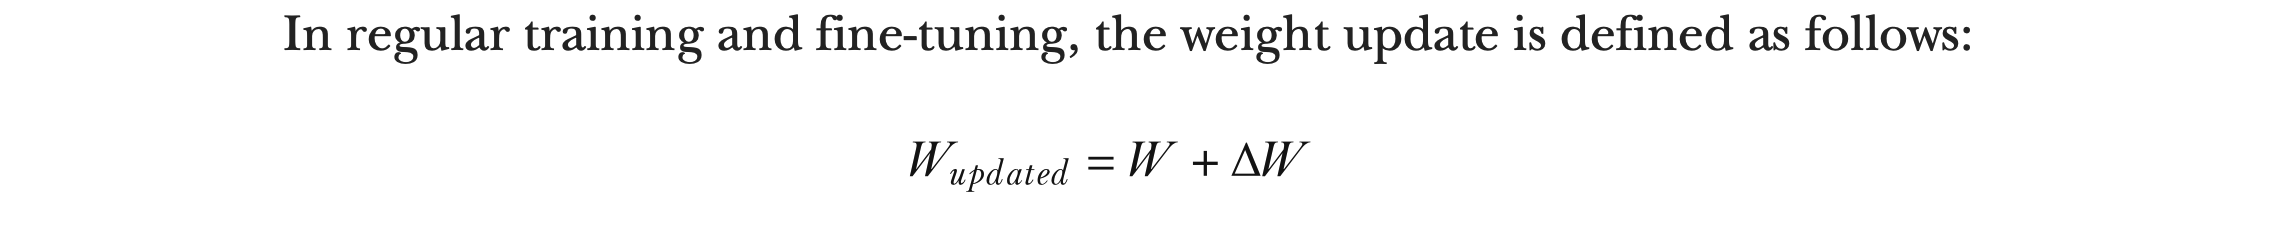

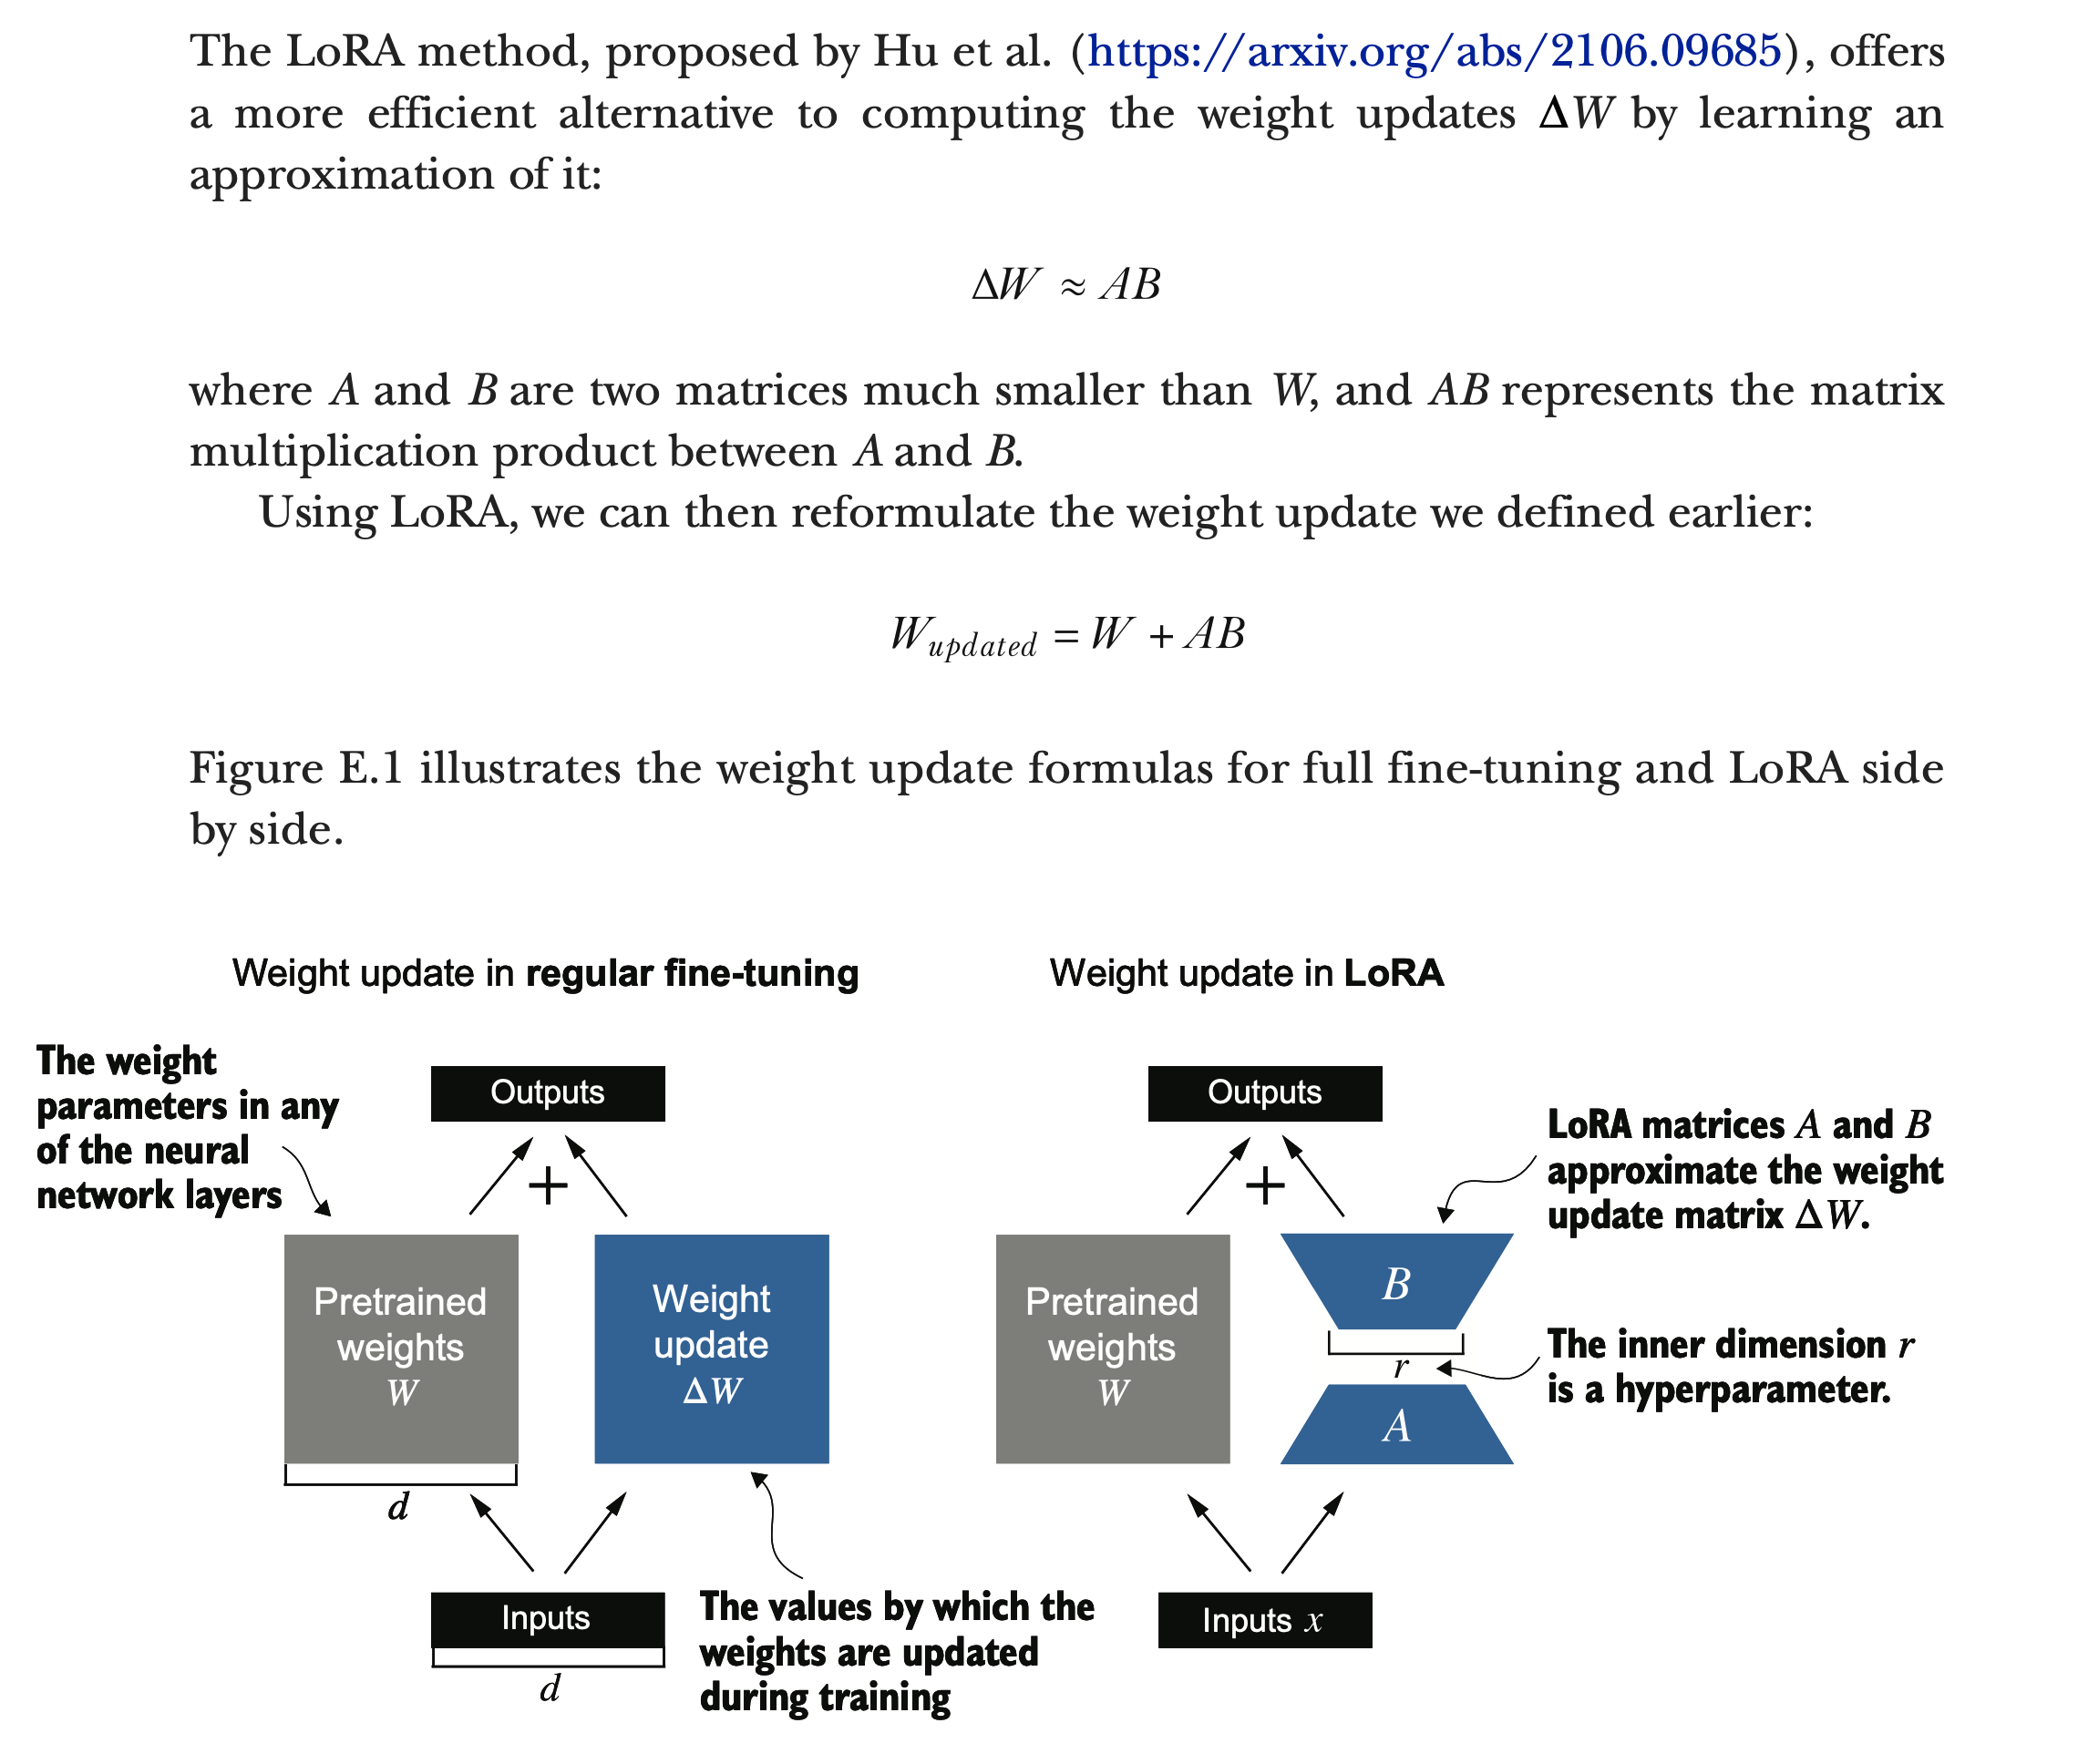

## Libs

In [ ]:
class LoRALayer(nn.Module):
  def __init__(self, in_dim, out_dim, rank, alpha):
    super().__init__()
    self.l1 = nn.Linear(in_dim, rank, bias=False)
    self.l2 = nn.Linear(rank, out_dim, bias=False)
    with torch.no_grad():
        self.l1.weight.fill_(0.0)
        # self.l2.weight.fill_(0.0)

    # Alpha is a regulation of the low-rank adaption.
    self.alpha = alpha

  def forward(self, x):
    # x: [B, in_dim]
    x = self.l1(x)  # [B, out_dim]
    x = self.l2(x)  # [B, in_dim]
    return x * self.alpha

In [ ]:
class LinearWithLoRA(nn.Module):
  def __init__(self, linear, rank, alpha):
    super().__init__()
    self.lora = LoRALayer(linear.in_features, linear.out_features, rank, alpha)
    self.linear = linear

  def forward(self, x):
    return self.lora(x) + self.linear(x)

In [ ]:
def replace_linear_with_lora(model, rank, alpha):
  for name, module in model.named_children():
    # print(f"{name=}, {type(module)=}")
    if isinstance(module, nn.Linear):
      setattr(model, name, LinearWithLoRA(module, rank, alpha))
    else:
      replace_linear_with_lora(module, rank, alpha)

## Training

In [ ]:
# @title Initialize the model

print(f"Initiating GPT-2 for config: {BASE_CONFIG}")

gpt_lora = GPTModel(BASE_CONFIG)
gpt_lora.eval()

load_weights_into_gpt(gpt_lora, params)
gpt_lora.to(device)

In [ ]:
# @title Test
def quick_test(model):
  torch.manual_seed(123)

  idx = text_to_token_ids("Is Texas in USA?", tokenizer).to(device)
  print(f"{idx.shape=}")
  for _ in range(5):
    print("=" * 80)

    out = generate(
        model,
        idx,
        max_new_tokens=25,
        context_size=BASE_CONFIG["context_length"],
        temperature=1.5,
        top_k=50)

    print(token_ids_to_text(out[0, :].to('cpu'), tokenizer))

quick_test(gpt_lora)

In [ ]:
# @title Model surgery to add LoRA
total_params = sum(p.numel() for p in gpt_lora.parameters() if p.requires_grad)
print(f"Total trainable parameters before: {total_params:,}")

for param in gpt_lora.parameters():
  param.requires_grad = False

total_params = sum(p.numel() for p in gpt_lora.parameters() if p.requires_grad)
print(f"Total trainable parameters after: {total_params:,}")

replace_linear_with_lora(gpt_lora, rank=32, alpha=16)
gpt_lora.to(device)

total_params = sum(p.numel() for p in gpt_lora.parameters() if p.requires_grad)
print(f"Total trainable LoRA parameters: {total_params:,}")

In [ ]:
gpt_lora

In [ ]:
for name, params in gpt_lora.named_parameters():
  print(f"{name=}, {params.requires_grad=}")

In [ ]:
for name, ps in gpt_lora.named_parameters():
  if name in ("out_head.lora.l1.weight", "out_head.lora.l2.weight", "trf_blocks.11.ffn.layers.2.lora.l2.weight", "out_head.linear.weight"):
    print(f"{name}: {ps}")


In [ ]:
# @title Test the initial LoRA doesn't change the output

# becasue the LoRA layers are initiated with zeros

quick_test(gpt_lora)

## Train

In [ ]:
import time
start_time = time.time()
torch.manual_seed(123)
optimizer = torch.optim.AdamW(
    gpt_lora.parameters(), lr=0.00005, weight_decay=0.1
)
num_epochs = 2

train_losses, val_losses, tokens_seen = train_model_simple(
    gpt_lora, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=5, eval_iter=5,
    start_context=format_input(val_data[0]), tokenizer=tokenizer
)

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

In [ ]:
for name, ps in gpt_lora.named_parameters():
  if name in ("out_head.lora.l1.weight", "out_head.lora.l2.weight", "trf_blocks.11.ffn.layers.2.lora.l2.weight", "out_head.linear.weight"):
    print(f"{name}: {ps}")


In [ ]:
epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

In [ ]:
quick_test(gpt_lora)

## Eval

In [ ]:
samples = sample_resp(gpt_lora, n_examples=10000000)

samples_out_file = "lora-data-with-response.json"
with open(samples_out_file, "w") as file:
  json.dump(samples, file, indent=4)

with open(samples_out_file, "r") as file:
  loaded_samples_lora = json.load(file)
  assert len(loaded_samples_lora) == len(samples)
  assert loaded_samples_lora[0] == samples[0]

In [ ]:
scores = generate_model_scores(loaded_samples_lora, "model_response")
print(f"Number of scores: {len(scores)} of {len(test_data)}")
print(f"Average score: {sum(scores)/len(scores):.2f}\n")